В этом ноутбуке демонстрируется возможность сценарного моделирования отклика пользователей с помощью параметрической трехкомпонентной функции отклика:
$$f_{syn}(u_i, m_j)=Ber(\alpha_1Heur(u_i,m_j)+\alpha_2Real(u_i,m_j)+\alpha_3Random(u_i,m_j)),$$
$$\alpha_1+\alpha_2+\alpha_3=1; \alpha_1,\alpha_2,\alpha_3\in[0,1],$$
$$\forall u_i\in U_{syn}; \forall m_j \in M,$$
где $u_i$ –- вектор атрибутов пользователя, $m_j$ –- вектор атрибутов предложения, $U_{syn}$ –- набор синтетических профилей пользователей, $M$ –- набор профилей предложений, $Heur$ -– это эвристическая компонента (основанная на предположении о полезности действия пользователя), $Real$ –- компонента, которая моделирует отклик в наборе данных реального мира, $Random$ -– случайная компонента, $Ber$ -– распределение Бернулли, необходимое для добавления стохастики в характер формирования отклика.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import time

import pandas as pd

from pyspark.sql import SparkSession
from replay.session_handler import State

from sklearn.metrics import roc_auc_score, precision_score, recall_score

import pyspark.sql.functions as sf
import pyspark.ml.functions as smf
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml import Pipeline
from pyspark.ml.classification import (
    LogisticRegression, RandomForestClassifier, FMClassifier
)

from replay.metrics import NDCG
from replay.data_preparator import Indexer
from replay.models import UCB

from sim4rec.modules import (
    SDVDataGenerator, RealDataGenerator,
    Simulator, evaluate_synthetic,
    EvaluateMetrics
)
from sim4rec.response import (
    BernoulliResponse, ParametricResponseFunction,
    CosineSimilatiry, NoiseResponse
)
from sim4rec.utils import VectorElementExtractor, pandas_to_spark

from datautils import read_netflix

%matplotlib inline
import matplotlib.pyplot as plt

SPARK_LOCAL_DIR = '/data/home/anthony/tmp'
CHECKPOINT_DIR = '/data/home/anthony/tmp/checkpoints'
DATA_PATH = r'file:///data/home/anthony/DL_0/real_data_simulator/Netflix'
MODELS_DIR = '../bin'

spark = SparkSession.builder\
    .appName('netflix_surface')\
    .master('local[16]')\
    .config('spark.sql.shuffle.partitions', '16')\
    .config('spark.default.parallelism', '16')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.sql.autoBroadcastJoinThreshold', '-1')\
    .config('spark.driver.memory', '128g')\
    .config('spark.local.dir', SPARK_LOCAL_DIR)\
    .getOrCreate()

State(spark)

22/11/16 12:36:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/11/16 12:36:08 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
22/11/16 12:36:08 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/11/16 12:36:08 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/11/16 12:36:08 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/11/16 12:36:08 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


In [2]:
def test_model(model_class, train_data, test_data, assembler, extractor):
    model = model_class(featuresCol='features', labelCol='relevance', probabilityCol='__prob_vec', predictionCol='response')

    start = time.time()
    pipeline = Pipeline(stages=[assembler, model, extractor]).fit(train_data)
    train_time = time.time() - start

    pred_pdf = pipeline\
        .transform(test_data)\
        .select('relevance', '__prob_raw', 'response')\
        .toPandas()

    roc_auc_model = roc_auc_score(pred_pdf.relevance, pred_pdf.__prob_raw)
    precision_model = precision_score(pred_pdf.relevance, pred_pdf.response)
    recall_model = recall_score(pred_pdf.relevance, pred_pdf.response)

    return train_time, pred_pdf,\
           {
            'roc_auc' : roc_auc_model,
            'precision' : precision_model,
            'recall' : recall_model
           }

Работаем с предобработанными данными, которые разделены на три части по времени выставления рейтинга. Оценки 1 и 2 считаем отрицательными (0); 3, 4 и 5 -- положительными (1).

Данные были предварительно предобработаны (код в папке Netflix): составлены профили польззователей и предложений по истории откликов, а также данные разделены по времени выставления оценок на обучающую, валидационную и тестовую выборки.

In [3]:
users_df_train, items_df_train, log_df_train = read_netflix(DATA_PATH, 'train', spark)

users_df_train = users_df_train.cache()
items_df_train = items_df_train.cache()
log_df_train = log_df_train.cache()

users_df_train.count()
items_df_train.count()
log_df_train.count()

22/11/16 12:36:45 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


50934106

In [4]:
users_df_val, items_df_val, log_df_val = read_netflix(DATA_PATH, 'val', spark)

users_df_val = users_df_val.cache()
items_df_val = items_df_val.cache()
log_df_val = log_df_val.cache()

users_df_val.count()
items_df_val.count()
log_df_val.count()

24430434

In [5]:
users_df_test, items_df_test, log_df_test = read_netflix(DATA_PATH, 'test', spark)

users_df_test = users_df_test.cache()
items_df_test = items_df_test.cache()
log_df_test = log_df_test.cache()

users_df_test.count()
items_df_test.count()
log_df_test.count()

25115967

# Генерация эмбеддингов

В результате экспериментального исследования методов генерации эмбеддингов (netflix_embeddings.ipynb) было решено использовать метод главных компонент в случае датасета Netflix. Далее с помощью этого метода генерируются профили пользователей.

Также были сгенерированы профили предложений, так как одна из компонент функции отклика (эвристическая) предполагает, что профили пользователей и предложений -- это векторы в одном и том же пространстве.

In [6]:
pca_va = VectorAssembler(
    inputCols=['user_rating_avg', 'user_rating_cnt'] + [f'user_w2v_{i}' for i in range(300)],
    outputCol='features'
)
pca_estimator = PCA(k=10, inputCol='features', outputCol='pca_features')

pca = Pipeline(stages=[pca_va, pca_estimator]).fit(users_df_train)

22/11/16 12:40:38 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/11/16 12:40:38 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/11/16 12:40:41 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/11/16 12:40:41 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [7]:
users_df_train_new = pca.transform(users_df_train)\
    .select('user_id', 'pca_features')\
    .withColumn('user_features', smf.vector_to_array('pca_features'))\
    .select(['user_id'] + [sf.col('user_features')[i] for i in range(10)])\
    .cache()

users_df_train.unpersist()
users_df_train = users_df_train_new

users_df_val_new = pca.transform(users_df_val)\
    .select('user_id', 'pca_features')\
    .withColumn('user_features', smf.vector_to_array('pca_features'))\
    .select(['user_id'] + [sf.col('user_features')[i] for i in range(10)])\
    .cache()

users_df_val.unpersist()
users_df_val = users_df_val_new

pca_va.setInputCols(['item_rating_avg', 'item_rating_cnt'] + [f'item_w2v_{i}' for i in range(300)])

items_df_train_new = pca.transform(items_df_train)\
    .select('item_id', 'pca_features')\
    .withColumn('item_features', smf.vector_to_array('pca_features'))\
    .select(['item_id'] + [sf.col('item_features')[i] for i in range(10)])\
    .cache()

items_df_train.unpersist()
items_df_train = items_df_train_new

items_df_val_new = pca.transform(items_df_val)\
    .select('item_id', 'pca_features')\
    .withColumn('item_features', smf.vector_to_array('pca_features'))\
    .select(['item_id'] + [sf.col('item_features')[i] for i in range(10)])\
    .cache()

items_df_val.unpersist()
items_df_val = items_df_val_new

# Обучение генератора

Также в ноутбуке netflix_embeddings.ipynb был сделан вывод о том, что модель генерации TVAE является наиболее подходящей в случае датасета Netflix и эмбеддингов на основе PCA. Поэтому здесь будет использована именно эта модель.

In [8]:
# user_generator = SDVDataGenerator(
#     label='synth_user',
#     id_column_name='user_id',
#     model_name='tvae',
#     parallelization_level=8,
#     device_name='cpu',
#     seed=1234
# )

# user_generator.fit(users_df_train)

user_generator = SDVDataGenerator.load(f'{MODELS_DIR}/netflix_pca_users_tvae.pkl')
user_generator.setDevice('cpu')
user_generator.setParallelizationLevel(8)

users_synth = user_generator.generate(users_df_train.count())

eval_frac = 1000 / users_df_train.count()
gen_score = evaluate_synthetic(
    synth_df=users_synth.sample(eval_frac).drop('user_id'),
    real_df=users_df_train.sample(eval_frac).drop('user_id')
)

gen_score

Cannot load model to device cuda:0. Setting cpu instead


{'LogisticDetection': 0.6431087932948136,
 'SVCDetection': 0.5099692814180878,
 'KSTest': 0.897764849022009,
 'ContinuousKLDivergence': 0.8349181803669152}

In [9]:
item_generator = RealDataGenerator(label='real_item', seed=1234)
item_generator.fit(items_df_train)
_ = item_generator.generate(items_df_train.count())

22/11/16 12:41:12 WARN CacheManager: Asked to cache already cached data.


# Инициализация симулятора

In [10]:
simulator = Simulator(
    user_gen=user_generator,
    item_gen=item_generator,
    user_key_col='user_id',
    item_key_col='item_id',
    spark_session=spark,
    data_dir=f'{CHECKPOINT_DIR}/netflix_surface'
)

# Обучение регрессии

В ноутбуке netflix_response.ipynb было замечено, что логистическая регрессия дает лучшее качество с точки зрения ROC-AUC и Precision по сравнению с двумя другими моделями. Кроме того, она обучается заметно быстрее, чем матричная факторизация. Поэтому эта модель была выбрана для реализации компоненты Real функции отклика.

Напомним, что профили пользователей и предложений, относящиеся к периоду train (users_df_train и items_df_train соответственно) построены по истории взаимодействий из log_df_train. Поэтому для обучения модели отклика используются профили пользователей users_df_train и предложений items_df_train, а также лог log_df_val. Для оценки качества модели отклика используются профили users_df_val и items_df_val, построенные по объединенному логу log_df_train и log_df_val, а также лог log_df_test.

In [11]:
feature_cols = [f'user_features[{i}]' for i in range(10)] +\
               [f'item_features[{i}]' for i in range(10)]

assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
extractor = VectorElementExtractor(inputCol='__prob_vec', outputCol='__prob_raw', index=1)

train_df = log_df_val\
    .sample(100000 / log_df_val.count())\
    .drop('timestamp')\
    .join(users_df_train, on='user_id', how='left')\
    .join(items_df_train, on='item_id', how='left')\
    .na.drop()\
    .cache()

test_df = log_df_test\
    .sample(100000 / log_df_test.count())\
    .drop('timestamp')\
    .join(users_df_val, on='user_id', how='left')\
    .join(items_df_val, on='item_id', how='left')\
    .na.drop()\
    .cache()

# Качество логистической регрессии

In [12]:
lr_time, lr_pdf, lr_model_metrics = test_model(
    model_class=LogisticRegression,
    train_data=train_df,
    test_data=test_df,
    assembler=assembler,
    extractor=extractor
)

LogisticRegression pipeline train time: 34.68479013442993
LogisticRegression metrics: {'roc_auc': 0.7147234866675292, 'precision': 0.8727658600528495, 'recall': 0.997989555203959}


<AxesSubplot: >

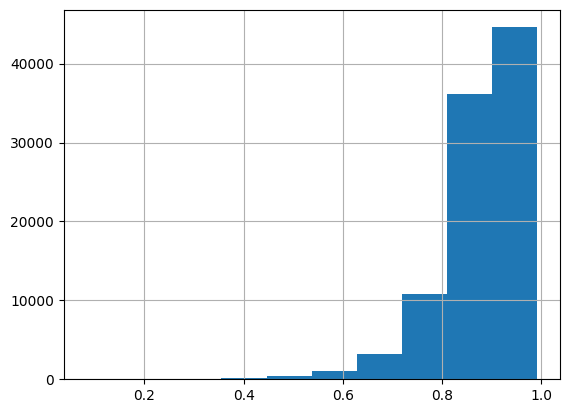

In [13]:
print(f'LogisticRegression pipeline train time: {lr_time}')
print(f'LogisticRegression metrics: {lr_model_metrics}')

lr_pdf['__prob_raw'].hist()

# Качество случайного леса

In [14]:
rf_time, rf_pdf, rf_model_metrics = test_model(
    model_class=RandomForestClassifier,
    train_data=train_df,
    test_data=test_df,
    assembler=assembler,
    extractor=extractor
)

RandomForestClassifier pipeline train time: 9.589737176895142
RandomForestClassifier metrics: {'roc_auc': 0.63883747262445, 'precision': 0.8702660730924526, 'recall': 0.999976207753893}


<AxesSubplot: >

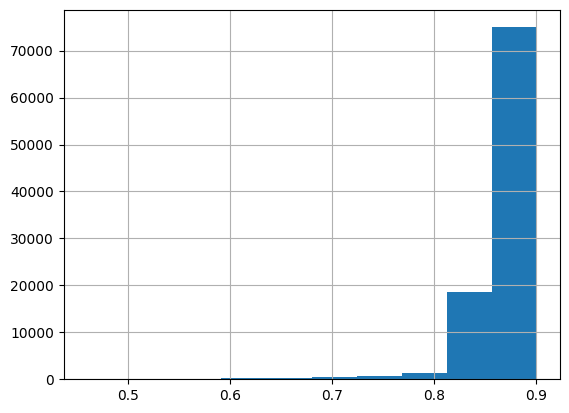

In [15]:
print(f'RandomForestClassifier pipeline train time: {rf_time}')
print(f'RandomForestClassifier metrics: {rf_model_metrics}')

rf_pdf['__prob_raw'].hist()

# Обучение рексистемы

Далее будем в цикле обучать рекомендательную систему на откликах синтетических пользователей, полученных с помощью симулятора.

In [16]:
lr = LogisticRegression(featuresCol='features', labelCol='relevance', probabilityCol='__prob_vec')

va_users = VectorAssembler(inputCols=[f'user_features[{i}]' for i in range(10)], outputCol='features_usr')
va_items = VectorAssembler(inputCols=[f'item_features[{i}]' for i in range(10)], outputCol='features_itm')

heur_resp = CosineSimilatiry(inputCols=['features_usr', 'features_itm'], outputCol='__cosine_resp')
noise_resp = NoiseResponse(mu=0.5, sigma=0.2, outputCol='__noise_resp', seed=1234)

resp_func = ParametricResponseFunction(
    inputCols=['__prob_raw', '__cosine_resp', '__noise_resp'],
    outputCol='__prob',
    weights=[1.0, 0.0, 0.0]
)

bernoulli = BernoulliResponse(inputCol='__prob', outputCol='response', seed=1234)

pipeline = Pipeline(stages=[assembler, lr, extractor, va_users, va_items, heur_resp, noise_resp, resp_func, bernoulli]).fit(train_df)

In [17]:
indexer = Indexer(user_col='user_id', item_col='item_id')
indexer.fit(users=user_generator.sample(1.0), items=item_generator.sample(1.0))

dummy_log = pandas_to_spark(pd.DataFrame({'user_idx' : [1], 'item_idx' : [1], 'relevance' : [0.0]}))

In [18]:
evaluator = EvaluateMetrics(
    userKeyCol='user_id',
    itemKeyCol='item_id',
    predictionCol='relevance',
    labelCol='response',
    replay_label_filter=1.0,
    replay_metrics={NDCG() : 10}
)

In [19]:
DISC = 10

alphas = []
for a1 in range(DISC + 1):
    for a2 in range(DISC - a1 + 1):
        a3 = DISC - a1 - a2

        a_sum = (a1 + a2 + a3) * 4
        alphas.append([a1 / a_sum, a2 / a_sum, a3 / a_sum])

user_frac = 10000 / user_generator.getDataSize()
item_frac = 0.4

In [20]:
users_replay = indexer.transform(user_generator.sample(1.0)).cache()
items_replay = indexer.transform(item_generator.sample(1.0)).cache()

Далее будем в цикле обучать рекомендательную систему на откликах синтетических пользователей, полученных с помощью симулятора, в течение 50 итераций. Затем будем считать значение метрики NDCG@10 для обученной рексистемы и переходить к следующей комбинации параметров функции отклика.

In [ ]:
surface_ndcg = []

for a in alphas:
    resp_func.setWeights(a)
    simulator.log_filename = f'log_{"_".join([str(a_i * 4) for a_i in a])}.parquet'

    ucb = UCB(sample=True)
    ucb.fit(dummy_log)

    print(f'Current weights: {a}')

    for i in range(50):
        iter_start = time.time()

        # users = simulator.sample_users(user_frac).cache()
        # items = simulator.sample_items(item_frac).cache()
        users = users_replay.sample(user_frac).withColumnRenamed('user_idx', 'user_id').cache()
        items = items_replay.sample(item_frac).withColumnRenamed('item_idx', 'item_id').cache()
        log = simulator.get_log(users)
        log = dummy_log.withColumnRenamed('user_idx', 'user_id').withColumnRenamed('item_idx', 'item_id') if log is None else log
        log = log.cache()

        recs_ucb = ucb.predict(
            log=log.withColumnRenamed('user_id', 'user_idx').withColumnRenamed('item_id', 'item_idx'),
            k=10,
            users=users.withColumnRenamed('user_id', 'user_idx'),
            items=items.withColumnRenamed('item_id', 'item_idx'),
            filter_seen_items=False
        )
        recs_ucb = recs_ucb.withColumnRenamed('user_idx', 'user_id').withColumnRenamed('item_idx', 'item_id').cache()

        resp_ucb = simulator.sample_responses(
            recs_df=recs_ucb,
            user_features=users,
            item_features=items,
            action_models=pipeline
        ).select('user_id', 'item_id', 'relevance', 'response').cache()

        simulator.update_log(resp_ucb, iteration=i)

        ucb._clear_cache()
        ucb_train_log = simulator.log.cache()
        ucb.fit(log=ucb_train_log.select('user_id', 'item_id', 'response').withColumnRenamed('user_id', 'user_idx').withColumnRenamed('item_id', 'item_idx').withColumnRenamed('response', 'relevance'))

        users.unpersist()
        items.unpersist()
        log.unpersist()
        recs_ucb.unpersist()
        resp_ucb.unpersist()
        ucb_train_log.unpersist()

        print(f'Iteration {i} finished in {time.time() - iter_start} sec.')

    users = users_replay.sample(user_frac).withColumnRenamed('user_idx', 'user_id').cache()
    items = items_replay.sample(item_frac).withColumnRenamed('item_idx', 'item_id').cache()
    log = simulator.get_log(users).cache()

    recs_ucb = ucb.predict(
        log=log.withColumnRenamed('user_id', 'user_idx').withColumnRenamed('item_id', 'item_idx'),
        k=10,
        users=users.withColumnRenamed('user_id', 'user_idx'),
        items=items.withColumnRenamed('item_id', 'item_idx'),
        filter_seen_items=False
    )
    recs_ucb = recs_ucb.withColumnRenamed('user_idx', 'user_id').withColumnRenamed('item_idx', 'item_id').cache()

    resp_ucb = simulator.sample_responses(
        recs_df=recs_ucb,
        user_features=users,
        item_features=items,
        action_models=pipeline
    ).select('user_id', 'item_id', 'relevance', 'response').cache()

    metrics = evaluator(resp_ucb)

    users.unpersist()
    items.unpersist()
    log.unpersist()
    recs_ucb.unpersist()
    resp_ucb.unpersist()

    surface_ndcg.append({
        'LR' : a[0], 'cosine' : a[1],
        'noise' : a[2], 'ndcg' : metrics['NDCG@10']
    })
    
    surface_pdf = pd.DataFrame(surface_ndcg)
    surface_pdf.to_csv('../bin/netflix_surface_ndcg.csv', index=False)

Current weights: [0.0, 0.0, 0.25]


22/11/16 12:43:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:43:25 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:43:26 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:43:28 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:43:29 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB


Iteration 0 finished in 25.460384607315063 sec.


22/11/16 12:43:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:43:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:43:50 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:43:53 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:43:54 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:43:58 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:43:58 WARN CacheManager: Asked to cache already cached data.


Iteration 1 finished in 23.723145723342896 sec.


22/11/16 12:44:12 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:44:13 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:44:14 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:44:16 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:44:18 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:44:21 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:44:21 WARN CacheManager: Asked to cache already cached data.


Iteration 2 finished in 22.02242946624756 sec.


22/11/16 12:44:33 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:44:34 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:44:34 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:44:37 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:44:38 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:44:42 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:44:42 WARN CacheManager: Asked to cache already cached data.


Iteration 3 finished in 20.203163862228394 sec.


22/11/16 12:44:53 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:44:54 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:44:54 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:44:57 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:44:58 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:45:00 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:45:00 WARN CacheManager: Asked to cache already cached data.


Iteration 4 finished in 18.03662419319153 sec.


22/11/16 12:45:12 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:45:12 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:45:13 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:45:15 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:45:16 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:45:18 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:45:18 WARN CacheManager: Asked to cache already cached data.


Iteration 5 finished in 17.25337314605713 sec.


22/11/16 12:45:30 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:45:30 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:45:31 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:45:33 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:45:36 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:45:38 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:45:38 WARN CacheManager: Asked to cache already cached data.


Iteration 6 finished in 20.429354906082153 sec.


22/11/16 12:45:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:45:52 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:45:52 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:45:55 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:45:56 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:45:58 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:45:58 WARN CacheManager: Asked to cache already cached data.


Iteration 7 finished in 20.16923451423645 sec.


22/11/16 12:46:11 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:46:11 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:46:12 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:46:15 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:46:17 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:46:19 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:46:19 WARN CacheManager: Asked to cache already cached data.


Iteration 8 finished in 21.60329246520996 sec.


22/11/16 12:46:35 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:46:36 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:46:36 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:46:38 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:46:39 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:46:41 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:46:41 WARN CacheManager: Asked to cache already cached data.


Iteration 9 finished in 22.452157974243164 sec.


22/11/16 12:46:54 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:46:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:46:56 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:46:59 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:46:59 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:47:02 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:47:02 WARN CacheManager: Asked to cache already cached data.


Iteration 10 finished in 19.783488750457764 sec.


22/11/16 12:47:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:47:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:47:15 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:47:17 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:47:18 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:47:20 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:47:20 WARN CacheManager: Asked to cache already cached data.


Iteration 11 finished in 18.563896417617798 sec.


22/11/16 12:47:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:47:33 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:47:34 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:47:36 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:47:38 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:47:40 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:47:40 WARN CacheManager: Asked to cache already cached data.


Iteration 12 finished in 18.8813533782959 sec.


22/11/16 12:47:50 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:47:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:47:52 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:47:54 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:47:55 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:47:58 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:47:58 WARN CacheManager: Asked to cache already cached data.


Iteration 13 finished in 18.631669282913208 sec.


22/11/16 12:48:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:48:11 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:48:11 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:48:14 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:48:15 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:48:17 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:48:17 WARN CacheManager: Asked to cache already cached data.


Iteration 14 finished in 19.021547555923462 sec.


22/11/16 12:48:28 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:48:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:48:29 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:48:32 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:48:33 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:48:36 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:48:36 WARN CacheManager: Asked to cache already cached data.


Iteration 15 finished in 18.908645391464233 sec.


22/11/16 12:48:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:48:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:48:49 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:48:51 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:48:52 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:48:54 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:48:54 WARN CacheManager: Asked to cache already cached data.


Iteration 16 finished in 18.461788415908813 sec.


22/11/16 12:49:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:49:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:49:06 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:49:09 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:49:10 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:49:12 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:49:12 WARN CacheManager: Asked to cache already cached data.


Iteration 17 finished in 18.00043749809265 sec.


22/11/16 12:49:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:49:25 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:49:26 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:49:28 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:49:29 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:49:31 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:49:31 WARN CacheManager: Asked to cache already cached data.


Iteration 18 finished in 18.856961250305176 sec.


22/11/16 12:49:43 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:49:44 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:49:44 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:49:47 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:49:49 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:49:51 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:49:51 WARN CacheManager: Asked to cache already cached data.


Iteration 19 finished in 19.407533645629883 sec.


22/11/16 12:50:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:50:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:50:04 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:50:07 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:50:08 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:50:10 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:50:10 WARN CacheManager: Asked to cache already cached data.


Iteration 20 finished in 19.041574716567993 sec.


22/11/16 12:50:21 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:50:21 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:50:22 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:50:25 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:50:26 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:50:28 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:50:28 WARN CacheManager: Asked to cache already cached data.


Iteration 21 finished in 18.84027862548828 sec.


22/11/16 12:50:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:50:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:50:41 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:50:44 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:50:45 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:50:47 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:50:47 WARN CacheManager: Asked to cache already cached data.


Iteration 22 finished in 18.832011461257935 sec.


22/11/16 12:50:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:51:00 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:51:00 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:51:03 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:51:04 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:51:06 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:51:06 WARN CacheManager: Asked to cache already cached data.


Iteration 23 finished in 18.98386549949646 sec.


22/11/16 12:51:18 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:51:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:51:19 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:51:22 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:51:23 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:51:26 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:51:26 WARN CacheManager: Asked to cache already cached data.


Iteration 24 finished in 19.31982398033142 sec.


22/11/16 12:51:37 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:51:38 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:51:38 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:51:41 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:51:43 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:51:44 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:51:44 WARN CacheManager: Asked to cache already cached data.


Iteration 25 finished in 19.005276679992676 sec.


22/11/16 12:51:57 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:51:57 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:51:57 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:52:00 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:52:02 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:52:04 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:52:04 WARN CacheManager: Asked to cache already cached data.


Iteration 26 finished in 19.87349271774292 sec.


22/11/16 12:52:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:52:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:52:17 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:52:19 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:52:20 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:52:22 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:52:22 WARN CacheManager: Asked to cache already cached data.


Iteration 27 finished in 18.048293113708496 sec.


22/11/16 12:52:34 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:52:35 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:52:35 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:52:38 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:52:40 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:52:42 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:52:42 WARN CacheManager: Asked to cache already cached data.


Iteration 28 finished in 20.68484330177307 sec.


22/11/16 12:52:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:52:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:52:56 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:52:59 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:53:00 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:53:02 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:53:02 WARN CacheManager: Asked to cache already cached data.


Iteration 29 finished in 18.40278434753418 sec.


22/11/16 12:53:13 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:53:13 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:53:14 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:53:17 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:53:19 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:53:20 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:53:20 WARN CacheManager: Asked to cache already cached data.


Iteration 30 finished in 19.34209156036377 sec.


22/11/16 12:53:33 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:53:33 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:53:34 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:53:36 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:53:39 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:53:40 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:53:40 WARN CacheManager: Asked to cache already cached data.


Iteration 31 finished in 19.65315341949463 sec.


22/11/16 12:53:52 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:53:53 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:53:53 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:53:56 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:53:58 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:54:00 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:54:00 WARN CacheManager: Asked to cache already cached data.


Iteration 32 finished in 20.61197257041931 sec.


22/11/16 12:54:13 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:54:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:54:14 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:54:17 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:54:18 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:54:20 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:54:20 WARN CacheManager: Asked to cache already cached data.


Iteration 33 finished in 19.0261812210083 sec.


22/11/16 12:54:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:54:33 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:54:33 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:54:35 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:54:37 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:54:39 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:54:39 WARN CacheManager: Asked to cache already cached data.


Iteration 34 finished in 19.48001456260681 sec.


22/11/16 12:54:52 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:54:53 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:54:53 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:54:56 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:54:57 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:55:00 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:55:00 WARN CacheManager: Asked to cache already cached data.


Iteration 35 finished in 21.132529973983765 sec.


22/11/16 12:55:13 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:55:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:55:14 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:55:17 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:55:19 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:55:21 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:55:21 WARN CacheManager: Asked to cache already cached data.


Iteration 36 finished in 20.030776023864746 sec.


22/11/16 12:55:33 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:55:33 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:55:34 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:55:36 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:55:38 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:55:40 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:55:40 WARN CacheManager: Asked to cache already cached data.


Iteration 37 finished in 19.87689781188965 sec.


22/11/16 12:55:54 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:55:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:55:56 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:55:58 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:56:00 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:56:02 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:56:02 WARN CacheManager: Asked to cache already cached data.


Iteration 38 finished in 22.140193700790405 sec.


22/11/16 12:56:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:56:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:56:15 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:56:18 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:56:20 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:56:22 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:56:22 WARN CacheManager: Asked to cache already cached data.


Iteration 39 finished in 21.056479454040527 sec.


22/11/16 12:56:36 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:56:37 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:56:38 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:56:40 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:56:41 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:56:44 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:56:44 WARN CacheManager: Asked to cache already cached data.


Iteration 40 finished in 20.35518479347229 sec.


22/11/16 12:56:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:56:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:56:57 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:57:00 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:57:01 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:57:04 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:57:04 WARN CacheManager: Asked to cache already cached data.


Iteration 41 finished in 21.189881563186646 sec.


22/11/16 12:57:18 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:57:18 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:57:19 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:57:22 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:57:24 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:57:26 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:57:26 WARN CacheManager: Asked to cache already cached data.


Iteration 42 finished in 20.609841346740723 sec.


22/11/16 12:57:37 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:57:38 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:57:38 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:57:41 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:57:44 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:57:45 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:57:45 WARN CacheManager: Asked to cache already cached data.


Iteration 43 finished in 19.843693256378174 sec.


22/11/16 12:58:01 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:58:01 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:58:02 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:58:04 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:58:06 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:58:08 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:58:08 WARN CacheManager: Asked to cache already cached data.


Iteration 44 finished in 22.745877981185913 sec.


22/11/16 12:58:20 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:58:21 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:58:21 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:58:24 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:58:25 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:58:27 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:58:27 WARN CacheManager: Asked to cache already cached data.


Iteration 45 finished in 19.413543939590454 sec.


22/11/16 12:58:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:58:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:58:42 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:58:46 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:58:47 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:58:49 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:58:49 WARN CacheManager: Asked to cache already cached data.


Iteration 46 finished in 21.658982038497925 sec.


22/11/16 12:59:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:59:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:59:03 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:59:06 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:59:07 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:59:09 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:59:09 WARN CacheManager: Asked to cache already cached data.


Iteration 47 finished in 20.08810806274414 sec.


22/11/16 12:59:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:59:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:59:23 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:59:25 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:59:26 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:59:28 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:59:28 WARN CacheManager: Asked to cache already cached data.


Iteration 48 finished in 19.849672555923462 sec.


22/11/16 12:59:43 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:59:43 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 12:59:44 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 12:59:46 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 12:59:47 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 12:59:50 WARN CacheManager: Asked to cache already cached data.        
22/11/16 12:59:50 WARN CacheManager: Asked to cache already cached data.


Iteration 49 finished in 21.52289628982544 sec.


22/11/16 13:00:07 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:00:08 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:00:08 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:00:10 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:00:12 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 13:00:12 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 13:00:14 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 13:00:16 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 13:00:17 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:00:17 WARN CacheManager: Asked to cache already cached data.


Current weights: [0.0, 0.025, 0.225]


22/11/16 13:00:28 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:00:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:00:29 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:00:32 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:00:35 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB


Iteration 0 finished in 20.182265758514404 sec.


22/11/16 13:00:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:00:50 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:00:50 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:00:53 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:00:54 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:00:56 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:00:56 WARN CacheManager: Asked to cache already cached data.


Iteration 1 finished in 19.376607418060303 sec.


22/11/16 13:01:07 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:01:08 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:01:09 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:01:11 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:01:13 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:01:15 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:01:15 WARN CacheManager: Asked to cache already cached data.


Iteration 2 finished in 19.958786010742188 sec.


22/11/16 13:01:28 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:01:28 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:01:29 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:01:32 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:01:33 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:01:35 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:01:35 WARN CacheManager: Asked to cache already cached data.


Iteration 3 finished in 19.050827026367188 sec.


22/11/16 13:01:46 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:01:47 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:01:48 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:01:50 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:01:52 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:01:53 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:01:53 WARN CacheManager: Asked to cache already cached data.


Iteration 4 finished in 17.745932579040527 sec.


22/11/16 13:02:04 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:02:04 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:02:05 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:02:08 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:02:09 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:02:12 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:02:12 WARN CacheManager: Asked to cache already cached data.


Iteration 5 finished in 19.741690158843994 sec.


22/11/16 13:02:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:02:25 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:02:25 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:02:28 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:02:30 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:02:32 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:02:32 WARN CacheManager: Asked to cache already cached data.


Iteration 6 finished in 18.899272203445435 sec.


22/11/16 13:02:43 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:02:43 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:02:45 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:02:47 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:02:48 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:02:51 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:02:51 WARN CacheManager: Asked to cache already cached data.


Iteration 7 finished in 19.181774139404297 sec.


22/11/16 13:03:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:03:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:03:04 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:03:07 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:03:09 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:03:11 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:03:11 WARN CacheManager: Asked to cache already cached data.


Iteration 8 finished in 20.143678188323975 sec.


22/11/16 13:03:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:03:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:03:23 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:03:26 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:03:28 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:03:30 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:03:30 WARN CacheManager: Asked to cache already cached data.


Iteration 9 finished in 19.073956727981567 sec.


22/11/16 13:03:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:03:42 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:03:42 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:03:45 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:03:46 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:03:49 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:03:49 WARN CacheManager: Asked to cache already cached data.


Iteration 10 finished in 18.65445351600647 sec.


22/11/16 13:04:01 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:04:01 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:04:02 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:04:05 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:04:07 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:04:09 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:04:09 WARN CacheManager: Asked to cache already cached data.


Iteration 11 finished in 20.105093955993652 sec.


22/11/16 13:04:20 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:04:21 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:04:22 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:04:25 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:04:27 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:04:28 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:04:28 WARN CacheManager: Asked to cache already cached data.


Iteration 12 finished in 19.687341928482056 sec.


22/11/16 13:04:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:04:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:04:40 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:04:43 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:04:44 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:04:46 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:04:46 WARN CacheManager: Asked to cache already cached data.


Iteration 13 finished in 18.028321266174316 sec.


22/11/16 13:04:57 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:04:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:04:59 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:05:02 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:05:04 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:05:06 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:05:06 WARN CacheManager: Asked to cache already cached data.


Iteration 14 finished in 20.445096015930176 sec.


22/11/16 13:05:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:05:20 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:05:20 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:05:23 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:05:25 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:05:27 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:05:27 WARN CacheManager: Asked to cache already cached data.


Iteration 15 finished in 20.1414692401886 sec.


22/11/16 13:05:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:05:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:05:40 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:05:43 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:05:44 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:05:47 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:05:47 WARN CacheManager: Asked to cache already cached data.


Iteration 16 finished in 19.943815231323242 sec.


22/11/16 13:05:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:05:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:05:59 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:06:03 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:06:06 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:06:08 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:06:08 WARN CacheManager: Asked to cache already cached data.


Iteration 17 finished in 35.1958749294281 sec.


22/11/16 13:06:37 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:06:37 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:06:38 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:06:41 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:06:44 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:06:47 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:06:47 WARN CacheManager: Asked to cache already cached data.


Iteration 18 finished in 25.260600090026855 sec.


22/11/16 13:07:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:07:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:07:04 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:07:07 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:07:08 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:07:11 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:07:11 WARN CacheManager: Asked to cache already cached data.


Iteration 19 finished in 24.04237937927246 sec.


22/11/16 13:07:23 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:07:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:07:25 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:07:27 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:07:30 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:07:32 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:07:32 WARN CacheManager: Asked to cache already cached data.


Iteration 20 finished in 20.372822523117065 sec.


22/11/16 13:07:43 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:07:44 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:07:44 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:07:47 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:07:48 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:07:51 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:07:51 WARN CacheManager: Asked to cache already cached data.


Iteration 21 finished in 19.418612241744995 sec.


22/11/16 13:08:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:08:04 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:08:05 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:08:08 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:08:10 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:08:12 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:08:12 WARN CacheManager: Asked to cache already cached data.


Iteration 22 finished in 20.972285747528076 sec.


22/11/16 13:08:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:08:25 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:08:26 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:08:29 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:08:31 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:08:33 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:08:33 WARN CacheManager: Asked to cache already cached data.


Iteration 23 finished in 20.768702745437622 sec.


22/11/16 13:08:45 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:08:45 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:08:46 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:08:48 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:08:49 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:08:52 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:08:52 WARN CacheManager: Asked to cache already cached data.


Iteration 24 finished in 18.859906911849976 sec.


22/11/16 13:09:04 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:09:04 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:09:05 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:09:07 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:09:10 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:09:12 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:09:12 WARN CacheManager: Asked to cache already cached data.


Iteration 25 finished in 20.18206548690796 sec.


22/11/16 13:09:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:09:23 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:09:23 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:09:26 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:09:27 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:09:30 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:09:30 WARN CacheManager: Asked to cache already cached data.


Iteration 26 finished in 18.208574771881104 sec.


22/11/16 13:09:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:09:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:09:41 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:09:44 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:09:46 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:09:48 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:09:48 WARN CacheManager: Asked to cache already cached data.


Iteration 27 finished in 17.754070281982422 sec.


22/11/16 13:09:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:10:00 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:10:01 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:10:04 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:10:05 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:10:08 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:10:08 WARN CacheManager: Asked to cache already cached data.


Iteration 28 finished in 20.385298013687134 sec.


22/11/16 13:10:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:10:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:10:20 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:10:22 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:10:24 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:10:26 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:10:26 WARN CacheManager: Asked to cache already cached data.


Iteration 29 finished in 17.994442224502563 sec.


22/11/16 13:10:37 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:10:37 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:10:38 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:10:40 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:10:42 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:10:43 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:10:43 WARN CacheManager: Asked to cache already cached data.


Iteration 30 finished in 18.289384841918945 sec.


22/11/16 13:10:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:10:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:10:56 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:10:59 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:11:00 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:11:03 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:11:03 WARN CacheManager: Asked to cache already cached data.


Iteration 31 finished in 18.711736917495728 sec.


22/11/16 13:11:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:11:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:11:15 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:11:17 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:11:18 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:11:19 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:11:19 WARN CacheManager: Asked to cache already cached data.


Iteration 32 finished in 16.507516622543335 sec.


22/11/16 13:11:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:11:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:11:32 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:11:34 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:11:35 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:11:38 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:11:38 WARN CacheManager: Asked to cache already cached data.


Iteration 33 finished in 19.210473775863647 sec.


22/11/16 13:11:50 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:11:50 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:11:51 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:11:53 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:11:56 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:11:58 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:11:58 WARN CacheManager: Asked to cache already cached data.


Iteration 34 finished in 20.61491107940674 sec.


22/11/16 13:12:11 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:12:11 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:12:12 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:12:14 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:12:15 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:12:18 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:12:18 WARN CacheManager: Asked to cache already cached data.


Iteration 35 finished in 19.13235878944397 sec.


22/11/16 13:12:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:12:30 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:12:31 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:12:33 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:12:34 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:12:37 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:12:37 WARN CacheManager: Asked to cache already cached data.


Iteration 36 finished in 18.779446601867676 sec.


22/11/16 13:12:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:12:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:12:49 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:12:51 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:12:52 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:12:54 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:12:54 WARN CacheManager: Asked to cache already cached data.


Iteration 37 finished in 17.639577388763428 sec.


22/11/16 13:13:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:13:07 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:13:08 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:13:10 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:13:12 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:13:14 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:13:14 WARN CacheManager: Asked to cache already cached data.


Iteration 38 finished in 19.35703754425049 sec.


22/11/16 13:13:25 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:13:26 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:13:26 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:13:28 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:13:29 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:13:32 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:13:32 WARN CacheManager: Asked to cache already cached data.


Iteration 39 finished in 18.5644633769989 sec.


22/11/16 13:13:44 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:13:44 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:13:45 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:13:47 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:13:48 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:13:50 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:13:50 WARN CacheManager: Asked to cache already cached data.


Iteration 40 finished in 18.074738264083862 sec.


22/11/16 13:14:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:14:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:14:03 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:14:06 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:14:08 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:14:10 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:14:10 WARN CacheManager: Asked to cache already cached data.


Iteration 41 finished in 20.20378804206848 sec.


22/11/16 13:14:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:14:23 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:14:24 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:14:26 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:14:27 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:14:30 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:14:30 WARN CacheManager: Asked to cache already cached data.


Iteration 42 finished in 21.29295015335083 sec.


22/11/16 13:14:43 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:14:44 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:14:44 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:14:47 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:14:48 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:14:50 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:14:50 WARN CacheManager: Asked to cache already cached data.


Iteration 43 finished in 21.54586386680603 sec.


22/11/16 13:15:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:15:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:15:07 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:15:09 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:15:13 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:15:15 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:15:15 WARN CacheManager: Asked to cache already cached data.


Iteration 44 finished in 25.377132892608643 sec.


22/11/16 13:15:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:15:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:15:33 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:15:35 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:15:36 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:15:39 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:15:39 WARN CacheManager: Asked to cache already cached data.


Iteration 45 finished in 22.05228543281555 sec.


22/11/16 13:15:53 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:15:54 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:15:54 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:15:56 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:15:58 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:16:01 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:16:01 WARN CacheManager: Asked to cache already cached data.


Iteration 46 finished in 21.79387593269348 sec.


22/11/16 13:16:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:16:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:16:16 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:16:18 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:16:19 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:16:21 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:16:21 WARN CacheManager: Asked to cache already cached data.


Iteration 47 finished in 23.883424282073975 sec.


22/11/16 13:16:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:16:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:16:41 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:16:43 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:16:45 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:16:47 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:16:47 WARN CacheManager: Asked to cache already cached data.


Iteration 48 finished in 22.819377183914185 sec.


22/11/16 13:17:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:17:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:17:03 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:17:05 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:17:07 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:17:09 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:17:09 WARN CacheManager: Asked to cache already cached data.


Iteration 49 finished in 21.51298761367798 sec.


22/11/16 13:17:26 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:17:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:17:27 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:17:30 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:17:32 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 13:17:32 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 13:17:33 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 13:17:35 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 13:17:35 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:17:35 WARN CacheManager: Asked to cache already cached data.


Current weights: [0.0, 0.05, 0.2]


22/11/16 13:17:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:17:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:17:49 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:17:51 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:17:54 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB


Iteration 0 finished in 20.897154331207275 sec.


22/11/16 13:18:08 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:18:08 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:18:09 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:18:12 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:18:14 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:18:16 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:18:16 WARN CacheManager: Asked to cache already cached data.


Iteration 1 finished in 20.024158000946045 sec.


22/11/16 13:18:28 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:18:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:18:29 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:18:32 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:18:33 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:18:35 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:18:35 WARN CacheManager: Asked to cache already cached data.


Iteration 2 finished in 20.40994119644165 sec.


22/11/16 13:18:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:18:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:18:49 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:18:52 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:18:53 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:18:56 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:18:56 WARN CacheManager: Asked to cache already cached data.


Iteration 3 finished in 21.995293140411377 sec.


22/11/16 13:19:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:19:11 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:19:11 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:19:14 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:19:16 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:19:18 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:19:18 WARN CacheManager: Asked to cache already cached data.


Iteration 4 finished in 19.47120451927185 sec.


22/11/16 13:19:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:19:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:19:33 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:19:35 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:19:37 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:19:39 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:19:39 WARN CacheManager: Asked to cache already cached data.


Iteration 5 finished in 23.102572679519653 sec.


22/11/16 13:19:53 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:19:54 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:19:54 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:19:57 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:20:00 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:20:03 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:20:03 WARN CacheManager: Asked to cache already cached data.


Iteration 6 finished in 23.361026763916016 sec.


22/11/16 13:20:18 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:20:18 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:20:19 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:20:22 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:20:25 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:20:28 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:20:28 WARN CacheManager: Asked to cache already cached data.


Iteration 7 finished in 27.24797248840332 sec.


22/11/16 13:20:44 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:20:45 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:20:46 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:20:48 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:20:49 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:20:51 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:20:51 WARN CacheManager: Asked to cache already cached data.


Iteration 8 finished in 19.577725172042847 sec.


22/11/16 13:21:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:21:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:21:04 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:21:07 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:21:08 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:21:11 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:21:11 WARN CacheManager: Asked to cache already cached data.


Iteration 9 finished in 19.908377170562744 sec.


22/11/16 13:21:23 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:21:23 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:21:24 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:21:26 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:21:29 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:21:30 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:21:30 WARN CacheManager: Asked to cache already cached data.


Iteration 10 finished in 20.57882785797119 sec.


22/11/16 13:21:44 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:21:44 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:21:45 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:21:48 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:21:49 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:21:51 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:21:51 WARN CacheManager: Asked to cache already cached data.


Iteration 11 finished in 22.412412405014038 sec.


22/11/16 13:22:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:22:07 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:22:08 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:22:10 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:22:11 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:22:14 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:22:14 WARN CacheManager: Asked to cache already cached data.


Iteration 12 finished in 20.002315521240234 sec.


22/11/16 13:22:26 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:22:26 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:22:27 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:22:29 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:22:31 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:22:34 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:22:34 WARN CacheManager: Asked to cache already cached data.


Iteration 13 finished in 19.737396717071533 sec.


22/11/16 13:22:46 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:22:46 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:22:47 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:22:49 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:22:51 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:22:53 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:22:53 WARN CacheManager: Asked to cache already cached data.


Iteration 14 finished in 19.605826377868652 sec.


22/11/16 13:23:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:23:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:23:07 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:23:10 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:23:11 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:23:15 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:23:15 WARN CacheManager: Asked to cache already cached data.


Iteration 15 finished in 23.07685375213623 sec.


22/11/16 13:23:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:23:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:23:30 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:23:33 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:23:35 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:23:37 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:23:37 WARN CacheManager: Asked to cache already cached data.


Iteration 16 finished in 19.975767612457275 sec.


22/11/16 13:23:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:23:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:23:50 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:23:52 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:23:54 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:23:56 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:23:56 WARN CacheManager: Asked to cache already cached data.


Iteration 17 finished in 19.249600410461426 sec.


22/11/16 13:24:08 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:24:08 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:24:09 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:24:11 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:24:13 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:24:15 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:24:15 WARN CacheManager: Asked to cache already cached data.


Iteration 18 finished in 20.176409006118774 sec.


22/11/16 13:24:28 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:24:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:24:29 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:24:32 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:24:34 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:24:37 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:24:37 WARN CacheManager: Asked to cache already cached data.


Iteration 19 finished in 22.475077867507935 sec.


22/11/16 13:24:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:24:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:24:52 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:24:54 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:24:55 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:24:58 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:24:58 WARN CacheManager: Asked to cache already cached data.


Iteration 20 finished in 20.45105504989624 sec.


22/11/16 13:25:11 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:25:11 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:25:12 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:25:15 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:25:17 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:25:19 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:25:19 WARN CacheManager: Asked to cache already cached data.


Iteration 21 finished in 20.553224325180054 sec.


22/11/16 13:25:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:25:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:25:33 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:25:35 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:25:36 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:25:39 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:25:39 WARN CacheManager: Asked to cache already cached data.


Iteration 22 finished in 20.111743450164795 sec.


22/11/16 13:25:52 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:25:52 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:25:54 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:25:56 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:25:59 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:26:01 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:26:01 WARN CacheManager: Asked to cache already cached data.


Iteration 23 finished in 21.910024881362915 sec.


22/11/16 13:26:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:26:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:26:15 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:26:17 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:26:18 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:26:21 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:26:21 WARN CacheManager: Asked to cache already cached data.


Iteration 24 finished in 19.707462310791016 sec.


22/11/16 13:26:33 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:26:34 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:26:35 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:26:37 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:26:39 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:26:41 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:26:41 WARN CacheManager: Asked to cache already cached data.


Iteration 25 finished in 20.636972904205322 sec.


22/11/16 13:26:53 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:26:53 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:26:54 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:26:57 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:26:59 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:27:02 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:27:02 WARN CacheManager: Asked to cache already cached data.


Iteration 26 finished in 20.23816156387329 sec.


22/11/16 13:27:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:27:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:27:17 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:27:19 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:27:22 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:27:24 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:27:24 WARN CacheManager: Asked to cache already cached data.


Iteration 27 finished in 22.45585536956787 sec.


22/11/16 13:27:36 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:27:37 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:27:37 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:27:39 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:27:40 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:27:43 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:27:43 WARN CacheManager: Asked to cache already cached data.


Iteration 28 finished in 18.82375955581665 sec.


22/11/16 13:27:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:27:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:27:57 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:27:59 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:28:00 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:28:02 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:28:02 WARN CacheManager: Asked to cache already cached data.


Iteration 29 finished in 19.13955068588257 sec.


22/11/16 13:28:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:28:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:28:16 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:28:18 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:28:20 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:28:23 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:28:23 WARN CacheManager: Asked to cache already cached data.


Iteration 30 finished in 20.683058977127075 sec.


22/11/16 13:28:36 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:28:36 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:28:37 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:28:39 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:28:42 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:28:44 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:28:44 WARN CacheManager: Asked to cache already cached data.


Iteration 31 finished in 21.239692211151123 sec.


22/11/16 13:28:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:28:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:28:57 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:29:00 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:29:01 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:29:03 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:29:03 WARN CacheManager: Asked to cache already cached data.


Iteration 32 finished in 19.374361991882324 sec.


22/11/16 13:29:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:29:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:29:17 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:29:19 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:29:21 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:29:22 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:29:22 WARN CacheManager: Asked to cache already cached data.


Iteration 33 finished in 19.095789432525635 sec.


22/11/16 13:29:35 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:29:35 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:29:36 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:29:38 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:29:41 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:29:44 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:29:44 WARN CacheManager: Asked to cache already cached data.


Iteration 34 finished in 21.653380155563354 sec.


22/11/16 13:29:57 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:29:57 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:29:58 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:30:00 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:30:01 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:30:04 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:30:04 WARN CacheManager: Asked to cache already cached data.


Iteration 35 finished in 23.24343705177307 sec.


22/11/16 13:30:21 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:30:21 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:30:21 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:30:24 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:30:26 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:30:28 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:30:28 WARN CacheManager: Asked to cache already cached data.


Iteration 36 finished in 20.542529106140137 sec.


22/11/16 13:30:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:30:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:30:41 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:30:44 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:30:46 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:30:48 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:30:48 WARN CacheManager: Asked to cache already cached data.


Iteration 37 finished in 20.642353296279907 sec.


22/11/16 13:31:01 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:31:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:31:02 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:31:05 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:31:06 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:31:09 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:31:09 WARN CacheManager: Asked to cache already cached data.


Iteration 38 finished in 21.86147904396057 sec.


22/11/16 13:31:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:31:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:31:26 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:31:29 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:31:32 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:31:34 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:31:34 WARN CacheManager: Asked to cache already cached data.


Iteration 39 finished in 23.991334199905396 sec.


22/11/16 13:31:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:31:50 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:31:51 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:31:55 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:31:57 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:31:59 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:31:59 WARN CacheManager: Asked to cache already cached data.


Iteration 40 finished in 25.075384855270386 sec.


22/11/16 13:32:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:32:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:32:17 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:32:21 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:32:22 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:32:37 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:32:37 WARN CacheManager: Asked to cache already cached data.


Iteration 41 finished in 37.742985010147095 sec.


22/11/16 13:33:00 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:33:01 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:33:03 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:33:07 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:33:08 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:33:11 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:33:11 WARN CacheManager: Asked to cache already cached data.


Iteration 42 finished in 33.97624707221985 sec.


22/11/16 13:33:33 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:33:34 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:33:35 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:33:39 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:33:41 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:33:43 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:33:43 WARN CacheManager: Asked to cache already cached data.


Iteration 43 finished in 31.832345485687256 sec.


22/11/16 13:33:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:33:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:33:56 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:33:58 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:34:00 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:34:02 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:34:02 WARN CacheManager: Asked to cache already cached data.


Iteration 44 finished in 19.772817373275757 sec.


22/11/16 13:34:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:34:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:34:16 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:34:18 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:34:19 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:34:21 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:34:21 WARN CacheManager: Asked to cache already cached data.


Iteration 45 finished in 18.139991760253906 sec.


22/11/16 13:34:33 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:34:33 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:34:34 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:34:36 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:34:37 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:34:38 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:34:38 WARN CacheManager: Asked to cache already cached data.


Iteration 46 finished in 16.988136529922485 sec.


22/11/16 13:34:50 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:34:50 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:34:50 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:34:53 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:34:54 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:34:57 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:34:57 WARN CacheManager: Asked to cache already cached data.


Iteration 47 finished in 20.76294708251953 sec.


22/11/16 13:35:12 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:35:13 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:35:13 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:35:16 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:35:18 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:35:20 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:35:20 WARN CacheManager: Asked to cache already cached data.


Iteration 48 finished in 20.59861421585083 sec.


22/11/16 13:35:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:35:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:35:32 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:35:34 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:35:35 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:35:38 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:35:38 WARN CacheManager: Asked to cache already cached data.


Iteration 49 finished in 18.35971760749817 sec.


22/11/16 13:35:54 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:35:54 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:35:55 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:35:58 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:35:59 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 13:35:59 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 13:36:01 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 13:36:03 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 13:36:04 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:36:04 WARN CacheManager: Asked to cache already cached data.


Current weights: [0.0, 0.075, 0.175]


22/11/16 13:36:28 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:36:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:36:30 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:36:33 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:36:34 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB


Iteration 0 finished in 33.034852027893066 sec.


22/11/16 13:36:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:36:52 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:36:52 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:36:55 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:36:56 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:36:59 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:36:59 WARN CacheManager: Asked to cache already cached data.


Iteration 1 finished in 22.5158109664917 sec.


22/11/16 13:37:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:37:11 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:37:11 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:37:13 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:37:15 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:37:17 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:37:17 WARN CacheManager: Asked to cache already cached data.


Iteration 2 finished in 17.444838523864746 sec.


22/11/16 13:37:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:37:28 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:37:28 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:37:31 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:37:31 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:37:34 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:37:34 WARN CacheManager: Asked to cache already cached data.


Iteration 3 finished in 17.383113384246826 sec.


22/11/16 13:37:45 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:37:45 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:37:46 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:37:48 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:37:51 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:37:52 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:37:52 WARN CacheManager: Asked to cache already cached data.


Iteration 4 finished in 18.080159187316895 sec.


22/11/16 13:38:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:38:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:38:03 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:38:06 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:38:07 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:38:09 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:38:09 WARN CacheManager: Asked to cache already cached data.


Iteration 5 finished in 17.273693561553955 sec.


22/11/16 13:38:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:38:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:38:23 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:38:25 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:38:28 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:38:29 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:38:29 WARN CacheManager: Asked to cache already cached data.


Iteration 6 finished in 19.963993310928345 sec.


22/11/16 13:38:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:38:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:38:41 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:38:43 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:38:45 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:38:46 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:38:46 WARN CacheManager: Asked to cache already cached data.


Iteration 7 finished in 17.24397087097168 sec.


22/11/16 13:38:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:38:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:38:59 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:39:01 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:39:02 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:39:04 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:39:04 WARN CacheManager: Asked to cache already cached data.


Iteration 8 finished in 17.34061908721924 sec.


22/11/16 13:39:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:39:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:39:15 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:39:18 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:39:18 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:39:21 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:39:21 WARN CacheManager: Asked to cache already cached data.


Iteration 9 finished in 17.215274572372437 sec.


22/11/16 13:39:33 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:39:33 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:39:34 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:39:36 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:39:37 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:39:40 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:39:40 WARN CacheManager: Asked to cache already cached data.


Iteration 10 finished in 18.772494554519653 sec.


22/11/16 13:39:50 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:39:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:39:51 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:39:53 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:39:55 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:39:57 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:39:57 WARN CacheManager: Asked to cache already cached data.


Iteration 11 finished in 16.794814109802246 sec.


22/11/16 13:40:08 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:40:08 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:40:08 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:40:11 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:40:13 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:40:15 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:40:15 WARN CacheManager: Asked to cache already cached data.


Iteration 12 finished in 18.223317861557007 sec.


22/11/16 13:40:25 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:40:26 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:40:26 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:40:29 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:40:30 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:40:32 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:40:32 WARN CacheManager: Asked to cache already cached data.


Iteration 13 finished in 17.22439479827881 sec.


22/11/16 13:40:44 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:40:44 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:40:45 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:40:47 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:40:48 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:40:51 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:40:51 WARN CacheManager: Asked to cache already cached data.


Iteration 14 finished in 19.32880973815918 sec.


22/11/16 13:41:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:41:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:41:03 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:41:06 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:41:07 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:41:09 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:41:09 WARN CacheManager: Asked to cache already cached data.


Iteration 15 finished in 18.003169536590576 sec.


22/11/16 13:41:20 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:41:21 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:41:21 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:41:24 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:41:26 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:41:27 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:41:27 WARN CacheManager: Asked to cache already cached data.


Iteration 16 finished in 17.814720153808594 sec.


22/11/16 13:41:38 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:41:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:41:39 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:41:41 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:41:42 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:41:44 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:41:44 WARN CacheManager: Asked to cache already cached data.


Iteration 17 finished in 16.442506074905396 sec.


22/11/16 13:41:54 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:41:54 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:41:55 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:41:58 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:41:59 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:42:02 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:42:02 WARN CacheManager: Asked to cache already cached data.


Iteration 18 finished in 18.664271593093872 sec.


22/11/16 13:42:13 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:42:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:42:14 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:42:16 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:42:17 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:42:20 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:42:20 WARN CacheManager: Asked to cache already cached data.


Iteration 19 finished in 18.010730981826782 sec.


22/11/16 13:42:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:42:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:42:32 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:42:34 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:42:35 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:42:37 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:42:37 WARN CacheManager: Asked to cache already cached data.


Iteration 20 finished in 16.578139543533325 sec.


22/11/16 13:42:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:42:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:42:49 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:42:51 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:42:52 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:42:54 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:42:54 WARN CacheManager: Asked to cache already cached data.


Iteration 21 finished in 17.33246374130249 sec.


22/11/16 13:43:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:43:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:43:06 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:43:08 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:43:09 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:43:12 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:43:12 WARN CacheManager: Asked to cache already cached data.


Iteration 22 finished in 18.061405897140503 sec.


22/11/16 13:43:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:43:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:43:25 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:43:27 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:43:28 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:43:30 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:43:30 WARN CacheManager: Asked to cache already cached data.


Iteration 23 finished in 17.57835102081299 sec.


22/11/16 13:43:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:43:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:43:42 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:43:44 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:43:45 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:43:47 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:43:47 WARN CacheManager: Asked to cache already cached data.


Iteration 24 finished in 17.643301248550415 sec.


22/11/16 13:43:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:43:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:43:58 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:44:01 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:44:02 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:44:05 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:44:05 WARN CacheManager: Asked to cache already cached data.


Iteration 25 finished in 18.224583625793457 sec.


22/11/16 13:44:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:44:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:44:17 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:44:19 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:44:21 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:44:23 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:44:23 WARN CacheManager: Asked to cache already cached data.


Iteration 26 finished in 17.530283451080322 sec.


22/11/16 13:44:34 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:44:34 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:44:35 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:44:37 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:44:38 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:44:40 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:44:40 WARN CacheManager: Asked to cache already cached data.


Iteration 27 finished in 16.792548656463623 sec.


22/11/16 13:44:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:44:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:44:52 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:44:54 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:44:55 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:44:58 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:44:58 WARN CacheManager: Asked to cache already cached data.


Iteration 28 finished in 18.210269451141357 sec.


22/11/16 13:45:09 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:45:09 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:45:10 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:45:12 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:45:13 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:45:15 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:45:15 WARN CacheManager: Asked to cache already cached data.


Iteration 29 finished in 16.80073595046997 sec.


22/11/16 13:45:25 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:45:26 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:45:26 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:45:29 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:45:30 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:45:32 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:45:32 WARN CacheManager: Asked to cache already cached data.


Iteration 30 finished in 18.15489959716797 sec.


22/11/16 13:45:44 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:45:45 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:45:46 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:45:48 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:45:49 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:45:51 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:45:51 WARN CacheManager: Asked to cache already cached data.


Iteration 31 finished in 18.621835470199585 sec.


22/11/16 13:46:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:46:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:46:03 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:46:05 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:46:06 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:46:08 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:46:08 WARN CacheManager: Asked to cache already cached data.


Iteration 32 finished in 16.13111424446106 sec.


22/11/16 13:46:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:46:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:46:19 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:46:22 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:46:23 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:46:25 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:46:25 WARN CacheManager: Asked to cache already cached data.


Iteration 33 finished in 17.990853309631348 sec.


22/11/16 13:46:36 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:46:37 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:46:37 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:46:39 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:46:41 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:46:42 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:46:42 WARN CacheManager: Asked to cache already cached data.


Iteration 34 finished in 16.72507405281067 sec.


22/11/16 13:46:54 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:46:54 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:46:54 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:46:57 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:46:58 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:47:00 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:47:00 WARN CacheManager: Asked to cache already cached data.


Iteration 35 finished in 18.681738138198853 sec.


22/11/16 13:47:12 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:47:12 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:47:13 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:47:15 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:47:16 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:47:18 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:47:18 WARN CacheManager: Asked to cache already cached data.


Iteration 36 finished in 16.85621190071106 sec.


22/11/16 13:47:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:47:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:47:30 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:47:32 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:47:33 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:47:36 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:47:36 WARN CacheManager: Asked to cache already cached data.


Iteration 37 finished in 18.290921926498413 sec.


22/11/16 13:47:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:47:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:47:49 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:47:51 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:47:53 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:47:55 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:47:55 WARN CacheManager: Asked to cache already cached data.


Iteration 38 finished in 19.39733076095581 sec.


22/11/16 13:48:07 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:48:07 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:48:08 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:48:11 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:48:12 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:48:14 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:48:14 WARN CacheManager: Asked to cache already cached data.


Iteration 39 finished in 19.279693603515625 sec.


22/11/16 13:48:26 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:48:26 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:48:27 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:48:29 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:48:30 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:48:32 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:48:32 WARN CacheManager: Asked to cache already cached data.


Iteration 40 finished in 17.830259084701538 sec.


22/11/16 13:48:45 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:48:46 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:48:46 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:48:48 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:48:49 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:48:51 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:48:51 WARN CacheManager: Asked to cache already cached data.


Iteration 41 finished in 18.83824396133423 sec.


22/11/16 13:49:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:49:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:49:03 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:49:05 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:49:06 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:49:09 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:49:09 WARN CacheManager: Asked to cache already cached data.


Iteration 42 finished in 18.57097625732422 sec.


22/11/16 13:49:21 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:49:21 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:49:22 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:49:24 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:49:25 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:49:27 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:49:27 WARN CacheManager: Asked to cache already cached data.


Iteration 43 finished in 18.305678129196167 sec.


22/11/16 13:49:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:49:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:49:41 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:49:43 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:49:44 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:49:47 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:49:47 WARN CacheManager: Asked to cache already cached data.


Iteration 44 finished in 19.35949420928955 sec.


22/11/16 13:49:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:49:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:49:59 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:50:01 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:50:03 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:50:05 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:50:05 WARN CacheManager: Asked to cache already cached data.


Iteration 45 finished in 17.617892742156982 sec.


22/11/16 13:50:17 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:50:18 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:50:18 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:50:21 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:50:22 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:50:24 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:50:24 WARN CacheManager: Asked to cache already cached data.


Iteration 46 finished in 21.307029485702515 sec.


22/11/16 13:50:45 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:50:46 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:50:47 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:50:52 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:50:53 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:50:56 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:50:56 WARN CacheManager: Asked to cache already cached data.


Iteration 47 finished in 31.403478145599365 sec.


22/11/16 13:51:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:51:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:51:17 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:51:20 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:51:22 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:51:27 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:51:27 WARN CacheManager: Asked to cache already cached data.


Iteration 48 finished in 31.502458333969116 sec.


22/11/16 13:51:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:51:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:51:50 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:51:52 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:51:53 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:51:55 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:51:55 WARN CacheManager: Asked to cache already cached data.


Iteration 49 finished in 26.384779930114746 sec.


22/11/16 13:52:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:52:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:52:11 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:52:13 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:52:15 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 13:52:15 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 13:52:17 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 13:52:18 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 13:52:19 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:52:19 WARN CacheManager: Asked to cache already cached data.


Current weights: [0.0, 0.1, 0.15]


22/11/16 13:52:28 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:52:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:52:29 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:52:31 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:52:33 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB


Iteration 0 finished in 18.183147192001343 sec.


22/11/16 13:52:47 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:52:47 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:52:48 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:52:50 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:52:51 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:52:54 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:52:54 WARN CacheManager: Asked to cache already cached data.


Iteration 1 finished in 17.50781536102295 sec.


22/11/16 13:53:04 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:53:04 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:53:05 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:53:07 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:53:08 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:53:11 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:53:11 WARN CacheManager: Asked to cache already cached data.


Iteration 2 finished in 16.58696937561035 sec.


22/11/16 13:53:21 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:53:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:53:22 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:53:25 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:53:26 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:53:28 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:53:28 WARN CacheManager: Asked to cache already cached data.


Iteration 3 finished in 17.800519943237305 sec.


22/11/16 13:53:38 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:53:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:53:39 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:53:42 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:53:44 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:53:45 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:53:45 WARN CacheManager: Asked to cache already cached data.


Iteration 4 finished in 17.327618837356567 sec.


22/11/16 13:53:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:53:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:53:57 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:53:59 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:54:01 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:54:03 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:54:03 WARN CacheManager: Asked to cache already cached data.


Iteration 5 finished in 16.895551919937134 sec.


22/11/16 13:54:13 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:54:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:54:15 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:54:17 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:54:18 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:54:20 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:54:20 WARN CacheManager: Asked to cache already cached data.


Iteration 6 finished in 17.65313744544983 sec.


22/11/16 13:54:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:54:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:54:31 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:54:34 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:54:36 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:54:37 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:54:37 WARN CacheManager: Asked to cache already cached data.


Iteration 7 finished in 18.122452974319458 sec.


22/11/16 13:54:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:54:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:54:49 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:54:51 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:54:52 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:54:54 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:54:54 WARN CacheManager: Asked to cache already cached data.


Iteration 8 finished in 16.75969910621643 sec.


22/11/16 13:55:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:55:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:55:06 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:55:09 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:55:10 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:55:13 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:55:13 WARN CacheManager: Asked to cache already cached data.


Iteration 9 finished in 18.602205276489258 sec.


22/11/16 13:55:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:55:25 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:55:26 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:55:28 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:55:29 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:55:31 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:55:31 WARN CacheManager: Asked to cache already cached data.


Iteration 10 finished in 17.796833992004395 sec.


22/11/16 13:55:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:55:42 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:55:43 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:55:45 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:55:46 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:55:47 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:55:47 WARN CacheManager: Asked to cache already cached data.


Iteration 11 finished in 15.946540832519531 sec.


22/11/16 13:55:57 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:55:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:55:59 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:56:01 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:56:03 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:56:05 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:56:05 WARN CacheManager: Asked to cache already cached data.


Iteration 12 finished in 18.615785360336304 sec.


22/11/16 13:56:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:56:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:56:17 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:56:19 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:56:20 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:56:22 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:56:22 WARN CacheManager: Asked to cache already cached data.


Iteration 13 finished in 15.746270179748535 sec.


22/11/16 13:56:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:56:33 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:56:33 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:56:35 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:56:36 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:56:39 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:56:39 WARN CacheManager: Asked to cache already cached data.


Iteration 14 finished in 17.027275562286377 sec.


22/11/16 13:56:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:56:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:56:50 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:56:52 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:56:53 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:56:55 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:56:55 WARN CacheManager: Asked to cache already cached data.


Iteration 15 finished in 17.45877194404602 sec.


22/11/16 13:57:07 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:57:07 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:57:08 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:57:10 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:57:11 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:57:13 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:57:13 WARN CacheManager: Asked to cache already cached data.


Iteration 16 finished in 17.05621075630188 sec.


22/11/16 13:57:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:57:25 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:57:25 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:57:27 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:57:28 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:57:30 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:57:30 WARN CacheManager: Asked to cache already cached data.


Iteration 17 finished in 16.979928016662598 sec.


22/11/16 13:57:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:57:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:57:41 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:57:44 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:57:45 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:57:47 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:57:47 WARN CacheManager: Asked to cache already cached data.


Iteration 18 finished in 17.446449995040894 sec.


22/11/16 13:57:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:57:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:58:00 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:58:02 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:58:03 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:58:05 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:58:05 WARN CacheManager: Asked to cache already cached data.


Iteration 19 finished in 18.485581874847412 sec.


22/11/16 13:58:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:58:17 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:58:17 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:58:20 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:58:22 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:58:23 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:58:23 WARN CacheManager: Asked to cache already cached data.


Iteration 20 finished in 17.456314086914062 sec.


22/11/16 13:58:34 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:58:34 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:58:35 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:58:37 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:58:39 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:58:40 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:58:40 WARN CacheManager: Asked to cache already cached data.


Iteration 21 finished in 17.228990077972412 sec.


22/11/16 13:58:52 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:58:52 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:58:53 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:58:55 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:58:57 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:58:59 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:58:59 WARN CacheManager: Asked to cache already cached data.


Iteration 22 finished in 19.15857768058777 sec.


22/11/16 13:59:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:59:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:59:11 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:59:13 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:59:14 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:59:17 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:59:17 WARN CacheManager: Asked to cache already cached data.


Iteration 23 finished in 17.604658603668213 sec.


22/11/16 13:59:28 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:59:28 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:59:28 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:59:31 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:59:32 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:59:34 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:59:34 WARN CacheManager: Asked to cache already cached data.


Iteration 24 finished in 16.57361388206482 sec.


22/11/16 13:59:45 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:59:45 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 13:59:46 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 13:59:49 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 13:59:50 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 13:59:52 WARN CacheManager: Asked to cache already cached data.        
22/11/16 13:59:52 WARN CacheManager: Asked to cache already cached data.


Iteration 25 finished in 18.396584033966064 sec.


22/11/16 14:00:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:00:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:00:04 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:00:06 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:00:07 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:00:10 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:00:10 WARN CacheManager: Asked to cache already cached data.


Iteration 26 finished in 17.66108536720276 sec.


22/11/16 14:00:21 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:00:21 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:00:21 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:00:24 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:00:25 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:00:27 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:00:27 WARN CacheManager: Asked to cache already cached data.


Iteration 27 finished in 17.783421516418457 sec.


22/11/16 14:00:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:00:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:00:40 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:00:42 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:00:43 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:00:45 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:00:45 WARN CacheManager: Asked to cache already cached data.


Iteration 28 finished in 18.068469285964966 sec.


22/11/16 14:00:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:00:57 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:00:57 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:00:59 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:01:00 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:01:03 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:01:03 WARN CacheManager: Asked to cache already cached data.


Iteration 29 finished in 17.049306392669678 sec.


22/11/16 14:01:13 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:01:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:01:14 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:01:17 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:01:18 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:01:20 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:01:20 WARN CacheManager: Asked to cache already cached data.


Iteration 30 finished in 17.377953052520752 sec.


22/11/16 14:01:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:01:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:01:32 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:01:34 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:01:35 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:01:38 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:01:38 WARN CacheManager: Asked to cache already cached data.


Iteration 31 finished in 19.61096954345703 sec.


22/11/16 14:01:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:01:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:01:52 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:01:54 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:01:55 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:01:57 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:01:57 WARN CacheManager: Asked to cache already cached data.


Iteration 32 finished in 17.74776029586792 sec.


22/11/16 14:02:08 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:02:08 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:02:09 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:02:11 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:02:12 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:02:14 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:02:14 WARN CacheManager: Asked to cache already cached data.


Iteration 33 finished in 16.831666231155396 sec.


22/11/16 14:02:25 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:02:26 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:02:26 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:02:29 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:02:30 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:02:32 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:02:32 WARN CacheManager: Asked to cache already cached data.


Iteration 34 finished in 18.978805541992188 sec.


22/11/16 14:02:44 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:02:45 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:02:45 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:02:47 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:02:49 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:02:51 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:02:51 WARN CacheManager: Asked to cache already cached data.


Iteration 35 finished in 18.015833616256714 sec.


22/11/16 14:03:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:03:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:03:03 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:03:06 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:03:07 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:03:10 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:03:10 WARN CacheManager: Asked to cache already cached data.


Iteration 36 finished in 19.4029757976532 sec.


22/11/16 14:03:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:03:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:03:23 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:03:25 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:03:27 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:03:28 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:03:28 WARN CacheManager: Asked to cache already cached data.


Iteration 37 finished in 18.06644368171692 sec.


22/11/16 14:03:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:03:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:03:42 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:03:44 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:03:45 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:03:48 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:03:48 WARN CacheManager: Asked to cache already cached data.


Iteration 38 finished in 20.137073516845703 sec.


22/11/16 14:03:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:04:00 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:04:00 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:04:02 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:04:04 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:04:05 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:04:05 WARN CacheManager: Asked to cache already cached data.


Iteration 39 finished in 18.077242851257324 sec.


22/11/16 14:04:18 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:04:18 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:04:19 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:04:21 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:04:22 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:04:24 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:04:24 WARN CacheManager: Asked to cache already cached data.


Iteration 40 finished in 18.71812677383423 sec.


22/11/16 14:04:36 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:04:37 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:04:37 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:04:40 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:04:42 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:04:44 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:04:44 WARN CacheManager: Asked to cache already cached data.


Iteration 41 finished in 18.831260442733765 sec.


22/11/16 14:04:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:04:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:04:56 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:04:58 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:04:59 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:05:02 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:05:02 WARN CacheManager: Asked to cache already cached data.


Iteration 42 finished in 18.66310739517212 sec.


22/11/16 14:05:13 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:05:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:05:14 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:05:16 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:05:19 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:05:20 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:05:20 WARN CacheManager: Asked to cache already cached data.


Iteration 43 finished in 17.32524061203003 sec.


22/11/16 14:05:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:05:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:05:32 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:05:34 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:05:35 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:05:38 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:05:38 WARN CacheManager: Asked to cache already cached data.


Iteration 44 finished in 18.300942420959473 sec.


22/11/16 14:05:50 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:05:50 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:05:51 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:05:53 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:05:54 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:05:55 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:05:55 WARN CacheManager: Asked to cache already cached data.


Iteration 45 finished in 17.856072187423706 sec.


22/11/16 14:06:08 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:06:09 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:06:21 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:06:24 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:06:25 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:06:28 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:06:28 WARN CacheManager: Asked to cache already cached data.


Iteration 46 finished in 33.40920948982239 sec.


22/11/16 14:06:44 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:06:44 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:06:45 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:06:48 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:06:51 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:06:53 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:06:53 WARN CacheManager: Asked to cache already cached data.


Iteration 47 finished in 23.252278089523315 sec.


22/11/16 14:07:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:07:07 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:07:08 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:07:10 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:07:13 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:07:15 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:07:15 WARN CacheManager: Asked to cache already cached data.


Iteration 48 finished in 22.220423936843872 sec.


22/11/16 14:07:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:07:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:07:28 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:07:30 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:07:33 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:07:35 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:07:35 WARN CacheManager: Asked to cache already cached data.


Iteration 49 finished in 20.545814990997314 sec.


22/11/16 14:07:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:07:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:07:52 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:07:55 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:07:57 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 14:07:57 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 14:07:59 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 14:08:00 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 14:08:01 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:08:01 WARN CacheManager: Asked to cache already cached data.


Current weights: [0.0, 0.125, 0.125]


22/11/16 14:08:11 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:08:11 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:08:12 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:08:15 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:08:16 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB


Iteration 0 finished in 19.144739627838135 sec.


22/11/16 14:08:30 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:08:30 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:08:31 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:08:33 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:08:34 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:08:37 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:08:37 WARN CacheManager: Asked to cache already cached data.


Iteration 1 finished in 18.05642795562744 sec.


22/11/16 14:08:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:08:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:08:49 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:08:51 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:08:51 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:08:54 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:08:54 WARN CacheManager: Asked to cache already cached data.


Iteration 2 finished in 15.798590421676636 sec.


22/11/16 14:09:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:09:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:09:06 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:09:08 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:09:10 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:09:12 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:09:12 WARN CacheManager: Asked to cache already cached data.


Iteration 3 finished in 20.41132879257202 sec.


22/11/16 14:09:26 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:09:26 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:09:27 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:09:29 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:09:30 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:09:31 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:09:31 WARN CacheManager: Asked to cache already cached data.


Iteration 4 finished in 17.529064178466797 sec.


22/11/16 14:09:42 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:09:42 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:09:43 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:09:45 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:09:47 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:09:48 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:09:48 WARN CacheManager: Asked to cache already cached data.


Iteration 5 finished in 16.697969436645508 sec.


22/11/16 14:09:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:09:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:10:00 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:10:02 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:10:03 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:10:06 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:10:06 WARN CacheManager: Asked to cache already cached data.


Iteration 6 finished in 17.94559097290039 sec.


22/11/16 14:10:17 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:10:17 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:10:18 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:10:20 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:10:22 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:10:25 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:10:25 WARN CacheManager: Asked to cache already cached data.


Iteration 7 finished in 18.66838240623474 sec.


22/11/16 14:10:35 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:10:36 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:10:36 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:10:38 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:10:39 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:10:42 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:10:42 WARN CacheManager: Asked to cache already cached data.


Iteration 8 finished in 17.146597385406494 sec.


22/11/16 14:10:53 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:10:53 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:10:54 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:10:56 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:10:57 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:10:59 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:10:59 WARN CacheManager: Asked to cache already cached data.


Iteration 9 finished in 17.761152982711792 sec.


22/11/16 14:11:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:11:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:11:11 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:11:13 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:11:15 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:11:16 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:11:16 WARN CacheManager: Asked to cache already cached data.


Iteration 10 finished in 17.39511251449585 sec.


22/11/16 14:11:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:11:28 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:11:28 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:11:31 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:11:33 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:11:35 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:11:35 WARN CacheManager: Asked to cache already cached data.


Iteration 11 finished in 18.756368398666382 sec.


22/11/16 14:11:46 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:11:46 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:11:47 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:11:49 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:11:50 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:11:52 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:11:52 WARN CacheManager: Asked to cache already cached data.


Iteration 12 finished in 16.19519066810608 sec.


22/11/16 14:12:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:12:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:12:04 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:12:06 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:12:07 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:12:09 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:12:09 WARN CacheManager: Asked to cache already cached data.


Iteration 13 finished in 17.838732719421387 sec.


22/11/16 14:12:20 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:12:21 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:12:21 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:12:24 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:12:24 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:12:27 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:12:27 WARN CacheManager: Asked to cache already cached data.


Iteration 14 finished in 18.12760329246521 sec.


22/11/16 14:12:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:12:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:12:40 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:12:42 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:12:43 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:12:46 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:12:46 WARN CacheManager: Asked to cache already cached data.


Iteration 15 finished in 18.725181579589844 sec.


22/11/16 14:12:57 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:12:57 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:12:58 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:13:00 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:13:01 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:13:04 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:13:04 WARN CacheManager: Asked to cache already cached data.


Iteration 16 finished in 18.657039403915405 sec.


22/11/16 14:13:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:13:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:13:17 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:13:19 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:13:21 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:13:23 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:13:23 WARN CacheManager: Asked to cache already cached data.


Iteration 17 finished in 17.835681200027466 sec.


22/11/16 14:13:35 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:13:35 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:13:36 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:13:38 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:13:40 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:13:41 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:13:41 WARN CacheManager: Asked to cache already cached data.


Iteration 18 finished in 19.663698434829712 sec.


22/11/16 14:13:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:13:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:13:56 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:13:58 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:13:59 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:14:01 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:14:01 WARN CacheManager: Asked to cache already cached data.


Iteration 19 finished in 18.757920742034912 sec.


22/11/16 14:14:12 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:14:12 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:14:13 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:14:15 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:14:16 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:14:19 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:14:19 WARN CacheManager: Asked to cache already cached data.


Iteration 20 finished in 18.07871437072754 sec.


22/11/16 14:14:30 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:14:30 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:14:31 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:14:33 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:14:34 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:14:38 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:14:38 WARN CacheManager: Asked to cache already cached data.


Iteration 21 finished in 19.413755178451538 sec.


22/11/16 14:14:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:14:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:14:50 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:14:52 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:14:55 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:14:57 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:14:57 WARN CacheManager: Asked to cache already cached data.


Iteration 22 finished in 19.836729288101196 sec.


22/11/16 14:15:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:15:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:15:10 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:15:12 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:15:14 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:15:15 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:15:15 WARN CacheManager: Asked to cache already cached data.


Iteration 23 finished in 16.402886390686035 sec.


22/11/16 14:15:26 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:15:26 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:15:28 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:15:30 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:15:31 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:15:34 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:15:34 WARN CacheManager: Asked to cache already cached data.


Iteration 24 finished in 19.201382160186768 sec.


22/11/16 14:15:53 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:15:53 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:15:53 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:15:56 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:15:57 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:16:00 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:16:00 WARN CacheManager: Asked to cache already cached data.


Iteration 25 finished in 26.841135263442993 sec.


22/11/16 14:16:12 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:16:12 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:16:13 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:16:15 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:16:18 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:16:20 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:16:20 WARN CacheManager: Asked to cache already cached data.


Iteration 26 finished in 20.23594045639038 sec.


22/11/16 14:16:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:16:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:16:33 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:16:35 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:16:36 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:16:37 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:16:37 WARN CacheManager: Asked to cache already cached data.


Iteration 27 finished in 16.35523009300232 sec.


22/11/16 14:16:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:16:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:16:49 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:16:52 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:16:53 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:16:55 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:16:55 WARN CacheManager: Asked to cache already cached data.


Iteration 28 finished in 18.056708574295044 sec.


22/11/16 14:17:07 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:17:07 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:17:08 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:17:10 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:17:10 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:17:14 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:17:14 WARN CacheManager: Asked to cache already cached data.


Iteration 29 finished in 19.110424757003784 sec.


22/11/16 14:17:25 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:17:26 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:17:26 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:17:29 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:17:32 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:17:36 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:17:36 WARN CacheManager: Asked to cache already cached data.


Iteration 30 finished in 22.528496026992798 sec.


22/11/16 14:17:54 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:17:54 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:17:55 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:17:57 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:17:58 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:18:00 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:18:00 WARN CacheManager: Asked to cache already cached data.


Iteration 31 finished in 23.183523416519165 sec.


22/11/16 14:18:11 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:18:12 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:18:12 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:18:14 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:18:15 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:18:18 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:18:18 WARN CacheManager: Asked to cache already cached data.


Iteration 32 finished in 17.80075240135193 sec.


22/11/16 14:18:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:18:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:18:30 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:18:32 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:18:34 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:18:35 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:18:35 WARN CacheManager: Asked to cache already cached data.


Iteration 33 finished in 17.639716386795044 sec.


22/11/16 14:18:47 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:18:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:18:48 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:18:51 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:18:53 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:18:55 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:18:55 WARN CacheManager: Asked to cache already cached data.


Iteration 34 finished in 19.414274215698242 sec.


22/11/16 14:19:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:19:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:19:07 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:19:09 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:19:10 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:19:13 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:19:13 WARN CacheManager: Asked to cache already cached data.


Iteration 35 finished in 18.33164930343628 sec.


22/11/16 14:19:25 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:19:25 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:19:26 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:19:28 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:19:29 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:19:31 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:19:31 WARN CacheManager: Asked to cache already cached data.


Iteration 36 finished in 18.10927724838257 sec.


22/11/16 14:19:42 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:19:42 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:19:43 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:19:46 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:19:47 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:19:49 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:19:49 WARN CacheManager: Asked to cache already cached data.


Iteration 37 finished in 18.2092866897583 sec.


22/11/16 14:20:01 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:20:01 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:20:02 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:20:04 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:20:06 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:20:07 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:20:07 WARN CacheManager: Asked to cache already cached data.


Iteration 38 finished in 17.76598310470581 sec.


22/11/16 14:20:18 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:20:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:20:20 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:20:22 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:20:23 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:20:25 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:20:25 WARN CacheManager: Asked to cache already cached data.


Iteration 39 finished in 18.283141136169434 sec.


22/11/16 14:20:37 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:20:38 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:20:38 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:20:40 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:20:42 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:20:43 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:20:43 WARN CacheManager: Asked to cache already cached data.


Iteration 40 finished in 18.10888123512268 sec.


22/11/16 14:20:54 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:20:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:20:56 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:20:58 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:20:59 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:21:01 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:21:01 WARN CacheManager: Asked to cache already cached data.


Iteration 41 finished in 17.943257093429565 sec.


22/11/16 14:21:13 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:21:13 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:21:14 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:21:16 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:21:18 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:21:21 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:21:21 WARN CacheManager: Asked to cache already cached data.


Iteration 42 finished in 20.716090202331543 sec.


22/11/16 14:21:34 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:21:34 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:21:35 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:21:37 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:21:38 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:21:40 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:21:40 WARN CacheManager: Asked to cache already cached data.


Iteration 43 finished in 18.102644443511963 sec.


22/11/16 14:21:52 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:21:52 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:21:53 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:21:55 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:21:57 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:21:59 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:21:59 WARN CacheManager: Asked to cache already cached data.


Iteration 44 finished in 19.19757628440857 sec.


22/11/16 14:22:11 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:22:12 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:22:12 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:22:15 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:22:17 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:22:18 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:22:18 WARN CacheManager: Asked to cache already cached data.


Iteration 45 finished in 19.29884958267212 sec.


22/11/16 14:22:30 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:22:30 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:22:31 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:22:33 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:22:34 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:22:37 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:22:37 WARN CacheManager: Asked to cache already cached data.


Iteration 46 finished in 18.339731216430664 sec.


22/11/16 14:22:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:22:50 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:22:50 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:22:52 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:22:55 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:22:56 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:22:56 WARN CacheManager: Asked to cache already cached data.


Iteration 47 finished in 19.572468280792236 sec.


22/11/16 14:23:08 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:23:08 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:23:09 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:23:11 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:23:12 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:23:15 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:23:15 WARN CacheManager: Asked to cache already cached data.


Iteration 48 finished in 18.501670837402344 sec.


22/11/16 14:23:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:23:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:23:28 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:23:30 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:23:31 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:23:33 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:23:33 WARN CacheManager: Asked to cache already cached data.


Iteration 49 finished in 17.882500886917114 sec.


22/11/16 14:23:47 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:23:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:23:48 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:23:51 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:23:53 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 14:23:53 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 14:23:54 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 14:23:55 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 14:23:56 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:23:56 WARN CacheManager: Asked to cache already cached data.


Current weights: [0.0, 0.15, 0.1]


22/11/16 14:24:07 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:24:07 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:24:08 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:24:10 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:24:11 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB


Iteration 0 finished in 16.869264125823975 sec.


22/11/16 14:24:23 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:24:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:24:25 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:24:27 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:24:28 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:24:30 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:24:30 WARN CacheManager: Asked to cache already cached data.


Iteration 1 finished in 16.573832035064697 sec.


22/11/16 14:24:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:24:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:24:41 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:24:43 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:24:44 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:24:46 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:24:46 WARN CacheManager: Asked to cache already cached data.


Iteration 2 finished in 16.846304416656494 sec.


22/11/16 14:24:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:24:57 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:24:58 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:25:00 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:25:01 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:25:03 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:25:03 WARN CacheManager: Asked to cache already cached data.


Iteration 3 finished in 16.823045015335083 sec.


22/11/16 14:25:13 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:25:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:25:14 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:25:17 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:25:18 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:25:20 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:25:20 WARN CacheManager: Asked to cache already cached data.


Iteration 4 finished in 16.833898305892944 sec.


22/11/16 14:25:30 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:25:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:25:32 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:25:34 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:25:35 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:25:38 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:25:38 WARN CacheManager: Asked to cache already cached data.


Iteration 5 finished in 17.900593519210815 sec.


22/11/16 14:25:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:25:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:25:49 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:25:51 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:25:52 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:25:55 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:25:55 WARN CacheManager: Asked to cache already cached data.


Iteration 6 finished in 16.94446873664856 sec.


22/11/16 14:26:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:26:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:26:06 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:26:08 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:26:09 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:26:11 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:26:11 WARN CacheManager: Asked to cache already cached data.


Iteration 7 finished in 16.644827365875244 sec.


22/11/16 14:26:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:26:23 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:26:23 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:26:26 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:26:27 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:26:29 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:26:29 WARN CacheManager: Asked to cache already cached data.


Iteration 8 finished in 18.37422513961792 sec.


22/11/16 14:26:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:26:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:26:41 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:26:43 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:26:46 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:26:47 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:26:47 WARN CacheManager: Asked to cache already cached data.


Iteration 9 finished in 17.663126945495605 sec.


22/11/16 14:26:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:26:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:26:59 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:27:01 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:27:03 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:27:04 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:27:04 WARN CacheManager: Asked to cache already cached data.


Iteration 10 finished in 16.80242657661438 sec.


22/11/16 14:27:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:27:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:27:16 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:27:18 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:27:20 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:27:21 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:27:21 WARN CacheManager: Asked to cache already cached data.


Iteration 11 finished in 17.300399780273438 sec.


22/11/16 14:27:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:27:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:27:33 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:27:35 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:27:36 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:27:38 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:27:38 WARN CacheManager: Asked to cache already cached data.


Iteration 12 finished in 16.759637117385864 sec.


22/11/16 14:27:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:27:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:27:50 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:27:52 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:27:53 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:27:54 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:27:54 WARN CacheManager: Asked to cache already cached data.


Iteration 13 finished in 16.365830659866333 sec.


22/11/16 14:28:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:28:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:28:06 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:28:09 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:28:10 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:28:12 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:28:12 WARN CacheManager: Asked to cache already cached data.


Iteration 14 finished in 18.11383581161499 sec.


22/11/16 14:28:23 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:28:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:28:24 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:28:26 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:28:27 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:28:30 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:28:30 WARN CacheManager: Asked to cache already cached data.


Iteration 15 finished in 17.46913719177246 sec.


22/11/16 14:28:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:28:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:28:42 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:28:44 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:28:45 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:28:47 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:28:47 WARN CacheManager: Asked to cache already cached data.


Iteration 16 finished in 17.475014448165894 sec.


22/11/16 14:28:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:28:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:29:00 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:29:02 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:29:04 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:29:06 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:29:06 WARN CacheManager: Asked to cache already cached data.


Iteration 17 finished in 18.328686237335205 sec.


22/11/16 14:29:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:29:17 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:29:18 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:29:20 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:29:22 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:29:23 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:29:23 WARN CacheManager: Asked to cache already cached data.


Iteration 18 finished in 17.46536612510681 sec.


22/11/16 14:29:34 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:29:34 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:29:35 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:29:37 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:29:38 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:29:40 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:29:40 WARN CacheManager: Asked to cache already cached data.


Iteration 19 finished in 17.063953638076782 sec.


22/11/16 14:29:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:29:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:29:52 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:29:55 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:29:55 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:29:58 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:29:58 WARN CacheManager: Asked to cache already cached data.


Iteration 20 finished in 17.971407890319824 sec.


22/11/16 14:30:09 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:30:09 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:30:10 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:30:12 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:30:14 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:30:17 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:30:17 WARN CacheManager: Asked to cache already cached data.


Iteration 21 finished in 20.63582468032837 sec.


22/11/16 14:30:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:30:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:30:32 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:30:34 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:30:37 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:30:38 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:30:38 WARN CacheManager: Asked to cache already cached data.


Iteration 22 finished in 20.888095378875732 sec.


22/11/16 14:30:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:30:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:30:52 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:30:54 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:30:55 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:30:57 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:30:57 WARN CacheManager: Asked to cache already cached data.


Iteration 23 finished in 19.12502098083496 sec.


22/11/16 14:31:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:31:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:31:11 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:31:14 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:31:15 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:31:18 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:31:18 WARN CacheManager: Asked to cache already cached data.


Iteration 24 finished in 20.66567897796631 sec.


22/11/16 14:31:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:31:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:31:32 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:31:34 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:31:36 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:31:38 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:31:38 WARN CacheManager: Asked to cache already cached data.


Iteration 25 finished in 20.521591186523438 sec.


22/11/16 14:31:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:31:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:31:52 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:31:55 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:31:58 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:32:00 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:32:00 WARN CacheManager: Asked to cache already cached data.


Iteration 26 finished in 21.151633739471436 sec.


22/11/16 14:32:13 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:32:13 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:32:14 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:32:16 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:32:17 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:32:20 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:32:20 WARN CacheManager: Asked to cache already cached data.


Iteration 27 finished in 20.19493269920349 sec.


22/11/16 14:32:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:32:33 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:32:33 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:32:36 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:32:37 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:32:39 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:32:39 WARN CacheManager: Asked to cache already cached data.


Iteration 28 finished in 19.29744839668274 sec.


22/11/16 14:32:53 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:32:53 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:32:54 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:32:56 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:32:58 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:33:00 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:33:00 WARN CacheManager: Asked to cache already cached data.


Iteration 29 finished in 21.091487646102905 sec.


22/11/16 14:33:13 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:33:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:33:14 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:33:17 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:33:19 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:33:21 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:33:21 WARN CacheManager: Asked to cache already cached data.


Iteration 30 finished in 20.365851640701294 sec.


22/11/16 14:33:34 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:33:34 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:33:35 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:33:37 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:33:39 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:33:42 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:33:42 WARN CacheManager: Asked to cache already cached data.


Iteration 31 finished in 22.321202039718628 sec.


22/11/16 14:33:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:33:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:33:57 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:33:59 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:34:01 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:34:03 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:34:03 WARN CacheManager: Asked to cache already cached data.


Iteration 32 finished in 20.53697156906128 sec.


22/11/16 14:34:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:34:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:34:17 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:34:20 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:34:22 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:34:24 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:34:24 WARN CacheManager: Asked to cache already cached data.


Iteration 33 finished in 20.684860229492188 sec.


22/11/16 14:34:38 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:34:38 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:34:39 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:34:41 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:34:42 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:34:45 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:34:45 WARN CacheManager: Asked to cache already cached data.


Iteration 34 finished in 21.31901979446411 sec.


22/11/16 14:34:57 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:34:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:34:58 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:35:00 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:35:02 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:35:04 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:35:04 WARN CacheManager: Asked to cache already cached data.


Iteration 35 finished in 17.155304193496704 sec.


22/11/16 14:35:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:35:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:35:16 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:35:19 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:35:20 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:35:22 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:35:22 WARN CacheManager: Asked to cache already cached data.


Iteration 36 finished in 18.250816345214844 sec.


22/11/16 14:35:34 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:35:34 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:35:35 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:35:37 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:35:38 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:35:40 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:35:40 WARN CacheManager: Asked to cache already cached data.


Iteration 37 finished in 18.776665687561035 sec.


22/11/16 14:35:52 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:35:53 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:35:53 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:35:55 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:35:56 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:35:58 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:35:58 WARN CacheManager: Asked to cache already cached data.


Iteration 38 finished in 17.277143239974976 sec.


22/11/16 14:36:20 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:36:21 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:36:21 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:36:24 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:36:25 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:36:28 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:36:28 WARN CacheManager: Asked to cache already cached data.


Iteration 39 finished in 30.94056534767151 sec.


22/11/16 14:36:44 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:36:44 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:36:45 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:36:47 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:36:48 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:36:51 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:36:51 WARN CacheManager: Asked to cache already cached data.


Iteration 40 finished in 22.516886949539185 sec.


22/11/16 14:37:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:37:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:37:03 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:37:06 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:37:07 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:37:09 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:37:09 WARN CacheManager: Asked to cache already cached data.


Iteration 41 finished in 18.381635904312134 sec.


22/11/16 14:37:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:37:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:37:23 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:37:25 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:37:26 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:37:28 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:37:28 WARN CacheManager: Asked to cache already cached data.


Iteration 42 finished in 18.794755935668945 sec.


22/11/16 14:37:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:37:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:37:41 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:37:43 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:37:44 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:37:46 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:37:46 WARN CacheManager: Asked to cache already cached data.


Iteration 43 finished in 17.65115261077881 sec.


22/11/16 14:37:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:37:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:37:58 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:38:01 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:38:02 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:38:03 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:38:03 WARN CacheManager: Asked to cache already cached data.


Iteration 44 finished in 16.999004125595093 sec.


22/11/16 14:38:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:38:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:38:17 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:38:19 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:38:21 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:38:23 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:38:23 WARN CacheManager: Asked to cache already cached data.


Iteration 45 finished in 20.006328105926514 sec.


22/11/16 14:38:35 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:38:35 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:38:36 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:38:38 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:38:41 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:38:42 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:38:42 WARN CacheManager: Asked to cache already cached data.


Iteration 46 finished in 19.600705862045288 sec.


22/11/16 14:38:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:38:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:38:55 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:38:58 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:39:00 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:39:02 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:39:02 WARN CacheManager: Asked to cache already cached data.


Iteration 47 finished in 20.747587203979492 sec.


22/11/16 14:39:18 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:39:18 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:39:19 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:39:21 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:39:22 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:39:24 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:39:24 WARN CacheManager: Asked to cache already cached data.


Iteration 48 finished in 20.60877561569214 sec.


22/11/16 14:39:36 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:39:37 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:39:37 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:39:40 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:39:41 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:39:43 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:39:43 WARN CacheManager: Asked to cache already cached data.


Iteration 49 finished in 18.69198751449585 sec.


22/11/16 14:39:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:39:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:40:00 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:40:02 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:40:03 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 14:40:03 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 14:40:05 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 14:40:06 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 14:40:06 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:40:06 WARN CacheManager: Asked to cache already cached data.


Current weights: [0.0, 0.175, 0.075]


22/11/16 14:40:17 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:40:17 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:40:17 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:40:20 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:40:21 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB


Iteration 0 finished in 17.39780044555664 sec.


22/11/16 14:40:34 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:40:34 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:40:35 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:40:37 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:40:38 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:40:41 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:40:41 WARN CacheManager: Asked to cache already cached data.


Iteration 1 finished in 18.005972623825073 sec.


22/11/16 14:40:52 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:40:53 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:40:53 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:40:56 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:40:57 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:40:58 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:40:58 WARN CacheManager: Asked to cache already cached data.


Iteration 2 finished in 16.72961187362671 sec.


22/11/16 14:41:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:41:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:41:11 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:41:13 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:41:14 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:41:16 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:41:16 WARN CacheManager: Asked to cache already cached data.


Iteration 3 finished in 17.755298852920532 sec.


22/11/16 14:41:26 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:41:26 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:41:27 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:41:30 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:41:31 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:41:34 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:41:34 WARN CacheManager: Asked to cache already cached data.


Iteration 4 finished in 18.231292963027954 sec.


22/11/16 14:41:45 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:41:46 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:41:46 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:41:48 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:41:50 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:41:51 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:41:51 WARN CacheManager: Asked to cache already cached data.


Iteration 5 finished in 16.831752061843872 sec.


22/11/16 14:42:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:42:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:42:03 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:42:05 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:42:06 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:42:08 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:42:08 WARN CacheManager: Asked to cache already cached data.


Iteration 6 finished in 17.43678641319275 sec.


22/11/16 14:42:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:42:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:42:20 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:42:22 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:42:24 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:42:26 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:42:26 WARN CacheManager: Asked to cache already cached data.


Iteration 7 finished in 18.2568678855896 sec.


22/11/16 14:42:37 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:42:37 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:42:38 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:42:40 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:42:41 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:42:44 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:42:44 WARN CacheManager: Asked to cache already cached data.


Iteration 8 finished in 16.950427532196045 sec.


22/11/16 14:42:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:42:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:42:55 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:42:58 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:42:59 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:43:01 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:43:01 WARN CacheManager: Asked to cache already cached data.


Iteration 9 finished in 17.430410623550415 sec.


22/11/16 14:43:11 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:43:11 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:43:12 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:43:14 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:43:15 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:43:17 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:43:17 WARN CacheManager: Asked to cache already cached data.


Iteration 10 finished in 17.106141090393066 sec.


22/11/16 14:43:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:43:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:43:30 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:43:32 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:43:33 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:43:35 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:43:35 WARN CacheManager: Asked to cache already cached data.


Iteration 11 finished in 17.345203638076782 sec.


22/11/16 14:43:46 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:43:46 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:43:47 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:43:49 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:43:51 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:43:52 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:43:52 WARN CacheManager: Asked to cache already cached data.


Iteration 12 finished in 16.85054612159729 sec.


22/11/16 14:44:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:44:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:44:04 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:44:06 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:44:07 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:44:10 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:44:10 WARN CacheManager: Asked to cache already cached data.


Iteration 13 finished in 17.923972129821777 sec.


22/11/16 14:44:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:44:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:44:23 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:44:25 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:44:26 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:44:27 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:44:27 WARN CacheManager: Asked to cache already cached data.


Iteration 14 finished in 17.409492015838623 sec.


22/11/16 14:44:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:44:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:44:40 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:44:42 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:44:43 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:44:45 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:44:45 WARN CacheManager: Asked to cache already cached data.


Iteration 15 finished in 17.236873388290405 sec.


22/11/16 14:44:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:44:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:44:57 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:44:59 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:45:00 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:45:02 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:45:02 WARN CacheManager: Asked to cache already cached data.


Iteration 16 finished in 17.264952421188354 sec.


22/11/16 14:45:13 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:45:13 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:45:14 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:45:17 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:45:18 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:45:21 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:45:21 WARN CacheManager: Asked to cache already cached data.


Iteration 17 finished in 19.287800312042236 sec.


22/11/16 14:45:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:45:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:45:33 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:45:35 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:45:37 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:45:39 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:45:39 WARN CacheManager: Asked to cache already cached data.


Iteration 18 finished in 17.4118709564209 sec.


22/11/16 14:45:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:45:50 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:45:50 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:45:53 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:45:53 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:45:56 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:45:56 WARN CacheManager: Asked to cache already cached data.


Iteration 19 finished in 17.26041030883789 sec.


22/11/16 14:46:07 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:46:07 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:46:08 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:46:11 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:46:13 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:46:15 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:46:15 WARN CacheManager: Asked to cache already cached data.


Iteration 20 finished in 18.69558072090149 sec.


22/11/16 14:46:25 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:46:25 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:46:26 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:46:29 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:46:30 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:46:32 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:46:32 WARN CacheManager: Asked to cache already cached data.


Iteration 21 finished in 18.078388214111328 sec.


22/11/16 14:46:43 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:46:43 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:46:44 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:46:46 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:46:47 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:46:50 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:46:50 WARN CacheManager: Asked to cache already cached data.


Iteration 22 finished in 17.050419092178345 sec.


22/11/16 14:47:01 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:47:01 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:47:01 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:47:04 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:47:05 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:47:07 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:47:07 WARN CacheManager: Asked to cache already cached data.


Iteration 23 finished in 17.0012149810791 sec.


22/11/16 14:47:18 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:47:18 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:47:19 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:47:21 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:47:22 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:47:25 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:47:25 WARN CacheManager: Asked to cache already cached data.


Iteration 24 finished in 19.848015546798706 sec.


22/11/16 14:47:37 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:47:38 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:47:38 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:47:41 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:47:43 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:47:45 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:47:45 WARN CacheManager: Asked to cache already cached data.


Iteration 25 finished in 18.666010856628418 sec.


22/11/16 14:47:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:47:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:47:57 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:48:00 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:48:01 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:48:03 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:48:03 WARN CacheManager: Asked to cache already cached data.


Iteration 26 finished in 18.6477689743042 sec.


22/11/16 14:48:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:48:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:48:15 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:48:18 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:48:19 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:48:21 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:48:21 WARN CacheManager: Asked to cache already cached data.


Iteration 27 finished in 17.146644592285156 sec.


22/11/16 14:48:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:48:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:48:33 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:48:36 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:48:38 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:48:41 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:48:41 WARN CacheManager: Asked to cache already cached data.


Iteration 28 finished in 19.786513328552246 sec.


22/11/16 14:48:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:48:52 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:48:53 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:48:55 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:48:56 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:48:59 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:48:59 WARN CacheManager: Asked to cache already cached data.


Iteration 29 finished in 18.490952730178833 sec.


22/11/16 14:49:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:49:11 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:49:11 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:49:14 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:49:15 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:49:18 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:49:18 WARN CacheManager: Asked to cache already cached data.


Iteration 30 finished in 19.008492708206177 sec.


22/11/16 14:49:30 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:49:30 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:49:31 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:49:33 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:49:35 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:49:37 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:49:37 WARN CacheManager: Asked to cache already cached data.


Iteration 31 finished in 18.8012273311615 sec.


22/11/16 14:49:47 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:49:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:49:48 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:49:51 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:49:52 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:49:54 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:49:54 WARN CacheManager: Asked to cache already cached data.


Iteration 32 finished in 17.300575733184814 sec.


22/11/16 14:50:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:50:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:50:06 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:50:09 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:50:10 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:50:13 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:50:13 WARN CacheManager: Asked to cache already cached data.


Iteration 33 finished in 18.884989976882935 sec.


22/11/16 14:50:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:50:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:50:30 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:50:40 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:50:44 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:50:47 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:50:47 WARN CacheManager: Asked to cache already cached data.


Iteration 34 finished in 35.94492816925049 sec.


22/11/16 14:51:18 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:51:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:51:21 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:51:31 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:51:38 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:51:42 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:51:42 WARN CacheManager: Asked to cache already cached data.


Iteration 35 finished in 54.80280828475952 sec.


22/11/16 14:52:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:52:18 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:52:20 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:52:29 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:52:31 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:52:40 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:52:40 WARN CacheManager: Asked to cache already cached data.


Iteration 36 finished in 57.48201847076416 sec.


22/11/16 14:53:09 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:53:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:53:13 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:53:21 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:53:24 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:53:31 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:53:31 WARN CacheManager: Asked to cache already cached data.


Iteration 37 finished in 51.68004369735718 sec.


22/11/16 14:54:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:54:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:54:06 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:54:16 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:54:19 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:54:26 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:54:26 WARN CacheManager: Asked to cache already cached data.


Iteration 38 finished in 56.2071692943573 sec.


22/11/16 14:54:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:54:57 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:55:00 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:55:07 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:55:13 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:55:18 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:55:18 WARN CacheManager: Asked to cache already cached data.


Iteration 39 finished in 52.29944109916687 sec.


22/11/16 14:55:47 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:55:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:55:51 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:55:59 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:56:05 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:56:09 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:56:09 WARN CacheManager: Asked to cache already cached data.


Iteration 40 finished in 50.55398654937744 sec.


22/11/16 14:56:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:56:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:56:43 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:56:51 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:56:55 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:57:02 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:57:02 WARN CacheManager: Asked to cache already cached data.


Iteration 41 finished in 53.172059297561646 sec.


22/11/16 14:57:35 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:57:36 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:57:38 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:57:46 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:57:49 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:57:58 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:57:58 WARN CacheManager: Asked to cache already cached data.


Iteration 42 finished in 55.197460889816284 sec.


22/11/16 14:58:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:58:25 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:58:26 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:58:35 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:58:38 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:58:43 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:58:43 WARN CacheManager: Asked to cache already cached data.


Iteration 43 finished in 46.25449895858765 sec.


22/11/16 14:59:18 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:59:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 14:59:21 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 14:59:29 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 14:59:36 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 14:59:41 WARN CacheManager: Asked to cache already cached data.        
22/11/16 14:59:41 WARN CacheManager: Asked to cache already cached data.


Iteration 44 finished in 58.02323079109192 sec.


22/11/16 15:00:17 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:00:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:00:22 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:00:31 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:00:38 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:00:42 WARN SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 262144000 bytes). This may impact query planning performance.
22/11/16 15:00:43 WARN CacheManager: Asked to cache already cached data.
22/11/16 15:00:43 WARN CacheManager: Asked to cache already cached data.


Iteration 45 finished in 63.10078501701355 sec.


22/11/16 15:01:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:01:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:01:07 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:01:09 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:01:11 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:01:13 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:01:13 WARN CacheManager: Asked to cache already cached data.


Iteration 46 finished in 25.849726676940918 sec.


22/11/16 15:01:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:01:25 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:01:26 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:01:28 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:01:30 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:01:32 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:01:32 WARN CacheManager: Asked to cache already cached data.


Iteration 47 finished in 18.953651189804077 sec.


22/11/16 15:01:44 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:01:44 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:01:45 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:01:47 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:01:48 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:01:51 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:01:51 WARN CacheManager: Asked to cache already cached data.


Iteration 48 finished in 19.128894329071045 sec.


22/11/16 15:02:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:02:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:02:06 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:02:08 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:02:09 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:02:11 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:02:11 WARN CacheManager: Asked to cache already cached data.


Iteration 49 finished in 20.664997577667236 sec.


22/11/16 15:02:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:02:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:02:28 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:02:30 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:02:33 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 15:02:33 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 15:02:35 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 15:02:36 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 15:02:37 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:02:37 WARN CacheManager: Asked to cache already cached data.


Current weights: [0.0, 0.2, 0.05]


22/11/16 15:02:47 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:02:47 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:02:48 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:02:50 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:02:51 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB


Iteration 0 finished in 18.166722536087036 sec.


22/11/16 15:03:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:03:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:03:06 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:03:08 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:03:09 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:03:12 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:03:12 WARN CacheManager: Asked to cache already cached data.


Iteration 1 finished in 17.35555624961853 sec.


22/11/16 15:03:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:03:23 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:03:23 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:03:25 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:03:26 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:03:28 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:03:28 WARN CacheManager: Asked to cache already cached data.


Iteration 2 finished in 16.16955065727234 sec.


22/11/16 15:03:38 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:03:38 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:03:39 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:03:42 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:03:42 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:03:44 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:03:44 WARN CacheManager: Asked to cache already cached data.


Iteration 3 finished in 16.478613138198853 sec.


22/11/16 15:03:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:03:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:03:56 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:03:59 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:04:00 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:04:03 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:04:03 WARN CacheManager: Asked to cache already cached data.


Iteration 4 finished in 18.916840076446533 sec.


22/11/16 15:04:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:04:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:04:15 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:04:17 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:04:18 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:04:20 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:04:20 WARN CacheManager: Asked to cache already cached data.


Iteration 5 finished in 16.508270740509033 sec.


22/11/16 15:04:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:04:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:04:32 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:04:34 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:04:35 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:04:37 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:04:37 WARN CacheManager: Asked to cache already cached data.


Iteration 6 finished in 18.47839093208313 sec.


22/11/16 15:04:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:04:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:04:50 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:04:52 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:04:53 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:04:55 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:04:55 WARN CacheManager: Asked to cache already cached data.


Iteration 7 finished in 16.72233772277832 sec.


22/11/16 15:05:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:05:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:05:07 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:05:09 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:05:10 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:05:11 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:05:11 WARN CacheManager: Asked to cache already cached data.


Iteration 8 finished in 16.463951587677002 sec.


22/11/16 15:05:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:05:23 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:05:24 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:05:26 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:05:27 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:05:29 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:05:29 WARN CacheManager: Asked to cache already cached data.


Iteration 9 finished in 18.549907445907593 sec.


22/11/16 15:05:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:05:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:05:42 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:05:44 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:05:45 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:05:47 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:05:47 WARN CacheManager: Asked to cache already cached data.


Iteration 10 finished in 16.930632829666138 sec.


22/11/16 15:05:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:05:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:05:59 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:06:01 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:06:02 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:06:04 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:06:04 WARN CacheManager: Asked to cache already cached data.


Iteration 11 finished in 17.807807445526123 sec.


22/11/16 15:06:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:06:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:06:28 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:06:31 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:06:33 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:06:36 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:06:36 WARN CacheManager: Asked to cache already cached data.


Iteration 12 finished in 32.68444848060608 sec.


22/11/16 15:06:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:06:52 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:06:52 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:06:55 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:06:57 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:06:59 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:06:59 WARN CacheManager: Asked to cache already cached data.


Iteration 13 finished in 21.854743480682373 sec.


22/11/16 15:07:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:07:11 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:07:11 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:07:14 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:07:16 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:07:18 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:07:18 WARN CacheManager: Asked to cache already cached data.


Iteration 14 finished in 18.617431640625 sec.


22/11/16 15:07:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:07:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:07:30 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:07:32 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:07:33 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:07:36 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:07:36 WARN CacheManager: Asked to cache already cached data.


Iteration 15 finished in 19.001713275909424 sec.


22/11/16 15:07:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:07:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:07:50 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:07:52 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:07:54 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:07:56 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:07:56 WARN CacheManager: Asked to cache already cached data.


Iteration 16 finished in 18.968409776687622 sec.


22/11/16 15:08:07 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:08:07 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:08:08 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:08:10 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:08:10 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:08:13 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:08:13 WARN CacheManager: Asked to cache already cached data.


Iteration 17 finished in 18.594918489456177 sec.


22/11/16 15:08:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:08:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:08:28 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:08:30 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:08:31 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:08:33 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:08:33 WARN CacheManager: Asked to cache already cached data.


Iteration 18 finished in 18.85948371887207 sec.


22/11/16 15:08:44 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:08:44 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:08:45 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:08:48 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:08:50 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:08:52 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:08:52 WARN CacheManager: Asked to cache already cached data.


Iteration 19 finished in 18.5157253742218 sec.


22/11/16 15:09:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:09:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:09:04 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:09:06 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:09:07 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:09:10 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:09:10 WARN CacheManager: Asked to cache already cached data.


Iteration 20 finished in 18.930612087249756 sec.


22/11/16 15:09:21 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:09:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:09:22 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:09:25 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:09:27 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:09:30 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:09:30 WARN CacheManager: Asked to cache already cached data.


Iteration 21 finished in 19.55532956123352 sec.


22/11/16 15:09:42 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:09:42 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:09:43 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:09:45 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:09:46 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:09:49 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:09:49 WARN CacheManager: Asked to cache already cached data.


Iteration 22 finished in 18.91097593307495 sec.


22/11/16 15:10:00 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:10:00 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:10:01 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:10:03 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:10:06 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:10:08 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:10:08 WARN CacheManager: Asked to cache already cached data.


Iteration 23 finished in 18.967132568359375 sec.


22/11/16 15:10:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:10:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:10:20 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:10:24 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:10:24 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:10:27 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:10:27 WARN CacheManager: Asked to cache already cached data.


Iteration 24 finished in 19.94754385948181 sec.


22/11/16 15:10:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:10:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:10:40 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:10:42 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:10:45 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:10:47 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:10:47 WARN CacheManager: Asked to cache already cached data.


Iteration 25 finished in 18.954198598861694 sec.


22/11/16 15:10:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:10:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:10:59 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:11:01 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:11:02 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:11:05 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:11:05 WARN CacheManager: Asked to cache already cached data.


Iteration 26 finished in 19.424863576889038 sec.


22/11/16 15:11:17 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:11:17 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:11:18 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:11:20 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:11:21 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:11:23 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:11:23 WARN CacheManager: Asked to cache already cached data.


Iteration 27 finished in 16.617012977600098 sec.


22/11/16 15:11:34 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:11:34 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:11:35 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:11:37 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:11:38 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:11:40 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:11:40 WARN CacheManager: Asked to cache already cached data.


Iteration 28 finished in 18.491546392440796 sec.


22/11/16 15:11:53 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:11:53 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:11:54 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:11:57 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:11:58 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:12:00 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:12:00 WARN CacheManager: Asked to cache already cached data.


Iteration 29 finished in 18.797618627548218 sec.


22/11/16 15:12:11 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:12:11 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:12:12 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:12:15 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:12:17 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:12:19 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:12:19 WARN CacheManager: Asked to cache already cached data.


Iteration 30 finished in 20.005908250808716 sec.


22/11/16 15:12:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:12:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:12:32 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:12:35 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:12:37 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:12:38 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:12:38 WARN CacheManager: Asked to cache already cached data.


Iteration 31 finished in 19.405372619628906 sec.


22/11/16 15:12:50 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:12:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:12:51 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:12:53 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:12:55 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:12:58 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:12:58 WARN CacheManager: Asked to cache already cached data.


Iteration 32 finished in 20.88342785835266 sec.


22/11/16 15:13:12 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:13:13 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:13:13 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:13:15 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:13:18 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:13:20 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:13:20 WARN CacheManager: Asked to cache already cached data.


Iteration 33 finished in 19.5759220123291 sec.


22/11/16 15:13:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:13:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:13:32 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:13:34 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:13:36 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:13:38 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:13:38 WARN CacheManager: Asked to cache already cached data.


Iteration 34 finished in 18.689825534820557 sec.


22/11/16 15:13:50 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:13:50 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:13:51 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:13:53 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:13:54 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:13:57 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:13:57 WARN CacheManager: Asked to cache already cached data.


Iteration 35 finished in 19.03472352027893 sec.


22/11/16 15:14:09 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:14:09 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:14:10 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:14:12 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:14:13 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:14:15 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:14:15 WARN CacheManager: Asked to cache already cached data.


Iteration 36 finished in 17.77274751663208 sec.


22/11/16 15:14:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:14:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:14:28 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:14:30 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:14:33 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:14:34 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:14:34 WARN CacheManager: Asked to cache already cached data.


Iteration 37 finished in 19.81259536743164 sec.


22/11/16 15:14:46 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:14:46 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:14:47 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:14:49 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:14:50 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:14:53 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:14:53 WARN CacheManager: Asked to cache already cached data.


Iteration 38 finished in 17.94588828086853 sec.


22/11/16 15:15:04 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:15:04 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:15:05 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:15:07 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:15:08 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:15:11 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:15:11 WARN CacheManager: Asked to cache already cached data.


Iteration 39 finished in 18.579917430877686 sec.


22/11/16 15:15:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:15:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:15:23 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:15:25 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:15:26 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:15:28 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:15:28 WARN CacheManager: Asked to cache already cached data.


Iteration 40 finished in 16.713406324386597 sec.


22/11/16 15:15:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:15:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:15:41 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:15:43 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:15:45 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:15:47 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:15:47 WARN CacheManager: Asked to cache already cached data.


Iteration 41 finished in 19.30904793739319 sec.


22/11/16 15:15:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:15:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:16:00 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:16:02 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:16:04 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:16:06 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:16:06 WARN CacheManager: Asked to cache already cached data.


Iteration 42 finished in 18.77226758003235 sec.


22/11/16 15:16:18 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:16:18 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:16:19 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:16:21 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:16:22 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:16:25 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:16:25 WARN CacheManager: Asked to cache already cached data.


Iteration 43 finished in 19.067128658294678 sec.


22/11/16 15:16:36 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:16:37 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:16:37 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:16:40 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:16:41 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:16:43 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:16:43 WARN CacheManager: Asked to cache already cached data.


Iteration 44 finished in 18.163315296173096 sec.


22/11/16 15:16:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:16:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:16:56 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:16:59 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:17:00 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:17:02 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:17:02 WARN CacheManager: Asked to cache already cached data.


Iteration 45 finished in 19.235129594802856 sec.


22/11/16 15:17:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:17:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:17:16 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:17:18 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:17:19 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:17:20 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:17:20 WARN CacheManager: Asked to cache already cached data.


Iteration 46 finished in 18.157702445983887 sec.


22/11/16 15:17:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:17:33 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:17:33 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:17:35 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:17:38 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:17:39 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:17:39 WARN CacheManager: Asked to cache already cached data.


Iteration 47 finished in 18.756556034088135 sec.


22/11/16 15:17:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:17:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:17:52 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:17:54 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:17:55 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:17:58 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:17:58 WARN CacheManager: Asked to cache already cached data.


Iteration 48 finished in 18.32961869239807 sec.


22/11/16 15:18:09 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:18:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:18:11 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:18:13 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:18:14 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:18:17 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:18:17 WARN CacheManager: Asked to cache already cached data.


Iteration 49 finished in 19.511058568954468 sec.


22/11/16 15:18:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:18:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:18:33 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:18:35 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:18:36 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 15:18:37 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 15:18:38 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 15:18:39 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 15:18:40 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:18:40 WARN CacheManager: Asked to cache already cached data.


Current weights: [0.0, 0.225, 0.025]


22/11/16 15:18:50 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:18:50 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:18:51 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:18:53 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:18:55 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB


Iteration 0 finished in 18.402742624282837 sec.


22/11/16 15:19:08 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:19:09 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:19:10 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:19:12 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:19:14 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:19:15 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:19:15 WARN CacheManager: Asked to cache already cached data.


Iteration 1 finished in 16.893132209777832 sec.


22/11/16 15:19:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:19:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:19:28 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:19:31 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:19:33 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:19:35 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:19:35 WARN CacheManager: Asked to cache already cached data.


Iteration 2 finished in 19.533146619796753 sec.


22/11/16 15:19:45 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:19:45 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:19:46 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:19:48 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:19:49 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:19:51 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:19:51 WARN CacheManager: Asked to cache already cached data.


Iteration 3 finished in 16.54511785507202 sec.


22/11/16 15:20:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:20:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:20:03 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:20:06 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:20:08 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:20:10 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:20:10 WARN CacheManager: Asked to cache already cached data.


Iteration 4 finished in 18.410935401916504 sec.


22/11/16 15:20:28 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:20:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:20:31 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:20:38 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:20:43 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:20:48 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:20:48 WARN CacheManager: Asked to cache already cached data.


Iteration 5 finished in 38.09066367149353 sec.


22/11/16 15:21:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:21:17 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:21:18 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:21:27 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:21:30 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:21:35 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:21:35 WARN CacheManager: Asked to cache already cached data.


Iteration 6 finished in 47.04783606529236 sec.


22/11/16 15:22:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:22:07 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:22:09 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:22:17 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:22:22 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:22:27 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:22:27 WARN CacheManager: Asked to cache already cached data.


Iteration 7 finished in 52.40851283073425 sec.


22/11/16 15:22:53 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:22:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:22:56 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:23:05 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:23:07 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:23:15 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:23:15 WARN CacheManager: Asked to cache already cached data.


Iteration 8 finished in 48.030320167541504 sec.


22/11/16 15:23:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:23:42 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:23:45 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:23:52 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:24:00 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:24:04 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:24:04 WARN CacheManager: Asked to cache already cached data.


Iteration 9 finished in 49.199302673339844 sec.


22/11/16 15:24:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:24:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:24:30 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:24:32 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:24:33 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:24:36 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:24:36 WARN CacheManager: Asked to cache already cached data.


Iteration 10 finished in 31.27511167526245 sec.


22/11/16 15:24:46 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:24:47 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:24:47 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:24:50 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:24:51 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:24:53 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:24:53 WARN CacheManager: Asked to cache already cached data.


Iteration 11 finished in 17.821290731430054 sec.


22/11/16 15:25:04 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:25:04 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:25:05 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:25:07 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:25:08 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:25:10 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:25:10 WARN CacheManager: Asked to cache already cached data.


Iteration 12 finished in 16.37647247314453 sec.


22/11/16 15:25:20 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:25:21 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:25:21 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:25:24 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:25:25 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:25:27 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:25:27 WARN CacheManager: Asked to cache already cached data.


Iteration 13 finished in 17.513988971710205 sec.


22/11/16 15:25:38 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:25:38 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:25:39 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:25:41 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:25:43 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:25:44 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:25:44 WARN CacheManager: Asked to cache already cached data.


Iteration 14 finished in 17.71391534805298 sec.


22/11/16 15:25:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:25:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:25:56 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:25:59 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:26:00 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:26:02 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:26:02 WARN CacheManager: Asked to cache already cached data.


Iteration 15 finished in 17.899983644485474 sec.


22/11/16 15:26:13 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:26:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:26:14 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:26:16 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:26:19 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:26:20 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:26:20 WARN CacheManager: Asked to cache already cached data.


Iteration 16 finished in 17.690065622329712 sec.


22/11/16 15:26:34 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:26:35 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:26:38 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:26:46 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:26:48 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:26:55 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:26:55 WARN CacheManager: Asked to cache already cached data.


Iteration 17 finished in 37.1038715839386 sec.


22/11/16 15:27:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:27:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:27:32 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:27:41 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:27:47 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:27:51 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:27:51 WARN CacheManager: Asked to cache already cached data.


Iteration 18 finished in 54.718358755111694 sec.


22/11/16 15:28:25 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:28:26 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:28:28 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:28:36 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:28:38 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:28:46 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:28:46 WARN CacheManager: Asked to cache already cached data.


Iteration 19 finished in 56.44994831085205 sec.


22/11/16 15:29:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:29:18 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:29:20 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:29:28 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:29:34 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:29:38 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:29:38 WARN CacheManager: Asked to cache already cached data.


Iteration 20 finished in 50.75032997131348 sec.


22/11/16 15:30:09 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:30:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:30:13 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:30:20 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:30:23 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:30:30 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:30:30 WARN CacheManager: Asked to cache already cached data.


Iteration 21 finished in 52.28263449668884 sec.


22/11/16 15:30:47 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:30:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:30:48 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:30:50 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:30:52 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:30:53 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:30:53 WARN CacheManager: Asked to cache already cached data.


Iteration 22 finished in 21.673475742340088 sec.


22/11/16 15:31:04 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:31:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:31:05 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:31:08 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:31:09 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:31:11 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:31:11 WARN CacheManager: Asked to cache already cached data.


Iteration 23 finished in 18.034961462020874 sec.


22/11/16 15:31:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:31:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:31:23 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:31:25 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:31:26 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:31:29 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:31:29 WARN CacheManager: Asked to cache already cached data.


Iteration 24 finished in 17.81985116004944 sec.


22/11/16 15:31:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:31:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:31:41 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:31:43 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:31:45 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:31:47 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:31:47 WARN CacheManager: Asked to cache already cached data.


Iteration 25 finished in 18.465603828430176 sec.


22/11/16 15:31:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:31:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:31:59 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:32:02 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:32:03 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:32:05 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:32:05 WARN CacheManager: Asked to cache already cached data.


Iteration 26 finished in 17.861833333969116 sec.


22/11/16 15:32:17 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:32:17 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:32:18 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:32:20 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:32:23 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:32:24 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:32:24 WARN CacheManager: Asked to cache already cached data.


Iteration 27 finished in 18.57678723335266 sec.


22/11/16 15:32:35 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:32:35 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:32:36 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:32:38 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:32:39 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:32:42 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:32:42 WARN CacheManager: Asked to cache already cached data.


Iteration 28 finished in 18.148088693618774 sec.


22/11/16 15:32:52 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:32:53 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:32:53 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:32:55 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:32:56 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:32:58 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:32:58 WARN CacheManager: Asked to cache already cached data.


Iteration 29 finished in 17.13399600982666 sec.


22/11/16 15:33:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:33:11 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:33:11 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:33:13 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:33:14 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:33:16 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:33:16 WARN CacheManager: Asked to cache already cached data.


Iteration 30 finished in 17.07206416130066 sec.


22/11/16 15:33:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:33:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:33:28 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:33:30 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:33:31 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:33:33 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:33:33 WARN CacheManager: Asked to cache already cached data.


Iteration 31 finished in 17.369254112243652 sec.


22/11/16 15:33:44 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:33:45 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:33:46 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:33:48 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:33:49 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:33:51 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:33:51 WARN CacheManager: Asked to cache already cached data.


Iteration 32 finished in 17.74563980102539 sec.


22/11/16 15:34:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:34:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:34:03 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:34:06 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:34:08 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:34:09 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:34:09 WARN CacheManager: Asked to cache already cached data.


Iteration 33 finished in 18.255449056625366 sec.


22/11/16 15:34:20 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:34:21 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:34:21 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:34:24 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:34:25 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:34:27 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:34:27 WARN CacheManager: Asked to cache already cached data.


Iteration 34 finished in 18.569638967514038 sec.


22/11/16 15:34:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:34:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:34:40 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:34:42 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:34:44 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:34:45 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:34:45 WARN CacheManager: Asked to cache already cached data.


Iteration 35 finished in 17.1724910736084 sec.


22/11/16 15:34:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:34:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:34:57 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:34:59 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:35:01 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:35:02 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:35:02 WARN CacheManager: Asked to cache already cached data.


Iteration 36 finished in 17.492361783981323 sec.


22/11/16 15:35:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:35:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:35:15 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:35:17 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:35:18 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:35:21 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:35:21 WARN CacheManager: Asked to cache already cached data.


Iteration 37 finished in 18.32375431060791 sec.


22/11/16 15:35:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:35:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:35:33 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:35:35 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:35:36 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:35:39 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:35:39 WARN CacheManager: Asked to cache already cached data.


Iteration 38 finished in 18.588707208633423 sec.


22/11/16 15:35:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:35:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:35:52 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:35:54 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:35:55 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:35:57 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:35:57 WARN CacheManager: Asked to cache already cached data.


Iteration 39 finished in 17.973774194717407 sec.


22/11/16 15:36:08 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:36:09 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:36:09 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:36:26 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:36:27 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:36:30 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:36:30 WARN CacheManager: Asked to cache already cached data.


Iteration 40 finished in 34.79542016983032 sec.


22/11/16 15:36:47 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:36:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:36:48 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:36:51 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:36:52 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:36:55 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:36:55 WARN CacheManager: Asked to cache already cached data.


Iteration 41 finished in 24.42473077774048 sec.


22/11/16 15:37:09 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:37:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:37:10 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:37:12 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:37:13 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:37:15 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:37:15 WARN CacheManager: Asked to cache already cached data.


Iteration 42 finished in 19.500166416168213 sec.


22/11/16 15:37:28 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:37:28 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:37:29 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:37:31 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:37:32 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:37:35 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:37:35 WARN CacheManager: Asked to cache already cached data.


Iteration 43 finished in 19.294246196746826 sec.


22/11/16 15:37:47 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:37:47 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:37:48 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:37:50 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:37:51 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:37:53 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:37:53 WARN CacheManager: Asked to cache already cached data.


Iteration 44 finished in 18.503082036972046 sec.


22/11/16 15:38:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:38:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:38:06 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:38:09 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:38:11 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:38:13 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:38:13 WARN CacheManager: Asked to cache already cached data.


Iteration 45 finished in 20.48654007911682 sec.


22/11/16 15:38:26 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:38:26 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:38:27 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:38:29 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:38:32 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:38:33 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:38:33 WARN CacheManager: Asked to cache already cached data.


Iteration 46 finished in 19.844194650650024 sec.


22/11/16 15:38:45 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:38:46 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:38:47 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:38:49 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:38:50 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:38:52 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:38:52 WARN CacheManager: Asked to cache already cached data.


Iteration 47 finished in 17.80385136604309 sec.


22/11/16 15:39:04 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:39:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:39:06 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:39:08 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:39:09 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:39:11 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:39:11 WARN CacheManager: Asked to cache already cached data.


Iteration 48 finished in 19.257685899734497 sec.


22/11/16 15:39:23 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:39:23 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:39:24 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:39:26 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:39:29 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:39:30 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:39:30 WARN CacheManager: Asked to cache already cached data.


Iteration 49 finished in 19.45975351333618 sec.


22/11/16 15:39:45 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:39:46 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:39:46 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:39:49 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:39:50 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 15:39:51 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 15:39:53 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 15:39:54 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 15:39:55 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:39:55 WARN CacheManager: Asked to cache already cached data.


Current weights: [0.0, 0.25, 0.0]


22/11/16 15:40:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:40:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:40:07 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:40:09 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:40:10 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB


Iteration 0 finished in 17.061119079589844 sec.


22/11/16 15:40:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:40:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:40:24 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:40:27 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:40:28 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:40:29 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:40:29 WARN CacheManager: Asked to cache already cached data.


Iteration 1 finished in 16.709927558898926 sec.


22/11/16 15:40:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:40:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:40:40 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:40:42 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:40:44 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:40:46 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:40:46 WARN CacheManager: Asked to cache already cached data.


Iteration 2 finished in 17.305970907211304 sec.


22/11/16 15:40:57 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:40:57 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:40:58 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:41:00 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:41:01 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:41:04 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:41:04 WARN CacheManager: Asked to cache already cached data.


Iteration 3 finished in 17.547178745269775 sec.


22/11/16 15:41:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:41:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:41:15 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:41:17 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:41:19 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:41:20 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:41:20 WARN CacheManager: Asked to cache already cached data.


Iteration 4 finished in 16.237242698669434 sec.


22/11/16 15:41:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:41:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:41:32 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:41:34 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:41:35 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:41:38 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:41:38 WARN CacheManager: Asked to cache already cached data.


Iteration 5 finished in 17.718181133270264 sec.


22/11/16 15:41:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:41:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:41:50 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:41:52 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:41:53 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:41:55 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:41:55 WARN CacheManager: Asked to cache already cached data.


Iteration 6 finished in 17.077961683273315 sec.


22/11/16 15:42:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:42:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:42:07 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:42:09 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:42:10 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:42:13 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:42:13 WARN CacheManager: Asked to cache already cached data.


Iteration 7 finished in 17.945047855377197 sec.


22/11/16 15:42:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:42:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:42:25 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:42:27 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:42:28 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:42:29 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:42:29 WARN CacheManager: Asked to cache already cached data.


Iteration 8 finished in 17.10597848892212 sec.


22/11/16 15:42:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:42:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:42:42 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:42:44 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:42:45 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:42:48 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:42:48 WARN CacheManager: Asked to cache already cached data.


Iteration 9 finished in 17.909158945083618 sec.


22/11/16 15:42:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:42:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:42:59 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:43:02 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:43:04 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:43:05 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:43:05 WARN CacheManager: Asked to cache already cached data.


Iteration 10 finished in 17.361647605895996 sec.


22/11/16 15:43:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:43:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:43:17 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:43:19 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:43:20 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:43:23 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:43:23 WARN CacheManager: Asked to cache already cached data.


Iteration 11 finished in 17.58021903038025 sec.


22/11/16 15:43:34 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:43:34 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:43:34 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:43:37 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:43:39 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:43:41 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:43:41 WARN CacheManager: Asked to cache already cached data.


Iteration 12 finished in 17.89569354057312 sec.


22/11/16 15:43:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:43:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:43:52 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:43:54 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:43:55 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:43:58 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:43:58 WARN CacheManager: Asked to cache already cached data.


Iteration 13 finished in 18.32150888442993 sec.


22/11/16 15:44:09 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:44:09 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:44:10 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:44:12 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:44:14 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:44:16 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:44:16 WARN CacheManager: Asked to cache already cached data.


Iteration 14 finished in 16.99316167831421 sec.


22/11/16 15:44:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:44:28 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:44:28 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:44:31 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:44:32 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:44:34 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:44:34 WARN CacheManager: Asked to cache already cached data.


Iteration 15 finished in 18.906384468078613 sec.


22/11/16 15:44:45 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:44:45 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:44:46 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:44:48 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:44:49 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:44:51 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:44:51 WARN CacheManager: Asked to cache already cached data.


Iteration 16 finished in 15.883018016815186 sec.


22/11/16 15:45:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:45:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:45:03 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:45:05 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:45:06 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:45:08 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:45:08 WARN CacheManager: Asked to cache already cached data.


Iteration 17 finished in 17.61862802505493 sec.


22/11/16 15:45:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:45:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:45:20 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:45:22 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:45:24 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:45:26 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:45:26 WARN CacheManager: Asked to cache already cached data.


Iteration 18 finished in 18.779552698135376 sec.


22/11/16 15:45:38 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:45:38 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:45:39 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:45:41 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:45:43 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:45:45 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:45:45 WARN CacheManager: Asked to cache already cached data.


Iteration 19 finished in 17.644741773605347 sec.


22/11/16 15:45:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:45:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:45:57 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:45:59 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:46:00 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:46:02 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:46:02 WARN CacheManager: Asked to cache already cached data.


Iteration 20 finished in 17.867448568344116 sec.


22/11/16 15:46:13 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:46:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:46:14 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:46:16 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:46:18 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:46:19 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:46:19 WARN CacheManager: Asked to cache already cached data.


Iteration 21 finished in 17.388915538787842 sec.


22/11/16 15:46:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:46:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:46:33 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:46:36 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:46:37 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:46:38 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:46:38 WARN CacheManager: Asked to cache already cached data.


Iteration 22 finished in 18.558518171310425 sec.


22/11/16 15:46:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:46:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:46:50 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:46:52 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:46:54 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:46:56 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:46:56 WARN CacheManager: Asked to cache already cached data.


Iteration 23 finished in 17.70757293701172 sec.


22/11/16 15:47:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:47:07 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:47:07 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:47:10 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:47:11 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:47:13 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:47:13 WARN CacheManager: Asked to cache already cached data.


Iteration 24 finished in 17.501887559890747 sec.


22/11/16 15:47:25 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:47:25 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:47:25 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:47:28 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:47:30 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:47:31 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:47:31 WARN CacheManager: Asked to cache already cached data.


Iteration 25 finished in 17.697431564331055 sec.


22/11/16 15:47:42 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:47:42 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:47:43 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:47:45 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:47:46 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:47:48 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:47:48 WARN CacheManager: Asked to cache already cached data.


Iteration 26 finished in 16.693921327590942 sec.


22/11/16 15:47:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:47:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:48:00 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:48:02 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:48:03 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:48:06 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:48:06 WARN CacheManager: Asked to cache already cached data.


Iteration 27 finished in 17.758190393447876 sec.


22/11/16 15:48:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:48:17 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:48:17 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:48:19 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:48:20 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:48:22 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:48:22 WARN CacheManager: Asked to cache already cached data.


Iteration 28 finished in 16.963066577911377 sec.


22/11/16 15:48:33 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:48:34 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:48:34 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:48:37 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:48:39 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:48:40 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:48:40 WARN CacheManager: Asked to cache already cached data.


Iteration 29 finished in 17.682685136795044 sec.


22/11/16 15:48:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:48:52 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:48:52 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:48:54 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:48:56 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:48:58 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:48:58 WARN CacheManager: Asked to cache already cached data.


Iteration 30 finished in 18.11497664451599 sec.


22/11/16 15:49:09 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:49:09 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:49:10 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:49:12 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:49:13 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:49:16 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:49:16 WARN CacheManager: Asked to cache already cached data.


Iteration 31 finished in 17.624794006347656 sec.


22/11/16 15:49:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:49:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:49:28 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:49:30 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:49:32 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:49:34 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:49:34 WARN CacheManager: Asked to cache already cached data.


Iteration 32 finished in 18.247112274169922 sec.


22/11/16 15:49:45 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:49:45 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:49:46 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:49:48 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:49:49 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:49:51 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:49:51 WARN CacheManager: Asked to cache already cached data.


Iteration 33 finished in 17.234344959259033 sec.


22/11/16 15:50:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:50:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:50:04 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:50:06 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:50:08 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:50:10 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:50:10 WARN CacheManager: Asked to cache already cached data.


Iteration 34 finished in 18.20522165298462 sec.


22/11/16 15:50:20 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:50:21 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:50:21 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:50:23 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:50:25 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:50:27 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:50:27 WARN CacheManager: Asked to cache already cached data.


Iteration 35 finished in 19.906349420547485 sec.


22/11/16 15:50:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:50:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:50:41 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:50:44 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:50:45 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:50:46 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:50:46 WARN CacheManager: Asked to cache already cached data.


Iteration 36 finished in 17.75836205482483 sec.


22/11/16 15:50:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:50:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:50:59 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:51:01 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:51:02 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:51:04 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:51:04 WARN CacheManager: Asked to cache already cached data.


Iteration 37 finished in 17.428969383239746 sec.


22/11/16 15:51:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:51:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:51:17 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:51:19 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:51:20 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:51:21 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:51:21 WARN CacheManager: Asked to cache already cached data.


Iteration 38 finished in 17.675771236419678 sec.


22/11/16 15:51:33 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:51:34 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:51:34 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:51:37 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:51:39 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:51:41 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:51:41 WARN CacheManager: Asked to cache already cached data.


Iteration 39 finished in 18.806360244750977 sec.


22/11/16 15:51:53 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:51:53 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:51:54 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:51:56 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:51:57 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:51:59 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:51:59 WARN CacheManager: Asked to cache already cached data.


Iteration 40 finished in 18.560349941253662 sec.


22/11/16 15:52:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:52:11 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:52:11 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:52:13 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:52:14 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:52:16 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:52:16 WARN CacheManager: Asked to cache already cached data.


Iteration 41 finished in 17.017905950546265 sec.


22/11/16 15:52:28 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:52:28 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:52:29 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:52:32 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:52:33 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:52:35 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:52:35 WARN CacheManager: Asked to cache already cached data.


Iteration 42 finished in 18.74668025970459 sec.


22/11/16 15:52:47 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:52:47 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:52:48 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:52:50 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:52:51 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:52:53 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:52:53 WARN CacheManager: Asked to cache already cached data.


Iteration 43 finished in 17.74757981300354 sec.


22/11/16 15:53:04 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:53:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:53:05 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:53:07 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:53:10 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:53:11 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:53:11 WARN CacheManager: Asked to cache already cached data.


Iteration 44 finished in 18.563820600509644 sec.


22/11/16 15:53:23 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:53:23 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:53:24 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:53:26 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:53:29 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:53:30 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:53:30 WARN CacheManager: Asked to cache already cached data.


Iteration 45 finished in 20.23762536048889 sec.


22/11/16 15:53:44 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:53:45 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:53:45 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:53:47 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:53:48 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:53:50 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:53:50 WARN CacheManager: Asked to cache already cached data.


Iteration 46 finished in 18.405672073364258 sec.


22/11/16 15:54:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:54:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:54:03 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:54:05 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:54:06 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:54:08 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:54:08 WARN CacheManager: Asked to cache already cached data.


Iteration 47 finished in 17.95254135131836 sec.


22/11/16 15:54:20 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:54:20 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:54:21 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:54:23 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:54:25 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:54:26 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:54:26 WARN CacheManager: Asked to cache already cached data.


Iteration 48 finished in 18.583683013916016 sec.


22/11/16 15:54:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:54:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:54:40 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:54:42 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:54:44 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:54:47 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:54:47 WARN CacheManager: Asked to cache already cached data.


Iteration 49 finished in 22.02076029777527 sec.


22/11/16 15:55:13 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:55:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:55:15 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:55:21 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:55:23 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 15:55:25 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 15:55:28 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 15:55:30 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 15:55:32 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:55:32 WARN CacheManager: Asked to cache already cached data.


Current weights: [0.025, 0.0, 0.225]


22/11/16 15:55:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:55:53 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:55:54 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:55:58 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:56:00 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB


Iteration 0 finished in 32.634113073349 sec.


22/11/16 15:56:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:56:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:56:15 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:56:18 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:56:20 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:56:21 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:56:21 WARN CacheManager: Asked to cache already cached data.


Iteration 1 finished in 17.73144268989563 sec.


22/11/16 15:56:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:56:33 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:56:33 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:56:35 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:56:37 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:56:38 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:56:38 WARN CacheManager: Asked to cache already cached data.


Iteration 2 finished in 16.252006769180298 sec.


22/11/16 15:56:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:56:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:56:49 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:56:51 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:56:52 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:56:55 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:56:55 WARN CacheManager: Asked to cache already cached data.


Iteration 3 finished in 16.731071949005127 sec.


22/11/16 15:57:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:57:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:57:06 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:57:08 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:57:10 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:57:11 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:57:11 WARN CacheManager: Asked to cache already cached data.


Iteration 4 finished in 17.0051531791687 sec.


22/11/16 15:57:23 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:57:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:57:24 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:57:27 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:57:27 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:57:30 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:57:30 WARN CacheManager: Asked to cache already cached data.


Iteration 5 finished in 18.577369689941406 sec.


22/11/16 15:57:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:57:42 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:57:42 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:57:44 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:57:47 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:57:48 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:57:48 WARN CacheManager: Asked to cache already cached data.


Iteration 6 finished in 18.400280237197876 sec.


22/11/16 15:57:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:57:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:58:00 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:58:02 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:58:03 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:58:06 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:58:06 WARN CacheManager: Asked to cache already cached data.


Iteration 7 finished in 17.20386052131653 sec.


22/11/16 15:58:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:58:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:58:17 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:58:20 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:58:22 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:58:24 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:58:24 WARN CacheManager: Asked to cache already cached data.


Iteration 8 finished in 18.43634271621704 sec.


22/11/16 15:58:36 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:58:36 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:58:36 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:58:39 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:58:39 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:58:42 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:58:42 WARN CacheManager: Asked to cache already cached data.


Iteration 9 finished in 17.60866904258728 sec.


22/11/16 15:58:52 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:58:53 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:58:54 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:58:56 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:58:57 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:58:58 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:58:58 WARN CacheManager: Asked to cache already cached data.


Iteration 10 finished in 16.74067783355713 sec.


22/11/16 15:59:09 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:59:09 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:59:10 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:59:12 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:59:14 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:59:16 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:59:16 WARN CacheManager: Asked to cache already cached data.


Iteration 11 finished in 17.562450885772705 sec.


22/11/16 15:59:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:59:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:59:28 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:59:30 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:59:33 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:59:34 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:59:34 WARN CacheManager: Asked to cache already cached data.


Iteration 12 finished in 18.870314836502075 sec.


22/11/16 15:59:45 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:59:45 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 15:59:46 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 15:59:48 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 15:59:49 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 15:59:52 WARN CacheManager: Asked to cache already cached data.        
22/11/16 15:59:52 WARN CacheManager: Asked to cache already cached data.


Iteration 13 finished in 16.816535472869873 sec.


22/11/16 16:00:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:00:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:00:04 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:00:05 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:00:07 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:00:08 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:00:08 WARN CacheManager: Asked to cache already cached data.


Iteration 14 finished in 16.912333488464355 sec.


22/11/16 16:00:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:00:20 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:00:20 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:00:22 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:00:23 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:00:26 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:00:26 WARN CacheManager: Asked to cache already cached data.


Iteration 15 finished in 17.532939672470093 sec.


22/11/16 16:00:37 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:00:37 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:00:38 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:00:40 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:00:42 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:00:44 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:00:44 WARN CacheManager: Asked to cache already cached data.


Iteration 16 finished in 18.07907199859619 sec.


22/11/16 16:00:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:00:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:00:56 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:00:58 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:00:59 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:01:01 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:01:01 WARN CacheManager: Asked to cache already cached data.


Iteration 17 finished in 17.477338314056396 sec.


22/11/16 16:01:12 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:01:13 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:01:13 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:01:15 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:01:16 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:01:18 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:01:18 WARN CacheManager: Asked to cache already cached data.


Iteration 18 finished in 16.348756790161133 sec.


22/11/16 16:01:28 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:01:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:01:29 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:01:31 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:01:34 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:01:35 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:01:35 WARN CacheManager: Asked to cache already cached data.


Iteration 19 finished in 17.59229040145874 sec.


22/11/16 16:01:46 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:01:47 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:01:47 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:01:50 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:01:51 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:01:53 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:01:53 WARN CacheManager: Asked to cache already cached data.


Iteration 20 finished in 19.333973169326782 sec.


22/11/16 16:02:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:02:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:02:06 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:02:09 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:02:11 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:02:12 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:02:12 WARN CacheManager: Asked to cache already cached data.


Iteration 21 finished in 18.204320430755615 sec.


22/11/16 16:02:23 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:02:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:02:24 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:02:27 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:02:29 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:02:31 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:02:31 WARN CacheManager: Asked to cache already cached data.


Iteration 22 finished in 18.635486841201782 sec.


22/11/16 16:02:42 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:02:43 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:02:44 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:02:46 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:02:47 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:02:49 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:02:49 WARN CacheManager: Asked to cache already cached data.


Iteration 23 finished in 18.181074142456055 sec.


22/11/16 16:03:01 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:03:01 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:03:02 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:03:04 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:03:06 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:03:08 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:03:08 WARN CacheManager: Asked to cache already cached data.


Iteration 24 finished in 18.144360065460205 sec.


22/11/16 16:03:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:03:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:03:20 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:03:22 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:03:24 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:03:26 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:03:26 WARN CacheManager: Asked to cache already cached data.


Iteration 25 finished in 19.21425771713257 sec.


22/11/16 16:03:38 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:03:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:03:39 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:03:42 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:03:43 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:03:45 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:03:45 WARN CacheManager: Asked to cache already cached data.


Iteration 26 finished in 18.128177881240845 sec.


22/11/16 16:03:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:03:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:03:57 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:03:59 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:04:00 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:04:02 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:04:02 WARN CacheManager: Asked to cache already cached data.


Iteration 27 finished in 17.0710027217865 sec.


22/11/16 16:04:13 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:04:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:04:14 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:04:17 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:04:19 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:04:21 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:04:21 WARN CacheManager: Asked to cache already cached data.


Iteration 28 finished in 19.236597299575806 sec.


22/11/16 16:04:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:04:33 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:04:33 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:04:36 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:04:38 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:04:40 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:04:40 WARN CacheManager: Asked to cache already cached data.


Iteration 29 finished in 19.523895263671875 sec.


22/11/16 16:04:52 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:04:52 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:04:53 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:04:55 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:04:56 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:04:59 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:04:59 WARN CacheManager: Asked to cache already cached data.


Iteration 30 finished in 19.10136389732361 sec.


22/11/16 16:05:12 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:05:12 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:05:13 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:05:15 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:05:16 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:05:18 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:05:18 WARN CacheManager: Asked to cache already cached data.


Iteration 31 finished in 19.295847177505493 sec.


22/11/16 16:05:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:05:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:05:33 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:05:35 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:05:36 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:05:38 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:05:38 WARN CacheManager: Asked to cache already cached data.


Iteration 32 finished in 19.443135261535645 sec.


22/11/16 16:05:50 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:05:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:05:51 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:05:54 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:05:56 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:05:58 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:05:58 WARN CacheManager: Asked to cache already cached data.


Iteration 33 finished in 19.851134300231934 sec.


22/11/16 16:06:23 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:06:23 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:06:24 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:06:27 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:06:28 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:06:31 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:06:31 WARN CacheManager: Asked to cache already cached data.


Iteration 34 finished in 34.602163553237915 sec.


22/11/16 16:06:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:06:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:06:50 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:06:52 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:06:54 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:06:56 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:06:56 WARN CacheManager: Asked to cache already cached data.


Iteration 35 finished in 25.328415632247925 sec.


22/11/16 16:07:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:07:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:07:11 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:07:13 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:07:15 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:07:16 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:07:16 WARN CacheManager: Asked to cache already cached data.


Iteration 36 finished in 20.548712968826294 sec.


22/11/16 16:07:30 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:07:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:07:31 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:07:34 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:07:35 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:07:37 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:07:37 WARN CacheManager: Asked to cache already cached data.


Iteration 37 finished in 19.82775115966797 sec.


22/11/16 16:07:50 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:07:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:07:51 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:07:53 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:07:55 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:07:57 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:07:57 WARN CacheManager: Asked to cache already cached data.


Iteration 38 finished in 19.91105580329895 sec.


22/11/16 16:08:11 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:08:11 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:08:12 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:08:14 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:08:17 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:08:19 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:08:19 WARN CacheManager: Asked to cache already cached data.


Iteration 39 finished in 22.464287757873535 sec.


22/11/16 16:08:33 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:08:33 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:08:34 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:08:36 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:08:39 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:08:41 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:08:41 WARN CacheManager: Asked to cache already cached data.


Iteration 40 finished in 21.101048707962036 sec.


22/11/16 16:08:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:08:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:08:56 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:08:58 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:09:01 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:09:02 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:09:02 WARN CacheManager: Asked to cache already cached data.


Iteration 41 finished in 22.429532766342163 sec.


22/11/16 16:09:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:09:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:09:20 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:09:22 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:09:24 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:09:26 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:09:26 WARN CacheManager: Asked to cache already cached data.


Iteration 42 finished in 23.07597804069519 sec.


22/11/16 16:09:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:09:42 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:09:42 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:09:45 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:09:46 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:09:49 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:09:49 WARN CacheManager: Asked to cache already cached data.


Iteration 43 finished in 23.449511289596558 sec.


22/11/16 16:10:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:10:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:10:04 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:10:06 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:10:07 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:10:09 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:10:09 WARN CacheManager: Asked to cache already cached data.


Iteration 44 finished in 20.255241870880127 sec.


22/11/16 16:10:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:10:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:10:24 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:10:27 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:10:28 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:10:30 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:10:30 WARN CacheManager: Asked to cache already cached data.


Iteration 45 finished in 20.10089135169983 sec.


22/11/16 16:10:43 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:10:43 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:10:44 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:10:47 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:10:49 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:10:51 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:10:51 WARN CacheManager: Asked to cache already cached data.


Iteration 46 finished in 20.906362771987915 sec.


22/11/16 16:11:04 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:11:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:11:06 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:11:08 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:11:10 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:11:12 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:11:12 WARN CacheManager: Asked to cache already cached data.


Iteration 47 finished in 22.401007413864136 sec.


22/11/16 16:11:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:11:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:11:28 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:11:30 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:11:32 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:11:34 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:11:34 WARN CacheManager: Asked to cache already cached data.


Iteration 48 finished in 21.64567470550537 sec.


22/11/16 16:11:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:11:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:11:49 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:11:51 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:11:54 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:11:56 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:11:56 WARN CacheManager: Asked to cache already cached data.


Iteration 49 finished in 21.402294397354126 sec.


22/11/16 16:12:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:12:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:12:15 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:12:17 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:12:18 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 16:12:19 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 16:12:20 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 16:12:21 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 16:12:22 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:12:22 WARN CacheManager: Asked to cache already cached data.


Current weights: [0.025, 0.025, 0.2]


22/11/16 16:12:34 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:12:34 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:12:35 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:12:37 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:12:40 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB


Iteration 0 finished in 21.14939546585083 sec.


22/11/16 16:12:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:12:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:12:56 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:12:58 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:12:59 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:13:02 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:13:02 WARN CacheManager: Asked to cache already cached data.


Iteration 1 finished in 19.197808265686035 sec.


22/11/16 16:13:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:13:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:13:15 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:13:17 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:13:18 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:13:21 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:13:21 WARN CacheManager: Asked to cache already cached data.


Iteration 2 finished in 19.045499563217163 sec.


22/11/16 16:13:33 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:13:34 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:13:34 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:13:37 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:13:39 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:13:40 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:13:40 WARN CacheManager: Asked to cache already cached data.


Iteration 3 finished in 19.104883909225464 sec.


22/11/16 16:13:52 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:13:52 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:13:53 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:13:55 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:13:56 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:13:58 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:13:58 WARN CacheManager: Asked to cache already cached data.


Iteration 4 finished in 17.510685205459595 sec.


22/11/16 16:14:09 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:14:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:14:11 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:14:13 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:14:14 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:14:17 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:14:17 WARN CacheManager: Asked to cache already cached data.


Iteration 5 finished in 19.23240828514099 sec.


22/11/16 16:14:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:14:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:14:30 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:14:32 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:14:35 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:14:36 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:14:36 WARN CacheManager: Asked to cache already cached data.


Iteration 6 finished in 19.304925680160522 sec.


22/11/16 16:14:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:14:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:14:49 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:14:51 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:14:52 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:14:54 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:14:54 WARN CacheManager: Asked to cache already cached data.


Iteration 7 finished in 17.655158519744873 sec.


22/11/16 16:15:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:15:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:15:07 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:15:09 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:15:11 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:15:13 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:15:13 WARN CacheManager: Asked to cache already cached data.


Iteration 8 finished in 19.095652103424072 sec.


22/11/16 16:15:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:15:25 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:15:26 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:15:28 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:15:29 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:15:32 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:15:32 WARN CacheManager: Asked to cache already cached data.


Iteration 9 finished in 19.553562879562378 sec.


22/11/16 16:15:44 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:15:45 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:15:45 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:15:48 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:15:49 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:15:51 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:15:51 WARN CacheManager: Asked to cache already cached data.


Iteration 10 finished in 19.468286514282227 sec.


22/11/16 16:16:04 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:16:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:16:05 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:16:08 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:16:09 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:16:11 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:16:11 WARN CacheManager: Asked to cache already cached data.


Iteration 11 finished in 19.670146942138672 sec.


22/11/16 16:16:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:16:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:16:25 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:16:27 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:16:30 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:16:31 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:16:31 WARN CacheManager: Asked to cache already cached data.


Iteration 12 finished in 20.359943389892578 sec.


22/11/16 16:16:43 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:16:44 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:16:44 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:16:47 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:16:49 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:16:51 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:16:51 WARN CacheManager: Asked to cache already cached data.


Iteration 13 finished in 19.331503868103027 sec.


22/11/16 16:17:04 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:17:04 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:17:05 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:17:07 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:17:08 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:17:11 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:17:11 WARN CacheManager: Asked to cache already cached data.


Iteration 14 finished in 20.563462734222412 sec.


22/11/16 16:17:23 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:17:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:17:24 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:17:27 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:17:29 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:17:31 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:17:31 WARN CacheManager: Asked to cache already cached data.


Iteration 15 finished in 18.767397165298462 sec.


22/11/16 16:17:43 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:17:43 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:17:44 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:17:46 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:17:47 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:17:50 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:17:50 WARN CacheManager: Asked to cache already cached data.


Iteration 16 finished in 20.08287811279297 sec.


22/11/16 16:18:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:18:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:18:04 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:18:06 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:18:08 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:18:10 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:18:10 WARN CacheManager: Asked to cache already cached data.


Iteration 17 finished in 19.695451974868774 sec.


22/11/16 16:18:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:18:23 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:18:23 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:18:25 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:18:27 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:18:29 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:18:29 WARN CacheManager: Asked to cache already cached data.


Iteration 18 finished in 19.41959023475647 sec.


22/11/16 16:18:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:18:42 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:18:43 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:18:45 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:18:48 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:18:50 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:18:50 WARN CacheManager: Asked to cache already cached data.


Iteration 19 finished in 20.82089352607727 sec.


22/11/16 16:19:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:19:03 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:19:03 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:19:05 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:19:07 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:19:09 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:19:09 WARN CacheManager: Asked to cache already cached data.


Iteration 20 finished in 18.709145545959473 sec.


22/11/16 16:19:21 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:19:21 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:19:22 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:19:24 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:19:26 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:19:29 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:19:29 WARN CacheManager: Asked to cache already cached data.


Iteration 21 finished in 20.602956533432007 sec.


22/11/16 16:19:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:19:42 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:19:43 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:19:45 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:19:46 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:19:48 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:19:48 WARN CacheManager: Asked to cache already cached data.


Iteration 22 finished in 18.513480186462402 sec.


22/11/16 16:20:01 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:20:01 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:20:02 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:20:04 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:20:05 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:20:08 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:20:08 WARN CacheManager: Asked to cache already cached data.


Iteration 23 finished in 20.141010761260986 sec.


22/11/16 16:20:20 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:20:20 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:20:21 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:20:23 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:20:26 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:20:28 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:20:28 WARN CacheManager: Asked to cache already cached data.


Iteration 24 finished in 20.008575677871704 sec.


22/11/16 16:20:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:20:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:20:41 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:20:44 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:20:45 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:20:48 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:20:48 WARN CacheManager: Asked to cache already cached data.


Iteration 25 finished in 19.86136770248413 sec.


22/11/16 16:21:00 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:21:00 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:21:01 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:21:03 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:21:04 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:21:06 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:21:06 WARN CacheManager: Asked to cache already cached data.


Iteration 26 finished in 17.95677924156189 sec.


22/11/16 16:21:18 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:21:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:21:19 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:21:22 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:21:23 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:21:26 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:21:26 WARN CacheManager: Asked to cache already cached data.


Iteration 27 finished in 21.2671058177948 sec.


22/11/16 16:21:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:21:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:21:41 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:21:43 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:21:45 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:21:47 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:21:48 WARN CacheManager: Asked to cache already cached data.


Iteration 28 finished in 20.43877148628235 sec.


22/11/16 16:22:00 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:22:01 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:22:01 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:22:04 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:22:05 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:22:07 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:22:07 WARN CacheManager: Asked to cache already cached data.


Iteration 29 finished in 19.955626964569092 sec.


22/11/16 16:22:20 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:22:20 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:22:21 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:22:23 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:22:25 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:22:27 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:22:27 WARN CacheManager: Asked to cache already cached data.


Iteration 30 finished in 19.5425968170166 sec.


22/11/16 16:22:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:22:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:22:41 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:22:43 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:22:44 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:22:47 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:22:47 WARN CacheManager: Asked to cache already cached data.


Iteration 31 finished in 20.125672817230225 sec.


22/11/16 16:22:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:23:00 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:23:00 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:23:02 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:23:04 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:23:06 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:23:06 WARN CacheManager: Asked to cache already cached data.


Iteration 32 finished in 18.638810873031616 sec.


22/11/16 16:23:18 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:23:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:23:19 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:23:22 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:23:23 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:23:26 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:23:26 WARN CacheManager: Asked to cache already cached data.


Iteration 33 finished in 20.046817541122437 sec.


22/11/16 16:23:38 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:23:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:23:39 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:23:42 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:23:43 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:23:46 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:23:46 WARN CacheManager: Asked to cache already cached data.


Iteration 34 finished in 20.554073810577393 sec.


22/11/16 16:23:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:23:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:24:00 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:24:02 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:24:03 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:24:05 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:24:05 WARN CacheManager: Asked to cache already cached data.


Iteration 35 finished in 30.608600854873657 sec.


22/11/16 16:24:30 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:24:30 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:24:30 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:24:33 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:24:34 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:24:36 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:24:36 WARN CacheManager: Asked to cache already cached data.


Iteration 36 finished in 18.799625396728516 sec.


22/11/16 16:24:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:24:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:24:49 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:24:51 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:24:52 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:24:55 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:24:55 WARN CacheManager: Asked to cache already cached data.


Iteration 37 finished in 18.97728443145752 sec.


22/11/16 16:25:07 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:25:07 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:25:08 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:25:10 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:25:12 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:25:14 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:25:14 WARN CacheManager: Asked to cache already cached data.


Iteration 38 finished in 19.263640880584717 sec.


22/11/16 16:25:26 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:25:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:25:27 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:25:30 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:25:31 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:25:32 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:25:32 WARN CacheManager: Asked to cache already cached data.


Iteration 39 finished in 18.21848773956299 sec.


22/11/16 16:25:45 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:25:45 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:25:45 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:25:47 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:25:48 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:25:50 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:25:50 WARN CacheManager: Asked to cache already cached data.


Iteration 40 finished in 17.27869176864624 sec.


22/11/16 16:26:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:26:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:26:03 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:26:06 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:26:08 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:26:09 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:26:09 WARN CacheManager: Asked to cache already cached data.


Iteration 41 finished in 19.891059637069702 sec.


22/11/16 16:26:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:26:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:26:22 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:26:25 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:26:26 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:26:28 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:26:28 WARN CacheManager: Asked to cache already cached data.


Iteration 42 finished in 18.452320098876953 sec.


22/11/16 16:26:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:26:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:26:41 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:26:43 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:26:44 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:26:46 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:26:46 WARN CacheManager: Asked to cache already cached data.


Iteration 43 finished in 17.952793836593628 sec.


22/11/16 16:26:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:26:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:27:00 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:27:02 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:27:04 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:27:06 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:27:06 WARN CacheManager: Asked to cache already cached data.


Iteration 44 finished in 19.629873275756836 sec.


22/11/16 16:27:17 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:27:18 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:27:18 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:27:21 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:27:22 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:27:25 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:27:25 WARN CacheManager: Asked to cache already cached data.


Iteration 45 finished in 18.69342541694641 sec.


22/11/16 16:27:36 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:27:36 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:27:37 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:27:40 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:27:41 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:27:43 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:27:43 WARN CacheManager: Asked to cache already cached data.


Iteration 46 finished in 19.191662788391113 sec.


22/11/16 16:27:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:27:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:27:57 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:27:59 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:28:01 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:28:02 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:28:02 WARN CacheManager: Asked to cache already cached data.


Iteration 47 finished in 19.019180297851562 sec.


22/11/16 16:28:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:28:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:28:15 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:28:17 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:28:19 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:28:21 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:28:21 WARN CacheManager: Asked to cache already cached data.


Iteration 48 finished in 17.89562487602234 sec.


22/11/16 16:28:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:28:33 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:28:34 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:28:36 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:28:39 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:28:40 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:28:40 WARN CacheManager: Asked to cache already cached data.


Iteration 49 finished in 22.15751552581787 sec.


22/11/16 16:28:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:28:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:28:59 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:29:02 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:29:04 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 16:29:04 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 16:29:06 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 16:29:07 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 16:29:08 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:29:08 WARN CacheManager: Asked to cache already cached data.


Current weights: [0.025, 0.05, 0.175]


22/11/16 16:29:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:29:20 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:29:20 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:29:23 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:29:24 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB


Iteration 0 finished in 19.964688062667847 sec.


22/11/16 16:29:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:29:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:29:40 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:29:43 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:29:44 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:29:46 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:29:46 WARN CacheManager: Asked to cache already cached data.


Iteration 1 finished in 18.092105865478516 sec.


22/11/16 16:29:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:29:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:29:59 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:30:02 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:30:03 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:30:05 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:30:05 WARN CacheManager: Asked to cache already cached data.


Iteration 2 finished in 20.329160690307617 sec.


22/11/16 16:30:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:30:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:30:20 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:30:22 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:30:23 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:30:26 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:30:26 WARN CacheManager: Asked to cache already cached data.


Iteration 3 finished in 19.833992958068848 sec.


22/11/16 16:30:38 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:30:38 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:30:39 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:30:42 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:30:43 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:30:45 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:30:45 WARN CacheManager: Asked to cache already cached data.


Iteration 4 finished in 19.7217857837677 sec.


22/11/16 16:30:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:30:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:30:59 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:31:02 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:31:03 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:31:05 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:31:05 WARN CacheManager: Asked to cache already cached data.


Iteration 5 finished in 20.937790632247925 sec.


22/11/16 16:31:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:31:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:31:20 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:31:22 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:31:23 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:31:26 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:31:26 WARN CacheManager: Asked to cache already cached data.


Iteration 6 finished in 19.768821716308594 sec.


22/11/16 16:31:38 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:31:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:31:40 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:31:42 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:31:44 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:31:46 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:31:46 WARN CacheManager: Asked to cache already cached data.


Iteration 7 finished in 20.00483798980713 sec.


22/11/16 16:31:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:31:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:32:00 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:32:02 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:32:04 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:32:06 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:32:06 WARN CacheManager: Asked to cache already cached data.


Iteration 8 finished in 20.94596242904663 sec.


22/11/16 16:32:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:32:20 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:32:20 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:32:23 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:32:24 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:32:27 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:32:27 WARN CacheManager: Asked to cache already cached data.


Iteration 9 finished in 19.684245824813843 sec.


22/11/16 16:32:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:32:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:32:41 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:32:43 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:32:45 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:32:47 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:32:47 WARN CacheManager: Asked to cache already cached data.


Iteration 10 finished in 20.185742378234863 sec.


22/11/16 16:32:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:32:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:33:00 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:33:02 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:33:03 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:33:05 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:33:05 WARN CacheManager: Asked to cache already cached data.


Iteration 11 finished in 18.278517246246338 sec.


22/11/16 16:33:18 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:33:18 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:33:19 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:33:21 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:33:23 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:33:26 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:33:26 WARN CacheManager: Asked to cache already cached data.


Iteration 12 finished in 21.380748748779297 sec.


22/11/16 16:33:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:33:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:33:40 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:33:42 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:33:44 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:33:46 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:33:46 WARN CacheManager: Asked to cache already cached data.


Iteration 13 finished in 21.38335418701172 sec.


22/11/16 16:34:00 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:34:00 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:34:01 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:34:03 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:34:05 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:34:08 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:34:08 WARN CacheManager: Asked to cache already cached data.


Iteration 14 finished in 19.79012417793274 sec.


22/11/16 16:34:20 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:34:20 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:34:21 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:34:24 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:34:26 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:34:28 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:34:28 WARN CacheManager: Asked to cache already cached data.


Iteration 15 finished in 21.29224395751953 sec.


22/11/16 16:34:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:34:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:34:42 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:34:44 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:34:46 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:34:47 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:34:47 WARN CacheManager: Asked to cache already cached data.


Iteration 16 finished in 18.683886528015137 sec.


22/11/16 16:35:00 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:35:01 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:35:01 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:35:04 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:35:05 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:35:08 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:35:08 WARN CacheManager: Asked to cache already cached data.


Iteration 17 finished in 21.675971269607544 sec.


22/11/16 16:35:21 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:35:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:35:22 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:35:25 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:35:26 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:35:28 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:35:28 WARN CacheManager: Asked to cache already cached data.


Iteration 18 finished in 19.21544122695923 sec.


22/11/16 16:35:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:35:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:35:42 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:35:44 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:35:46 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:35:48 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:35:48 WARN CacheManager: Asked to cache already cached data.


Iteration 19 finished in 20.528170585632324 sec.


22/11/16 16:36:01 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:36:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:36:03 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:36:05 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:36:08 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:36:21 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:36:21 WARN CacheManager: Asked to cache already cached data.


Iteration 20 finished in 32.120540618896484 sec.


22/11/16 16:36:36 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:36:37 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:36:37 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:36:40 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:36:42 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:36:44 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:36:44 WARN CacheManager: Asked to cache already cached data.


Iteration 21 finished in 23.828300714492798 sec.


22/11/16 16:37:00 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:37:00 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:37:01 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:37:03 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:37:05 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:37:07 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:37:07 WARN CacheManager: Asked to cache already cached data.


Iteration 22 finished in 23.725841760635376 sec.


22/11/16 16:37:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:37:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:37:23 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:37:25 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:37:27 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:37:29 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:37:29 WARN CacheManager: Asked to cache already cached data.


Iteration 23 finished in 20.763359546661377 sec.


22/11/16 16:37:42 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:37:43 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:37:43 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:37:46 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:37:47 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:37:50 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:37:50 WARN CacheManager: Asked to cache already cached data.


Iteration 24 finished in 20.422598600387573 sec.


22/11/16 16:38:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:38:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:38:03 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:38:05 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:38:08 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:38:09 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:38:09 WARN CacheManager: Asked to cache already cached data.


Iteration 25 finished in 19.853818893432617 sec.


22/11/16 16:38:23 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:38:23 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:38:24 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:38:26 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:38:28 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:38:32 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:38:32 WARN CacheManager: Asked to cache already cached data.


Iteration 26 finished in 22.546950101852417 sec.


22/11/16 16:38:44 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:38:45 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:38:46 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:38:48 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:38:50 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:38:52 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:38:52 WARN CacheManager: Asked to cache already cached data.


Iteration 27 finished in 22.031595706939697 sec.


22/11/16 16:39:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:39:07 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:39:08 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:39:10 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:39:11 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:39:15 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:39:15 WARN CacheManager: Asked to cache already cached data.


Iteration 28 finished in 20.8990159034729 sec.


22/11/16 16:39:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:39:28 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:39:29 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:39:31 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:39:34 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:39:36 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:39:36 WARN CacheManager: Asked to cache already cached data.


Iteration 29 finished in 21.37555766105652 sec.


22/11/16 16:39:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:39:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:39:50 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:39:53 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:39:55 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:39:57 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:39:57 WARN CacheManager: Asked to cache already cached data.


Iteration 30 finished in 20.36768412590027 sec.


22/11/16 16:40:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:40:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:40:10 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:40:13 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:40:14 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:40:17 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:40:17 WARN CacheManager: Asked to cache already cached data.


Iteration 31 finished in 20.90138006210327 sec.


22/11/16 16:40:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:40:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:40:32 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:40:34 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:40:35 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:40:37 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:40:37 WARN CacheManager: Asked to cache already cached data.


Iteration 32 finished in 20.979444980621338 sec.


22/11/16 16:40:53 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:40:53 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:40:54 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:40:56 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:40:58 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:41:00 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:41:00 WARN CacheManager: Asked to cache already cached data.


Iteration 33 finished in 21.983012914657593 sec.


22/11/16 16:41:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:41:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:41:14 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:41:17 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:41:18 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:41:21 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:41:21 WARN CacheManager: Asked to cache already cached data.


Iteration 34 finished in 21.53266739845276 sec.


22/11/16 16:41:35 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:41:36 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:41:36 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:41:39 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:41:40 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:41:42 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:41:42 WARN CacheManager: Asked to cache already cached data.


Iteration 35 finished in 20.02304434776306 sec.


22/11/16 16:41:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:41:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:41:57 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:41:59 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:42:00 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:42:02 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:42:02 WARN CacheManager: Asked to cache already cached data.


Iteration 36 finished in 21.47163701057434 sec.


22/11/16 16:42:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:42:17 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:42:17 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:42:20 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:42:21 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:42:24 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:42:24 WARN CacheManager: Asked to cache already cached data.


Iteration 37 finished in 22.07071542739868 sec.


22/11/16 16:42:38 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:42:38 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:42:39 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:42:42 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:42:43 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:42:46 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:42:46 WARN CacheManager: Asked to cache already cached data.


Iteration 38 finished in 21.48975682258606 sec.


22/11/16 16:43:00 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:43:00 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:43:01 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:43:04 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:43:05 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:43:08 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:43:08 WARN CacheManager: Asked to cache already cached data.


Iteration 39 finished in 21.574010372161865 sec.


22/11/16 16:43:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:43:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:43:23 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:43:25 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:43:26 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:43:28 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:43:28 WARN CacheManager: Asked to cache already cached data.


Iteration 40 finished in 19.776384353637695 sec.


22/11/16 16:43:42 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:43:42 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:43:43 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:43:46 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:43:48 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:43:50 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:43:50 WARN CacheManager: Asked to cache already cached data.


Iteration 41 finished in 22.475166082382202 sec.


22/11/16 16:44:04 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:44:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:44:05 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:44:08 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:44:09 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:44:12 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:44:12 WARN CacheManager: Asked to cache already cached data.


Iteration 42 finished in 23.833680868148804 sec.


22/11/16 16:44:28 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:44:28 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:44:29 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:44:31 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:44:33 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:44:35 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:44:35 WARN CacheManager: Asked to cache already cached data.


Iteration 43 finished in 21.957319974899292 sec.


22/11/16 16:44:50 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:44:50 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:44:50 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:44:53 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:44:56 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:44:58 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:44:58 WARN CacheManager: Asked to cache already cached data.


Iteration 44 finished in 21.450894355773926 sec.


22/11/16 16:45:11 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:45:11 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:45:12 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:45:14 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:45:16 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:45:18 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:45:18 WARN CacheManager: Asked to cache already cached data.


Iteration 45 finished in 20.89594864845276 sec.


22/11/16 16:45:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:45:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:45:33 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:45:36 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:45:38 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:45:40 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:45:40 WARN CacheManager: Asked to cache already cached data.


Iteration 46 finished in 22.020360708236694 sec.


22/11/16 16:45:54 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:45:54 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:45:55 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:45:57 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:45:59 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:46:01 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:46:01 WARN CacheManager: Asked to cache already cached data.


Iteration 47 finished in 21.069986820220947 sec.


22/11/16 16:46:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:46:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:46:16 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:46:18 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:46:19 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:46:22 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:46:22 WARN CacheManager: Asked to cache already cached data.


Iteration 48 finished in 20.50959348678589 sec.


22/11/16 16:46:34 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:46:35 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:46:35 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:46:38 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:46:39 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:46:41 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:46:41 WARN CacheManager: Asked to cache already cached data.


Iteration 49 finished in 20.533989429473877 sec.


22/11/16 16:47:00 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:47:00 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:47:01 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:47:03 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:47:04 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 16:47:06 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 16:47:07 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 16:47:08 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 16:47:09 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:47:09 WARN CacheManager: Asked to cache already cached data.


Current weights: [0.025, 0.075, 0.15]


22/11/16 16:47:21 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:47:21 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:47:22 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:47:25 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:47:26 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB


Iteration 0 finished in 20.11043620109558 sec.


22/11/16 16:47:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:47:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:47:42 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:47:44 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:47:46 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:47:49 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:47:49 WARN CacheManager: Asked to cache already cached data.


Iteration 1 finished in 20.051873445510864 sec.


22/11/16 16:48:00 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:48:01 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:48:02 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:48:05 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:48:07 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:48:09 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:48:09 WARN CacheManager: Asked to cache already cached data.


Iteration 2 finished in 20.852099418640137 sec.


22/11/16 16:48:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:48:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:48:23 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:48:25 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:48:26 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:48:29 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:48:29 WARN CacheManager: Asked to cache already cached data.


Iteration 3 finished in 19.492196321487427 sec.


22/11/16 16:48:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:48:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:48:42 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:48:45 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:48:48 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:48:50 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:48:50 WARN CacheManager: Asked to cache already cached data.


Iteration 4 finished in 20.3173770904541 sec.


22/11/16 16:49:01 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:49:01 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:49:02 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:49:05 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:49:07 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:49:09 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:49:09 WARN CacheManager: Asked to cache already cached data.


Iteration 5 finished in 19.11580514907837 sec.


22/11/16 16:49:20 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:49:20 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:49:21 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:49:24 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:49:26 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:49:28 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:49:28 WARN CacheManager: Asked to cache already cached data.


Iteration 6 finished in 19.980992078781128 sec.


22/11/16 16:49:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:49:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:49:42 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:49:44 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:49:47 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:49:49 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:49:49 WARN CacheManager: Asked to cache already cached data.


Iteration 7 finished in 20.018028259277344 sec.


22/11/16 16:50:00 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:50:00 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:50:02 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:50:04 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:50:06 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:50:08 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:50:08 WARN CacheManager: Asked to cache already cached data.


Iteration 8 finished in 19.182539463043213 sec.


22/11/16 16:50:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:50:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:50:21 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:50:23 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:50:25 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:50:27 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:50:27 WARN CacheManager: Asked to cache already cached data.


Iteration 9 finished in 19.722440481185913 sec.


22/11/16 16:50:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:50:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:50:41 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:50:44 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:50:45 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:50:48 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:50:48 WARN CacheManager: Asked to cache already cached data.


Iteration 10 finished in 20.507861852645874 sec.


22/11/16 16:51:00 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:51:00 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:51:02 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:51:04 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:51:05 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:51:08 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:51:08 WARN CacheManager: Asked to cache already cached data.


Iteration 11 finished in 20.13525891304016 sec.


22/11/16 16:51:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:51:20 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:51:21 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:51:23 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:51:25 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:51:27 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:51:27 WARN CacheManager: Asked to cache already cached data.


Iteration 12 finished in 19.096599817276 sec.


22/11/16 16:51:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:51:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:51:40 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:51:43 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:51:44 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:51:47 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:51:47 WARN CacheManager: Asked to cache already cached data.


Iteration 13 finished in 20.18675971031189 sec.


22/11/16 16:51:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:51:59 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:52:00 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:52:03 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:52:05 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:52:06 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:52:06 WARN CacheManager: Asked to cache already cached data.


Iteration 14 finished in 19.055043935775757 sec.


22/11/16 16:52:18 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:52:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:52:20 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:52:22 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:52:23 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:52:26 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:52:26 WARN CacheManager: Asked to cache already cached data.


Iteration 15 finished in 19.647249937057495 sec.


22/11/16 16:52:38 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:52:38 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:52:39 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:52:41 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:52:43 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:52:44 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:52:44 WARN CacheManager: Asked to cache already cached data.


Iteration 16 finished in 18.602895498275757 sec.


22/11/16 16:52:57 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:52:57 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:52:58 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:53:00 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:53:02 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:53:04 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:53:04 WARN CacheManager: Asked to cache already cached data.


Iteration 17 finished in 20.339130640029907 sec.


22/11/16 16:53:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:53:17 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:53:18 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:53:20 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:53:21 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:53:23 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:53:23 WARN CacheManager: Asked to cache already cached data.


Iteration 18 finished in 18.19047784805298 sec.


22/11/16 16:53:35 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:53:36 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:53:36 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:53:39 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:53:40 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:53:42 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:53:42 WARN CacheManager: Asked to cache already cached data.


Iteration 19 finished in 18.97576355934143 sec.


22/11/16 16:53:53 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:53:54 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:53:54 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:53:57 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:53:59 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:54:00 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:54:00 WARN CacheManager: Asked to cache already cached data.


Iteration 20 finished in 17.991320610046387 sec.


22/11/16 16:54:12 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:54:12 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:54:13 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:54:15 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:54:16 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:54:19 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:54:19 WARN CacheManager: Asked to cache already cached data.


Iteration 21 finished in 18.241441249847412 sec.


22/11/16 16:54:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:54:30 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:54:30 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:54:32 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:54:34 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:54:36 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:54:36 WARN CacheManager: Asked to cache already cached data.


Iteration 22 finished in 16.941372632980347 sec.


22/11/16 16:54:47 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:54:47 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:54:47 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:54:50 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:54:51 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:54:53 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:54:53 WARN CacheManager: Asked to cache already cached data.


Iteration 23 finished in 17.51559829711914 sec.


22/11/16 16:55:04 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:55:04 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:55:05 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:55:07 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:55:09 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:55:11 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:55:11 WARN CacheManager: Asked to cache already cached data.


Iteration 24 finished in 17.343575954437256 sec.


22/11/16 16:55:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:55:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:55:23 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:55:25 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:55:26 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:55:29 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:55:29 WARN CacheManager: Asked to cache already cached data.


Iteration 25 finished in 18.550081729888916 sec.


22/11/16 16:55:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:55:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:55:40 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:55:43 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:55:44 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:55:45 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:55:45 WARN CacheManager: Asked to cache already cached data.


Iteration 26 finished in 16.399879693984985 sec.


22/11/16 16:55:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:55:57 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:55:57 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:56:00 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:56:01 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:56:03 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:56:03 WARN CacheManager: Asked to cache already cached data.


Iteration 27 finished in 17.506261587142944 sec.


22/11/16 16:56:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:56:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:56:15 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:56:18 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:56:18 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:56:21 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:56:21 WARN CacheManager: Asked to cache already cached data.


Iteration 28 finished in 18.104882955551147 sec.


22/11/16 16:56:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:56:33 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:56:34 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:56:36 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:56:38 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:56:40 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:56:40 WARN CacheManager: Asked to cache already cached data.


Iteration 29 finished in 18.815120458602905 sec.


22/11/16 16:56:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:56:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:56:52 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:56:54 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:56:55 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:56:58 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:56:58 WARN CacheManager: Asked to cache already cached data.


Iteration 30 finished in 18.17497968673706 sec.


22/11/16 16:57:09 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:57:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:57:10 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:57:13 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:57:14 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:57:16 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:57:16 WARN CacheManager: Asked to cache already cached data.


Iteration 31 finished in 17.794748306274414 sec.


22/11/16 16:57:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:57:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:57:28 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:57:30 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:57:32 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:57:34 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:57:34 WARN CacheManager: Asked to cache already cached data.


Iteration 32 finished in 18.114742517471313 sec.


22/11/16 16:57:45 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:57:46 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:57:46 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:57:49 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:57:50 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:57:52 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:57:52 WARN CacheManager: Asked to cache already cached data.


Iteration 33 finished in 19.055153131484985 sec.


22/11/16 16:58:04 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:58:04 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:58:05 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:58:07 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:58:08 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:58:10 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:58:10 WARN CacheManager: Asked to cache already cached data.


Iteration 34 finished in 17.128937244415283 sec.


22/11/16 16:58:21 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:58:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:58:22 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:58:24 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:58:26 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:58:27 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:58:27 WARN CacheManager: Asked to cache already cached data.


Iteration 35 finished in 17.884527921676636 sec.


22/11/16 16:58:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:58:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:58:40 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:58:42 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:58:43 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:58:46 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:58:46 WARN CacheManager: Asked to cache already cached data.


Iteration 36 finished in 18.747280597686768 sec.


22/11/16 16:58:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:58:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:58:59 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:59:01 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:59:02 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:59:04 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:59:04 WARN CacheManager: Asked to cache already cached data.


Iteration 37 finished in 18.271793127059937 sec.


22/11/16 16:59:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:59:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:59:17 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:59:19 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:59:20 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:59:22 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:59:22 WARN CacheManager: Asked to cache already cached data.


Iteration 38 finished in 17.268367290496826 sec.


22/11/16 16:59:33 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:59:33 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:59:34 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:59:36 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:59:37 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:59:39 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:59:39 WARN CacheManager: Asked to cache already cached data.


Iteration 39 finished in 16.955056190490723 sec.


22/11/16 16:59:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:59:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 16:59:52 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 16:59:54 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 16:59:56 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 16:59:58 WARN CacheManager: Asked to cache already cached data.        
22/11/16 16:59:58 WARN CacheManager: Asked to cache already cached data.


Iteration 40 finished in 18.931457042694092 sec.


22/11/16 17:00:09 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:00:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:00:10 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:00:12 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:00:13 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:00:16 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:00:16 WARN CacheManager: Asked to cache already cached data.


Iteration 41 finished in 18.4814875125885 sec.


22/11/16 17:00:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:00:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:00:28 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:00:30 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:00:31 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:00:33 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:00:33 WARN CacheManager: Asked to cache already cached data.


Iteration 42 finished in 17.955211400985718 sec.


22/11/16 17:00:46 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:00:46 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:00:47 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:00:49 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:00:51 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:00:53 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:00:53 WARN CacheManager: Asked to cache already cached data.


Iteration 43 finished in 18.916107892990112 sec.


22/11/16 17:01:04 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:01:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:01:06 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:01:07 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:01:09 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:01:10 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:01:10 WARN CacheManager: Asked to cache already cached data.


Iteration 44 finished in 17.39003348350525 sec.


22/11/16 17:01:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:01:23 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:01:23 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:01:25 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:01:26 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:01:29 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:01:29 WARN CacheManager: Asked to cache already cached data.


Iteration 45 finished in 18.73094344139099 sec.


22/11/16 17:01:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:01:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:01:42 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:01:44 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:01:45 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:01:47 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:01:47 WARN CacheManager: Asked to cache already cached data.


Iteration 46 finished in 18.495900869369507 sec.


22/11/16 17:02:00 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:02:00 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:02:01 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:02:03 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:02:04 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:02:06 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:02:06 WARN CacheManager: Asked to cache already cached data.


Iteration 47 finished in 19.40163016319275 sec.


22/11/16 17:02:18 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:02:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:02:19 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:02:22 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:02:23 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:02:24 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:02:24 WARN CacheManager: Asked to cache already cached data.


Iteration 48 finished in 17.182523727416992 sec.


22/11/16 17:02:36 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:02:36 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:02:37 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:02:39 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:02:41 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:02:43 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:02:43 WARN CacheManager: Asked to cache already cached data.


Iteration 49 finished in 19.07663106918335 sec.


22/11/16 17:02:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:02:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:02:59 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:03:01 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:03:02 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 17:03:03 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 17:03:05 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 17:03:06 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 17:03:06 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:03:06 WARN CacheManager: Asked to cache already cached data.


Current weights: [0.025, 0.1, 0.125]


22/11/16 17:03:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:03:17 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:03:17 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:03:19 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:03:21 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB


Iteration 0 finished in 16.487849473953247 sec.


22/11/16 17:03:33 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:03:34 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:03:34 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:03:37 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:03:37 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:03:39 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:03:39 WARN CacheManager: Asked to cache already cached data.


Iteration 1 finished in 16.708038568496704 sec.


22/11/16 17:03:50 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:03:50 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:03:51 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:03:53 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:03:54 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:03:56 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:03:56 WARN CacheManager: Asked to cache already cached data.


Iteration 2 finished in 17.118762016296387 sec.


22/11/16 17:04:07 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:04:07 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:04:08 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:04:10 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:04:12 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:04:14 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:04:14 WARN CacheManager: Asked to cache already cached data.


Iteration 3 finished in 17.596451997756958 sec.


22/11/16 17:04:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:04:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:04:25 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:04:27 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:04:28 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:04:31 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:04:31 WARN CacheManager: Asked to cache already cached data.


Iteration 4 finished in 17.35450768470764 sec.


22/11/16 17:04:42 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:04:42 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:04:43 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:04:45 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:04:46 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:04:47 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:04:47 WARN CacheManager: Asked to cache already cached data.


Iteration 5 finished in 16.22021245956421 sec.


22/11/16 17:04:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:04:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:04:58 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:05:01 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:05:02 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:05:04 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:05:04 WARN CacheManager: Asked to cache already cached data.


Iteration 6 finished in 16.25752830505371 sec.


22/11/16 17:05:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:05:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:05:16 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:05:18 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:05:19 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:05:21 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:05:22 WARN CacheManager: Asked to cache already cached data.


Iteration 7 finished in 17.814817667007446 sec.


22/11/16 17:05:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:05:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:05:33 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:05:35 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:05:36 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:05:38 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:05:38 WARN CacheManager: Asked to cache already cached data.


Iteration 8 finished in 16.50211763381958 sec.


22/11/16 17:05:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:05:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:05:50 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:05:52 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:05:53 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:05:55 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:05:55 WARN CacheManager: Asked to cache already cached data.


Iteration 9 finished in 17.012551307678223 sec.


22/11/16 17:06:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:06:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:06:07 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:06:22 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:06:24 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:06:26 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:06:26 WARN CacheManager: Asked to cache already cached data.


Iteration 10 finished in 32.3071870803833 sec.


22/11/16 17:06:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:06:42 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:06:42 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:06:45 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:06:46 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:06:48 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:06:48 WARN CacheManager: Asked to cache already cached data.


Iteration 11 finished in 21.059218883514404 sec.


22/11/16 17:07:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:07:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:07:03 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:07:05 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:07:07 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:07:09 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:07:09 WARN CacheManager: Asked to cache already cached data.


Iteration 12 finished in 20.410035133361816 sec.


22/11/16 17:07:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:07:20 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:07:20 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:07:22 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:07:23 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:07:26 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:07:26 WARN CacheManager: Asked to cache already cached data.


Iteration 13 finished in 17.122532606124878 sec.


22/11/16 17:07:37 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:07:37 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:07:37 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:07:40 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:07:42 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:07:44 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:07:44 WARN CacheManager: Asked to cache already cached data.


Iteration 14 finished in 18.376023054122925 sec.


22/11/16 17:07:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:07:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:07:56 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:07:59 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:08:00 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:08:03 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:08:03 WARN CacheManager: Asked to cache already cached data.


Iteration 15 finished in 18.558984994888306 sec.


22/11/16 17:08:13 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:08:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:08:15 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:08:17 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:08:19 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:08:20 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:08:20 WARN CacheManager: Asked to cache already cached data.


Iteration 16 finished in 17.648032188415527 sec.


22/11/16 17:08:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:08:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:08:33 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:08:35 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:08:37 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:08:39 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:08:39 WARN CacheManager: Asked to cache already cached data.


Iteration 17 finished in 18.829060316085815 sec.


22/11/16 17:08:50 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:08:50 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:08:51 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:08:53 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:08:55 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:08:56 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:08:56 WARN CacheManager: Asked to cache already cached data.


Iteration 18 finished in 17.221646785736084 sec.


22/11/16 17:09:08 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:09:08 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:09:09 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:09:11 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:09:12 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:09:15 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:09:15 WARN CacheManager: Asked to cache already cached data.


Iteration 19 finished in 18.651564359664917 sec.


22/11/16 17:09:26 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:09:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:09:28 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:09:30 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:09:31 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:09:32 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:09:32 WARN CacheManager: Asked to cache already cached data.


Iteration 20 finished in 17.542505025863647 sec.


22/11/16 17:09:43 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:09:44 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:09:44 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:09:46 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:09:47 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:09:50 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:09:50 WARN CacheManager: Asked to cache already cached data.


Iteration 21 finished in 17.201700925827026 sec.


22/11/16 17:10:00 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:10:00 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:10:01 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:10:04 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:10:06 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:10:08 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:10:08 WARN CacheManager: Asked to cache already cached data.


Iteration 22 finished in 18.538793087005615 sec.


22/11/16 17:10:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:10:20 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:10:20 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:10:22 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:10:23 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:10:26 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:10:26 WARN CacheManager: Asked to cache already cached data.


Iteration 23 finished in 18.253931999206543 sec.


22/11/16 17:10:37 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:10:37 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:10:38 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:10:41 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:10:41 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:10:44 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:10:44 WARN CacheManager: Asked to cache already cached data.


Iteration 24 finished in 17.560407638549805 sec.


22/11/16 17:10:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:10:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:10:56 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:10:59 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:11:01 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:11:02 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:11:02 WARN CacheManager: Asked to cache already cached data.


Iteration 25 finished in 18.991111278533936 sec.


22/11/16 17:11:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:11:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:11:15 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:11:17 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:11:18 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:11:21 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:11:21 WARN CacheManager: Asked to cache already cached data.


Iteration 26 finished in 18.21550440788269 sec.


22/11/16 17:11:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:11:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:11:33 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:11:35 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:11:36 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:11:37 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:11:37 WARN CacheManager: Asked to cache already cached data.


Iteration 27 finished in 15.921761274337769 sec.


22/11/16 17:11:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:11:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:11:50 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:11:52 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:11:54 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:11:56 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:11:56 WARN CacheManager: Asked to cache already cached data.


Iteration 28 finished in 18.50646471977234 sec.


22/11/16 17:12:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:12:07 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:12:07 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:12:09 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:12:10 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:12:13 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:12:13 WARN CacheManager: Asked to cache already cached data.


Iteration 29 finished in 17.892341375350952 sec.


22/11/16 17:12:25 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:12:25 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:12:26 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:12:28 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:12:29 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:12:30 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:12:30 WARN CacheManager: Asked to cache already cached data.


Iteration 30 finished in 17.54751753807068 sec.


22/11/16 17:12:42 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:12:43 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:12:44 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:12:46 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:12:48 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:12:49 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:12:49 WARN CacheManager: Asked to cache already cached data.


Iteration 31 finished in 18.55691146850586 sec.


22/11/16 17:13:01 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:13:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:13:02 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:13:04 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:13:05 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:13:08 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:13:08 WARN CacheManager: Asked to cache already cached data.


Iteration 32 finished in 18.458739519119263 sec.


22/11/16 17:13:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:13:19 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:13:20 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:13:22 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:13:23 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:13:24 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:13:24 WARN CacheManager: Asked to cache already cached data.


Iteration 33 finished in 17.05215549468994 sec.


22/11/16 17:13:37 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:13:37 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:13:38 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:13:40 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:13:41 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:13:43 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:13:43 WARN CacheManager: Asked to cache already cached data.


Iteration 34 finished in 17.74414825439453 sec.


22/11/16 17:13:54 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:13:54 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:13:55 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:13:58 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:13:59 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:14:01 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:14:01 WARN CacheManager: Asked to cache already cached data.


Iteration 35 finished in 18.687875509262085 sec.


22/11/16 17:14:12 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:14:13 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:14:13 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:14:15 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:14:17 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:14:19 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:14:19 WARN CacheManager: Asked to cache already cached data.


Iteration 36 finished in 19.146595001220703 sec.


22/11/16 17:14:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:14:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:14:32 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:14:34 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:14:35 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:14:37 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:14:37 WARN CacheManager: Asked to cache already cached data.


Iteration 37 finished in 16.89938521385193 sec.


22/11/16 17:14:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:14:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:14:49 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:14:51 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:14:52 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:14:54 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:14:54 WARN CacheManager: Asked to cache already cached data.


Iteration 38 finished in 16.926214933395386 sec.


22/11/16 17:15:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:15:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:15:07 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:15:09 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:15:11 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:15:13 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:15:13 WARN CacheManager: Asked to cache already cached data.


Iteration 39 finished in 19.98373770713806 sec.


22/11/16 17:15:26 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:15:26 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:15:27 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:15:29 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:15:30 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:15:32 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:15:32 WARN CacheManager: Asked to cache already cached data.


Iteration 40 finished in 18.33460807800293 sec.


22/11/16 17:15:44 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:15:44 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:15:45 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:15:47 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:15:48 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:15:50 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:15:50 WARN CacheManager: Asked to cache already cached data.


Iteration 41 finished in 18.2183358669281 sec.


22/11/16 17:16:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:16:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:16:02 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:16:05 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:16:06 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:16:08 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:16:08 WARN CacheManager: Asked to cache already cached data.


Iteration 42 finished in 18.825969219207764 sec.


22/11/16 17:16:21 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:16:21 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:16:22 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:16:24 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:16:25 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:16:27 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:16:27 WARN CacheManager: Asked to cache already cached data.


Iteration 43 finished in 17.2348313331604 sec.


22/11/16 17:16:38 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:16:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:16:39 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:16:41 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:16:42 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:16:44 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:16:44 WARN CacheManager: Asked to cache already cached data.


Iteration 44 finished in 17.73692274093628 sec.


22/11/16 17:16:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:16:57 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:16:57 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:17:00 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:17:02 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:17:04 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:17:04 WARN CacheManager: Asked to cache already cached data.


Iteration 45 finished in 20.493571519851685 sec.


22/11/16 17:17:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:17:17 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:17:17 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:17:19 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:17:20 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:17:23 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:17:23 WARN CacheManager: Asked to cache already cached data.


Iteration 46 finished in 19.135544300079346 sec.


22/11/16 17:17:35 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:17:36 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:17:36 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:17:39 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:17:39 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:17:42 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:17:42 WARN CacheManager: Asked to cache already cached data.


Iteration 47 finished in 18.25941038131714 sec.


22/11/16 17:17:54 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:17:54 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:17:55 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:17:57 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:17:58 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:18:01 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:18:01 WARN CacheManager: Asked to cache already cached data.


Iteration 48 finished in 20.39970850944519 sec.


22/11/16 17:18:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:18:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:18:15 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:18:17 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:18:18 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:18:21 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:18:21 WARN CacheManager: Asked to cache already cached data.


Iteration 49 finished in 18.36964726448059 sec.


22/11/16 17:18:36 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:18:36 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:18:37 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:18:39 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:18:40 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 17:18:41 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 17:18:43 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 17:18:44 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/11/16 17:18:45 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:18:45 WARN CacheManager: Asked to cache already cached data.


Current weights: [0.025, 0.125, 0.1]


22/11/16 17:18:55 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:18:56 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:18:56 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:18:59 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:19:00 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB


Iteration 0 finished in 18.73064923286438 sec.


22/11/16 17:19:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:19:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:19:16 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:19:18 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:19:19 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:19:20 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:19:20 WARN CacheManager: Asked to cache already cached data.


Iteration 1 finished in 16.463172912597656 sec.


22/11/16 17:19:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:19:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:19:32 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:19:35 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:19:36 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:19:37 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:19:37 WARN CacheManager: Asked to cache already cached data.


Iteration 2 finished in 16.911495208740234 sec.


22/11/16 17:19:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:19:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:19:48 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:19:51 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:19:52 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:19:54 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:19:54 WARN CacheManager: Asked to cache already cached data.


Iteration 3 finished in 17.03366231918335 sec.


22/11/16 17:20:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:20:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:20:06 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:20:08 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:20:10 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:20:12 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:20:12 WARN CacheManager: Asked to cache already cached data.


Iteration 4 finished in 17.44030737876892 sec.


22/11/16 17:20:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:20:23 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:20:24 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:20:26 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:20:27 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:20:30 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:20:30 WARN CacheManager: Asked to cache already cached data.


Iteration 5 finished in 18.218653917312622 sec.


22/11/16 17:20:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:20:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:20:42 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:20:44 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:20:45 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:20:47 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:20:47 WARN CacheManager: Asked to cache already cached data.


Iteration 6 finished in 17.05919122695923 sec.


22/11/16 17:20:57 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:20:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:20:58 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:21:01 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:21:02 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:21:04 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:21:04 WARN CacheManager: Asked to cache already cached data.


Iteration 7 finished in 17.422119140625 sec.


22/11/16 17:21:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:21:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:21:15 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:21:17 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:21:20 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:21:21 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:21:21 WARN CacheManager: Asked to cache already cached data.


Iteration 8 finished in 16.686019897460938 sec.


22/11/16 17:21:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:21:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:21:32 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:21:35 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:21:36 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:21:38 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:21:38 WARN CacheManager: Asked to cache already cached data.


Iteration 9 finished in 16.795634746551514 sec.


22/11/16 17:21:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:21:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:21:49 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:21:52 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:21:54 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:21:55 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:21:55 WARN CacheManager: Asked to cache already cached data.


Iteration 10 finished in 18.06950879096985 sec.


22/11/16 17:22:07 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:22:07 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:22:08 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:22:10 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:22:11 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:22:13 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:22:13 WARN CacheManager: Asked to cache already cached data.


Iteration 11 finished in 16.77801513671875 sec.


22/11/16 17:22:23 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:22:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:22:25 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:22:27 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:22:28 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:22:31 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:22:31 WARN CacheManager: Asked to cache already cached data.


Iteration 12 finished in 18.248124837875366 sec.


22/11/16 17:22:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:22:42 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:22:43 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:22:46 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:22:47 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:22:48 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:22:48 WARN CacheManager: Asked to cache already cached data.


Iteration 13 finished in 17.480851888656616 sec.


22/11/16 17:23:00 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:23:00 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:23:00 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:23:03 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:23:04 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:23:07 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:23:07 WARN CacheManager: Asked to cache already cached data.


Iteration 14 finished in 18.69905734062195 sec.


22/11/16 17:23:17 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:23:18 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:23:18 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:23:21 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:23:23 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:23:24 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:23:24 WARN CacheManager: Asked to cache already cached data.


Iteration 15 finished in 18.344640016555786 sec.


22/11/16 17:23:36 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:23:36 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:23:36 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:23:39 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:23:40 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:23:42 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:23:42 WARN CacheManager: Asked to cache already cached data.


Iteration 16 finished in 17.403452396392822 sec.


22/11/16 17:23:53 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:23:54 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:23:54 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:23:57 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:23:59 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:24:01 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:24:01 WARN CacheManager: Asked to cache already cached data.


Iteration 17 finished in 18.424696683883667 sec.


22/11/16 17:24:12 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:24:13 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:24:13 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:24:16 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:24:17 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:24:19 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:24:19 WARN CacheManager: Asked to cache already cached data.


Iteration 18 finished in 18.074822664260864 sec.


22/11/16 17:24:30 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:24:30 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:24:31 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:24:33 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:24:34 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:24:36 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:24:36 WARN CacheManager: Asked to cache already cached data.


Iteration 19 finished in 16.70539402961731 sec.


22/11/16 17:24:46 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:24:47 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:24:47 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:24:49 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:24:50 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:24:53 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:24:53 WARN CacheManager: Asked to cache already cached data.


Iteration 20 finished in 17.308927536010742 sec.


22/11/16 17:25:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:25:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:25:05 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:25:08 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:25:09 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:25:10 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:25:10 WARN CacheManager: Asked to cache already cached data.


Iteration 21 finished in 16.928937435150146 sec.


22/11/16 17:25:21 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:25:21 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:25:22 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:25:24 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:25:26 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:25:28 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:25:28 WARN CacheManager: Asked to cache already cached data.


Iteration 22 finished in 18.63233518600464 sec.


22/11/16 17:25:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:25:39 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:25:40 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:25:43 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:25:44 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:25:46 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:25:46 WARN CacheManager: Asked to cache already cached data.


Iteration 23 finished in 17.444617986679077 sec.


22/11/16 17:25:57 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:25:57 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:25:58 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:26:00 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:26:02 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:26:04 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:26:04 WARN CacheManager: Asked to cache already cached data.


Iteration 24 finished in 17.660557985305786 sec.


22/11/16 17:26:14 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:26:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:26:15 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:26:18 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:26:18 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:26:21 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:26:21 WARN CacheManager: Asked to cache already cached data.


Iteration 25 finished in 17.340799570083618 sec.


22/11/16 17:26:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:26:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:26:33 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:26:35 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:26:36 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:26:38 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:26:38 WARN CacheManager: Asked to cache already cached data.


Iteration 26 finished in 17.255441427230835 sec.


22/11/16 17:26:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:26:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:26:50 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:26:52 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:26:53 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:26:55 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:26:55 WARN CacheManager: Asked to cache already cached data.


Iteration 27 finished in 17.50969624519348 sec.


22/11/16 17:27:08 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:27:08 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:27:09 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:27:12 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:27:12 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:27:15 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:27:15 WARN CacheManager: Asked to cache already cached data.


Iteration 28 finished in 19.365623950958252 sec.


22/11/16 17:27:26 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:27:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:27:27 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:27:29 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:27:30 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:27:33 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:27:33 WARN CacheManager: Asked to cache already cached data.


Iteration 29 finished in 18.184603929519653 sec.


22/11/16 17:27:44 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:27:45 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:27:45 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:27:47 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:27:49 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:27:50 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:27:50 WARN CacheManager: Asked to cache already cached data.


Iteration 30 finished in 17.13429021835327 sec.


22/11/16 17:28:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:28:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:28:03 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:28:06 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:28:08 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:28:09 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:28:09 WARN CacheManager: Asked to cache already cached data.


Iteration 31 finished in 19.7234468460083 sec.


22/11/16 17:28:21 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:28:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:28:22 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:28:24 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:28:25 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:28:28 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:28:28 WARN CacheManager: Asked to cache already cached data.


Iteration 32 finished in 18.00756335258484 sec.


22/11/16 17:28:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:28:40 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:28:41 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:28:43 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:28:44 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:28:46 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:28:46 WARN CacheManager: Asked to cache already cached data.


Iteration 33 finished in 17.830823183059692 sec.


22/11/16 17:28:57 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:28:58 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:28:58 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:29:01 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:29:03 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:29:05 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:29:05 WARN CacheManager: Asked to cache already cached data.


Iteration 34 finished in 21.021926403045654 sec.


22/11/16 17:29:17 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:29:18 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:29:18 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:29:20 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:29:21 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:29:24 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:29:24 WARN CacheManager: Asked to cache already cached data.


Iteration 35 finished in 17.5077223777771 sec.


22/11/16 17:29:35 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:29:36 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:29:36 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:29:39 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:29:40 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:29:43 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:29:43 WARN CacheManager: Asked to cache already cached data.


Iteration 36 finished in 18.891023874282837 sec.


22/11/16 17:29:54 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:29:54 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:29:55 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:29:57 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:29:58 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:30:00 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:30:00 WARN CacheManager: Asked to cache already cached data.


Iteration 37 finished in 17.302149534225464 sec.


22/11/16 17:30:12 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:30:13 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:30:13 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:30:16 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:30:18 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:30:20 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:30:20 WARN CacheManager: Asked to cache already cached data.


Iteration 38 finished in 19.972692489624023 sec.


22/11/16 17:30:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:30:32 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:30:32 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:30:35 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:30:37 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:30:38 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:30:38 WARN CacheManager: Asked to cache already cached data.


Iteration 39 finished in 19.35874843597412 sec.


22/11/16 17:30:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:30:51 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:30:52 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:30:54 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:30:55 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:30:58 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:30:58 WARN CacheManager: Asked to cache already cached data.


Iteration 40 finished in 19.188241720199585 sec.


22/11/16 17:31:10 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:31:11 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:31:11 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:31:14 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:31:15 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:31:17 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:31:17 WARN CacheManager: Asked to cache already cached data.


Iteration 41 finished in 18.90166187286377 sec.


22/11/16 17:31:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:31:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:31:29 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:31:32 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:31:33 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:31:34 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:31:34 WARN CacheManager: Asked to cache already cached data.


Iteration 42 finished in 17.14380383491516 sec.


22/11/16 17:31:46 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:31:47 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:31:48 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:31:50 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:31:51 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:31:53 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:31:53 WARN CacheManager: Asked to cache already cached data.


Iteration 43 finished in 18.0814471244812 sec.


22/11/16 17:32:04 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:32:05 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:32:05 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:32:07 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:32:08 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:32:10 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:32:10 WARN CacheManager: Asked to cache already cached data.


Iteration 44 finished in 17.143348455429077 sec.


22/11/16 17:32:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:32:22 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:32:23 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:32:25 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:32:26 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:32:29 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:32:29 WARN CacheManager: Asked to cache already cached data.


Iteration 45 finished in 19.472166776657104 sec.


22/11/16 17:32:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:32:41 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/11/16 17:32:42 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/11/16 17:32:44 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/11/16 17:32:45 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/11/16 17:32:48 WARN CacheManager: Asked to cache already cached data.        
22/11/16 17:32:48 WARN CacheManager: Asked to cache already cached data.


Iteration 46 finished in 19.805516958236694 sec.


(1.0, 0.0)

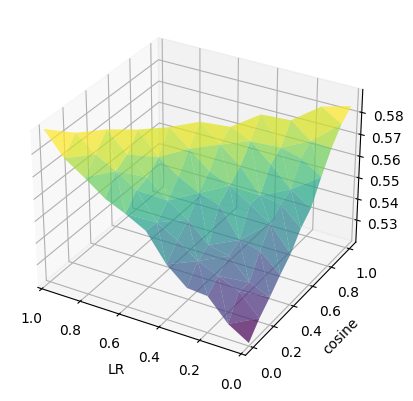

In [30]:
surface_pdf = pd.read_csv('../bin/netflix_surface_ndcg.csv')

fig = plt.figure()
ax = plt.axes(projection ='3d')
surf = ax.plot_trisurf(surface_pdf['LR'] * 4, surface_pdf['cosine'] * 4, surface_pdf['ndcg'], linewidth=0.1, alpha=0.7, color='b', cmap='viridis')

ax.set_xlabel("LR")
ax.set_ylabel("cosine")
ax.set_xlim([1,0])